# This notebook recreates plots in the results section of the paper

In [548]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
import corner
import scipy.stats as sps
from tqdm import trange
from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

from stardate.lhf import convective_overturn_time

plotpar = {'axes.labelsize': 25,
           'font.size': 20,
           'legend.fontsize': 20,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Produce plots for the simulated data.

Load the simulated data set.

In [59]:
df = pd.read_csv("data/simulated_data.csv")
true_age_gyr = (10**df.age)*1e-9

Text(0, 0.5, '$\\log(g)$')

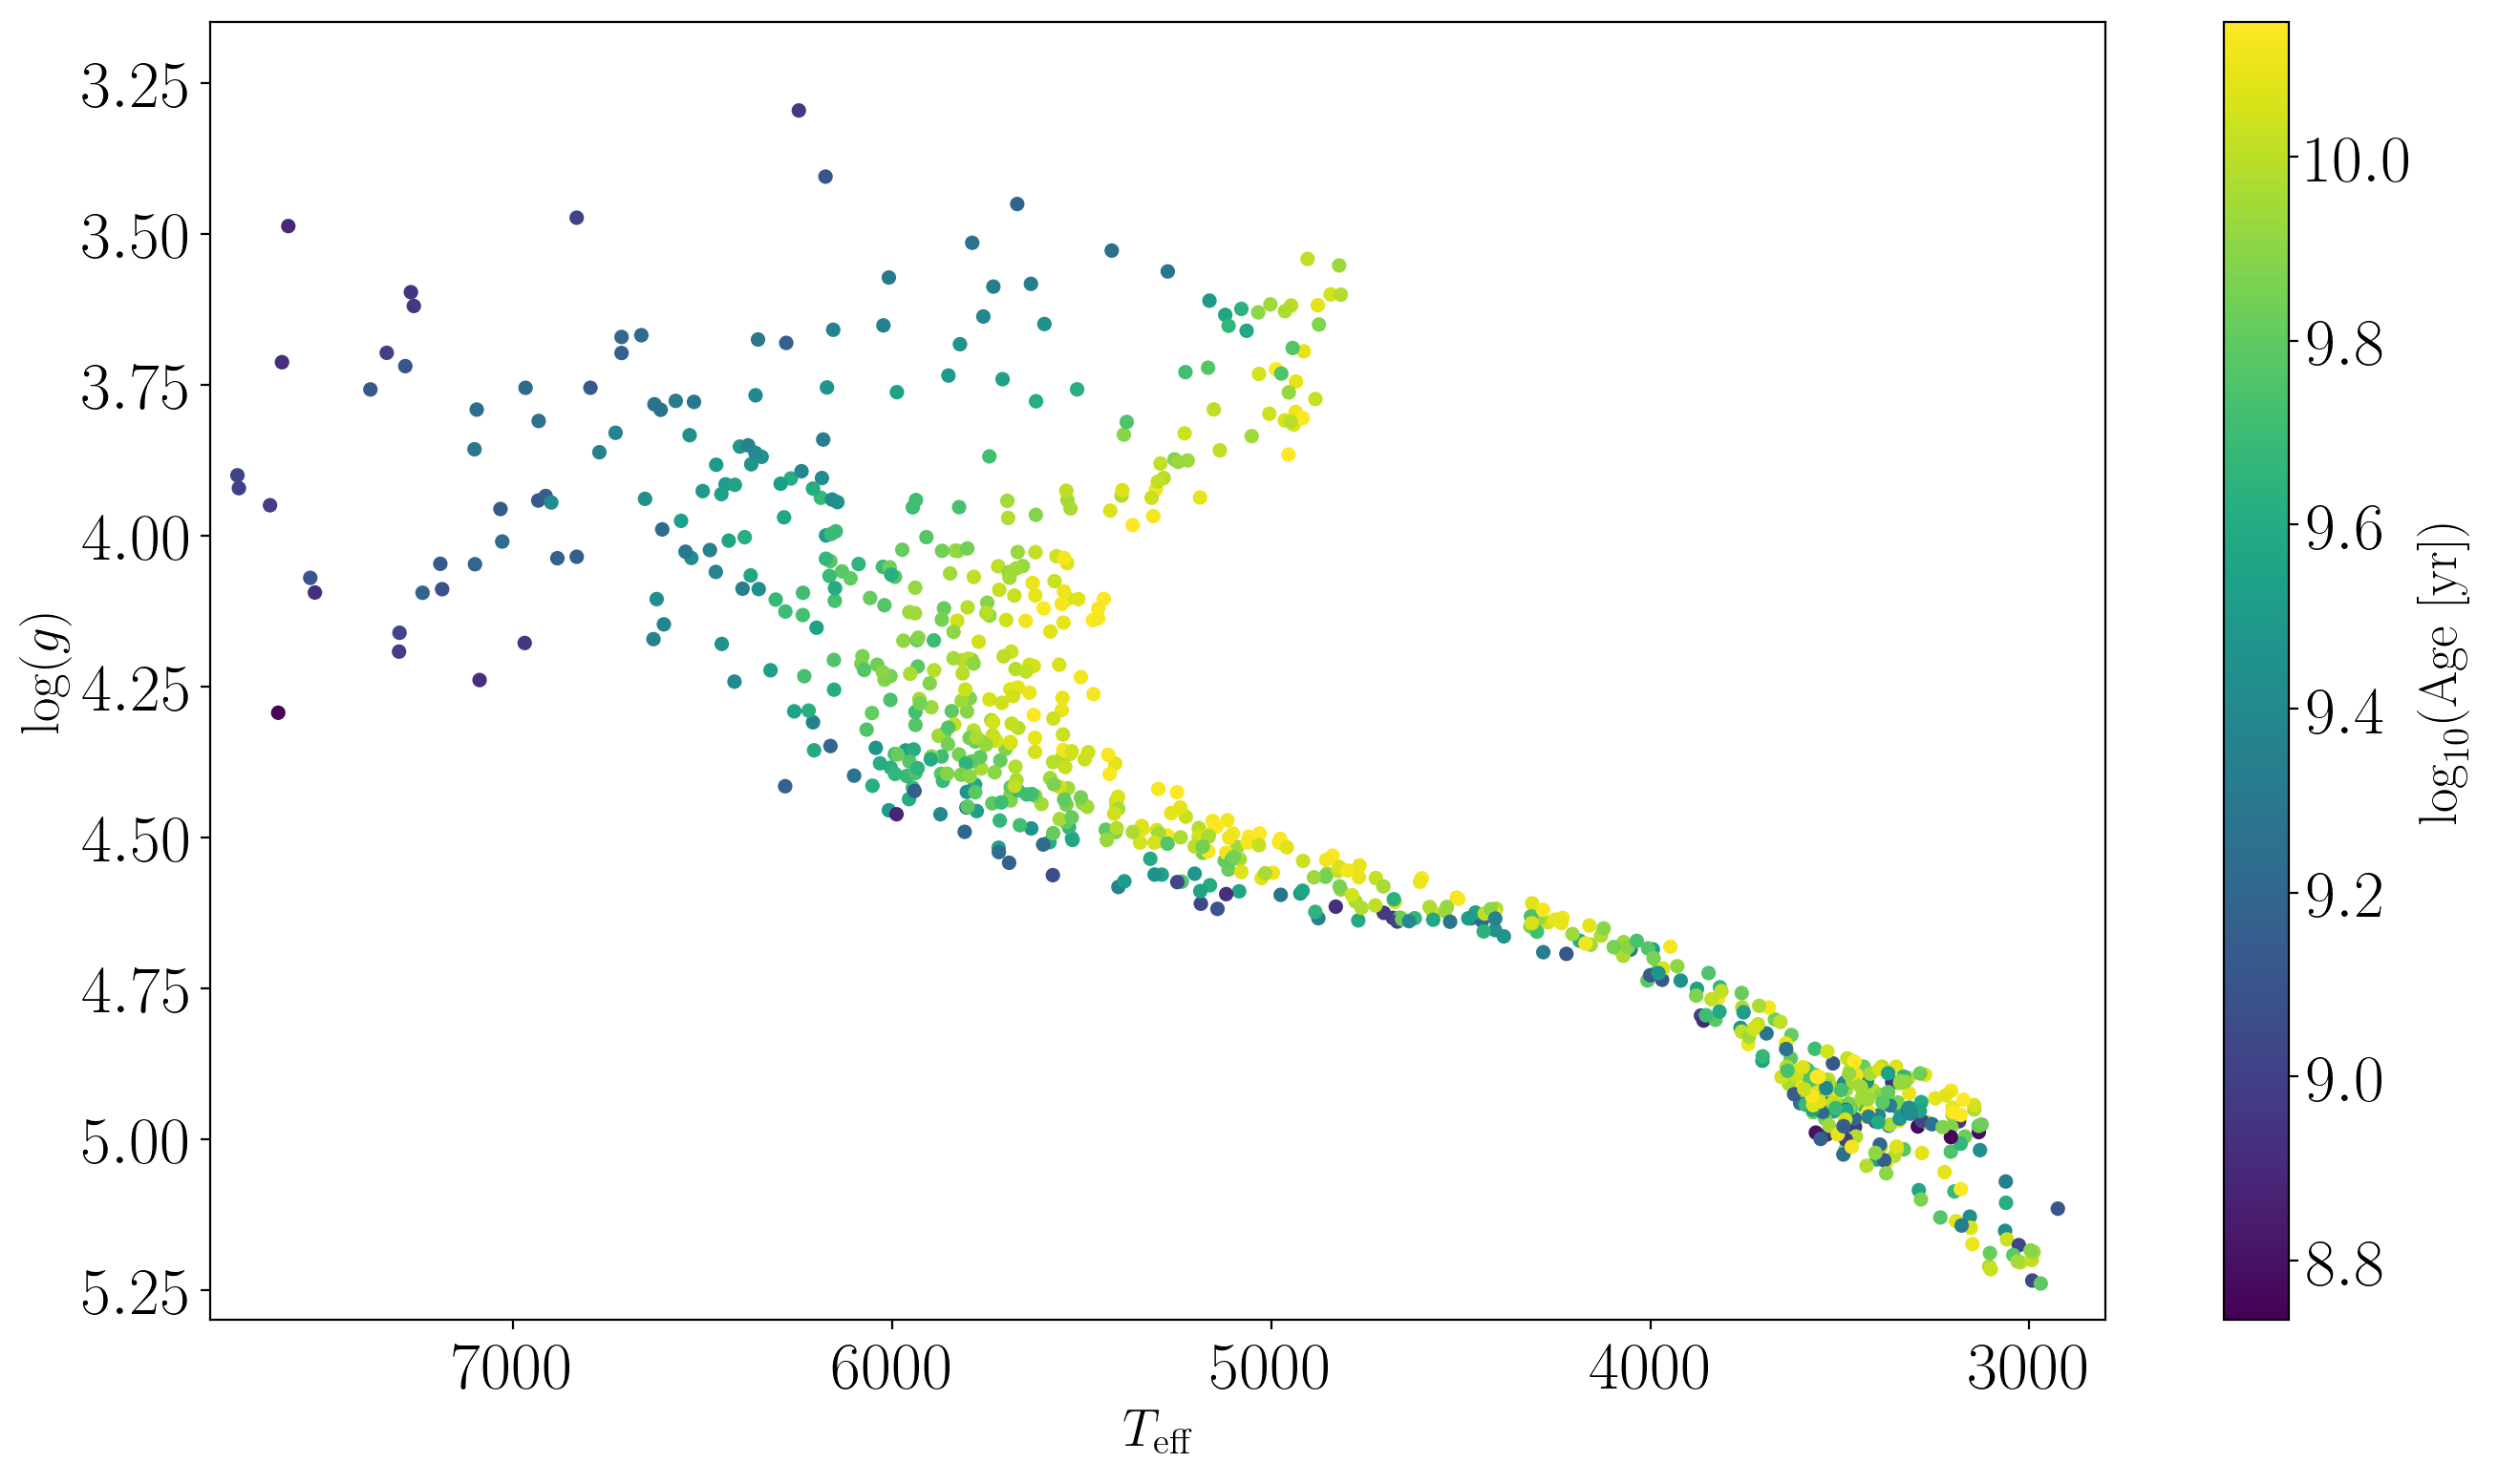

In [60]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff, df.logg, c=df.age, s=20)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
# plt.xlim(5500, 3000)
# plt.ylim(5, 4.5)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

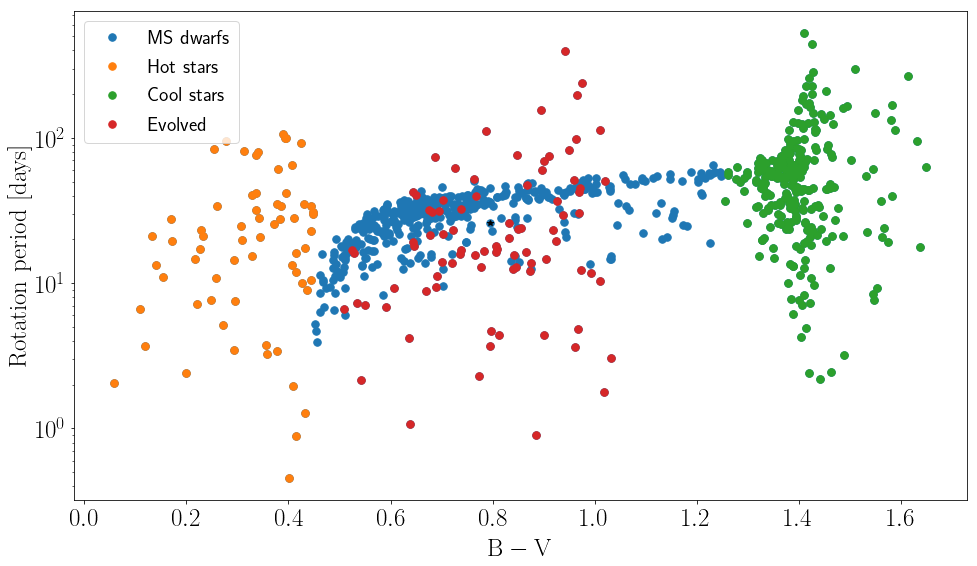

In [298]:
hot_mask = df.BV < .45
cool_mask = 1.25 < df.BV
evolved_mask = (.45 < df.BV) * (454 < df.eep)

plt.figure(figsize=(16, 9))
plt.plot(df.BV, df.prot, ".", ms=15 , zorder=0, label="MS dwarfs")
plt.plot(df.BV[hot_mask], df.prot[hot_mask], ".", ms=15 , zorder=1, label="Hot stars")
plt.plot(df.BV[cool_mask], df.prot[cool_mask], ".", ms=15 , zorder=1, label="Cool stars")
plt.plot(df.BV[evolved_mask], df.prot[evolved_mask], ".", ms=15, zorder=1, label="Evolved")
plt.legend()
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.yscale("log")
plt.plot(df.BV[69], df.prot[69], "k*")
# print(df.iloc[69])

Plot a corner plot for the first star.

0415_stardate.h5


[283.2153706416034, 8.9274565400676, 0.02941158058222932, 6.905017054369157, 0.02881845259595295]
12.496394949673086
[460.5279630516411, 10.126181449553362, 0.21085623165135137, 7.682445378167258, 0.09283054453250558]


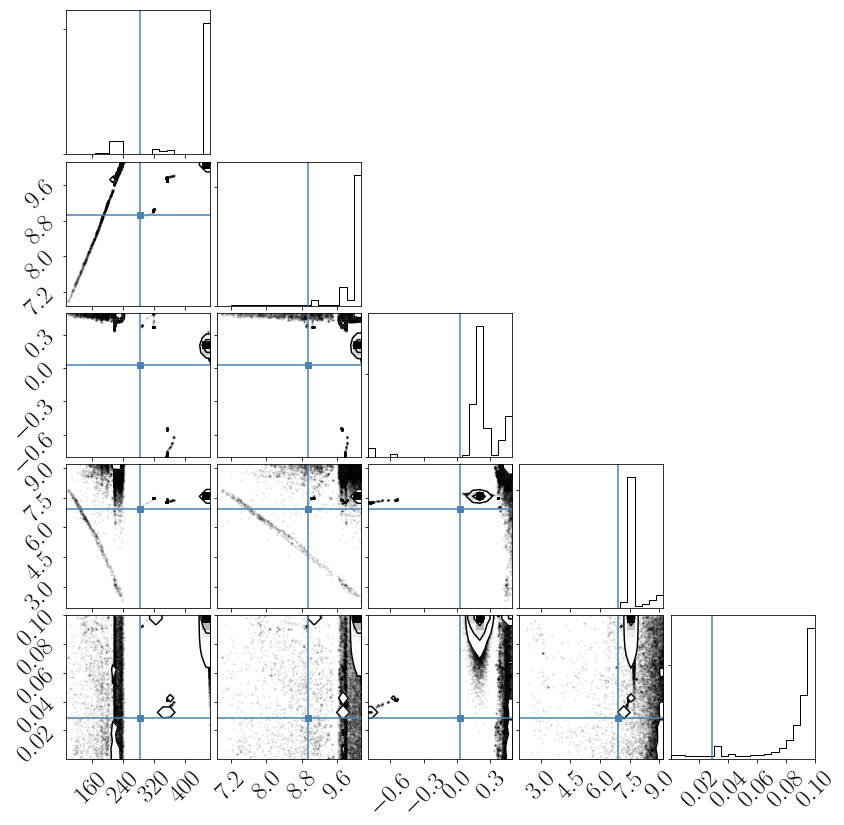

In [504]:
i = 415

fname = "{0}_stardate.h5".format(str(i).zfill(4))
# fname = "test/{0}_isochrones.h5".format(str(i).zfill(4))
print(fname)
reader = emcee.backends.HDFBackend(fname, read_only=True)
samples = reader.get_chain()
nsteps, nwalkers, ndim = np.shape(samples)
    
burnin = 100
samps = np.reshape(samples[burnin:, :, :], (nwalkers*(nsteps - burnin), ndim))
tr = [df.eep.values[i], df.age.values[i], df.feh.values[i], np.log(1./(df.parallax[i]*1e-3)), df.Av.values[i]]
corner.corner(samps, truths=tr);
print(tr)
print(df.prot.values[i])
print(list([np.median(samps[:, 0]), np.median(samps[:, 1]), np.median(samps[:, 2]),
      np.median(samps[:, 3]), np.median(samps[:, 4])]))

### And plot the trace.

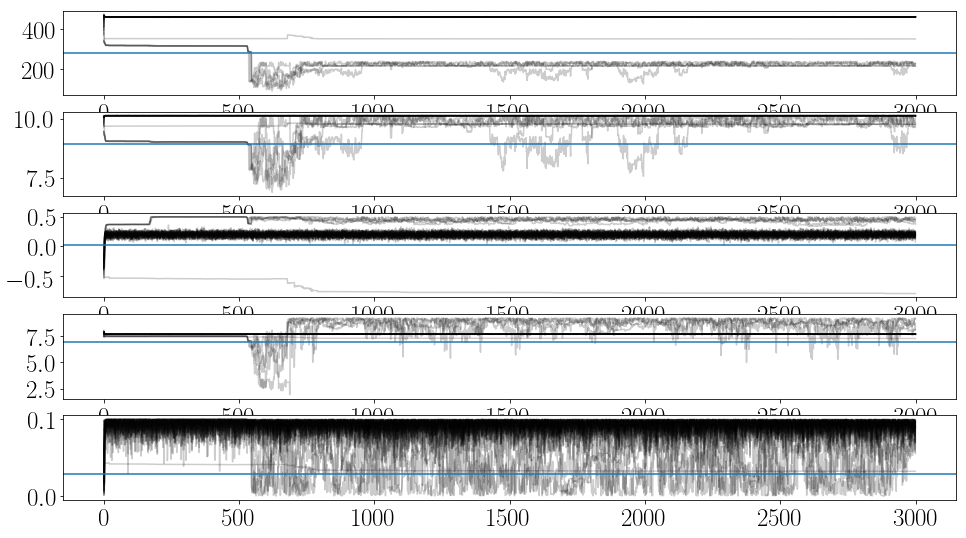

In [505]:
truths = [df.eep[i], df.age[i], df.feh[i], np.log(df.d_kpc[i]*1e3), df.Av[i]]

nsteps, nwalkers, ndim = np.shape(samples)
flat = np.reshape(samples, (nsteps*nwalkers, ndim))
plt.figure(figsize=(16, 9))
for j in range(5):
    plt.subplot(5, 1, j+1)
    plt.plot(samples[:, :, j], color="k", alpha=.2)
    plt.axhline(truths[j])

Now plot all the results.

In [488]:
def read_files(name, N=1000):

    meds, stds, age_samps, resids, errp, errm = [], [], [], [], [], []
    eeps, eep_errp, eep_errm, inds = [], [], [], []
    avs, av_errp, av_errm = [], [], []

    burnin = 100

    for i in range(N):
        try:
            fname = "{0}_{1}.h5".format(str(i).zfill(4), name)
            reader = emcee.backends.HDFBackend(fname)
            samples = reader.get_chain()
            
            if np.shape(samples)[0] > 10:
                nsteps, nwalkers, ndim = np.shape(samples)
                samps = np.reshape(samples, (nsteps*nwalkers, ndim))

                eep_samps = samps[burnin:, 0]
                eeps.append(np.median(eep_samps))
                upper = np.percentile(eep_samps, 84)
                lower = np.percentile(eep_samps, 16)
                eep_errp.append(upper-np.median(eep_samps))
                eep_errm.append(np.median(eep_samps)-lower)
            
                lin_samps = (10**samps[burnin:, 1])*1e-9
                age_samps.append(lin_samps)
                meds.append(np.median(lin_samps))
                stds.append(np.std(lin_samps))
                upper = np.percentile(lin_samps, 84)
                lower = np.percentile(lin_samps, 16)
                errp.append(upper-np.median(lin_samps))
                errm.append(np.median(lin_samps)-lower)
        
                av_samps = samps[burnin:, 4]
                avs.append(np.median(av_samps))
                upper = np.percentile(av_samps, 84)
                lower = np.percentile(av_samps, 16)
                av_errp.append(upper-np.median(av_samps))
                av_errm.append(np.median(av_samps)-lower)
        
                inds.append(i)
        
        except:
            pass
    
    meds, stds, errp, errm = np.array(meds), np.array(stds), np.array(errp), np.array(errm)
    return age_samps, meds, stds, errp, errm, eeps, eep_errp, eep_errm, avs, av_errp, av_errm, inds

age_samps, meds, stds, errp, errm, eeps, eep_errp, eep_errm, avs, av_errp, av_errm, inds = read_files("stardate")

print(len(eeps), len(inds), len(meds))
print(inds)

103 103 103
[0, 1, 2, 9, 10, 18, 19, 20, 26, 27, 28, 29, 32, 36, 39, 40, 45, 46, 49, 54, 56, 58, 63, 68, 72, 78, 79, 80, 81, 83, 84, 90, 91, 96, 99, 100, 101, 108, 109, 110, 111, 117, 118, 126, 127, 128, 135, 137, 144, 145, 147, 148, 149, 150, 153, 155, 159, 162, 164, 170, 171, 179, 180, 183, 185, 186, 187, 188, 189, 190, 196, 198, 199, 201, 207, 212, 216, 219, 220, 221, 225, 236, 237, 244, 245, 253, 261, 262, 287, 322, 327, 341, 348, 359, 366, 377, 383, 391, 398, 407, 415, 424, 432]


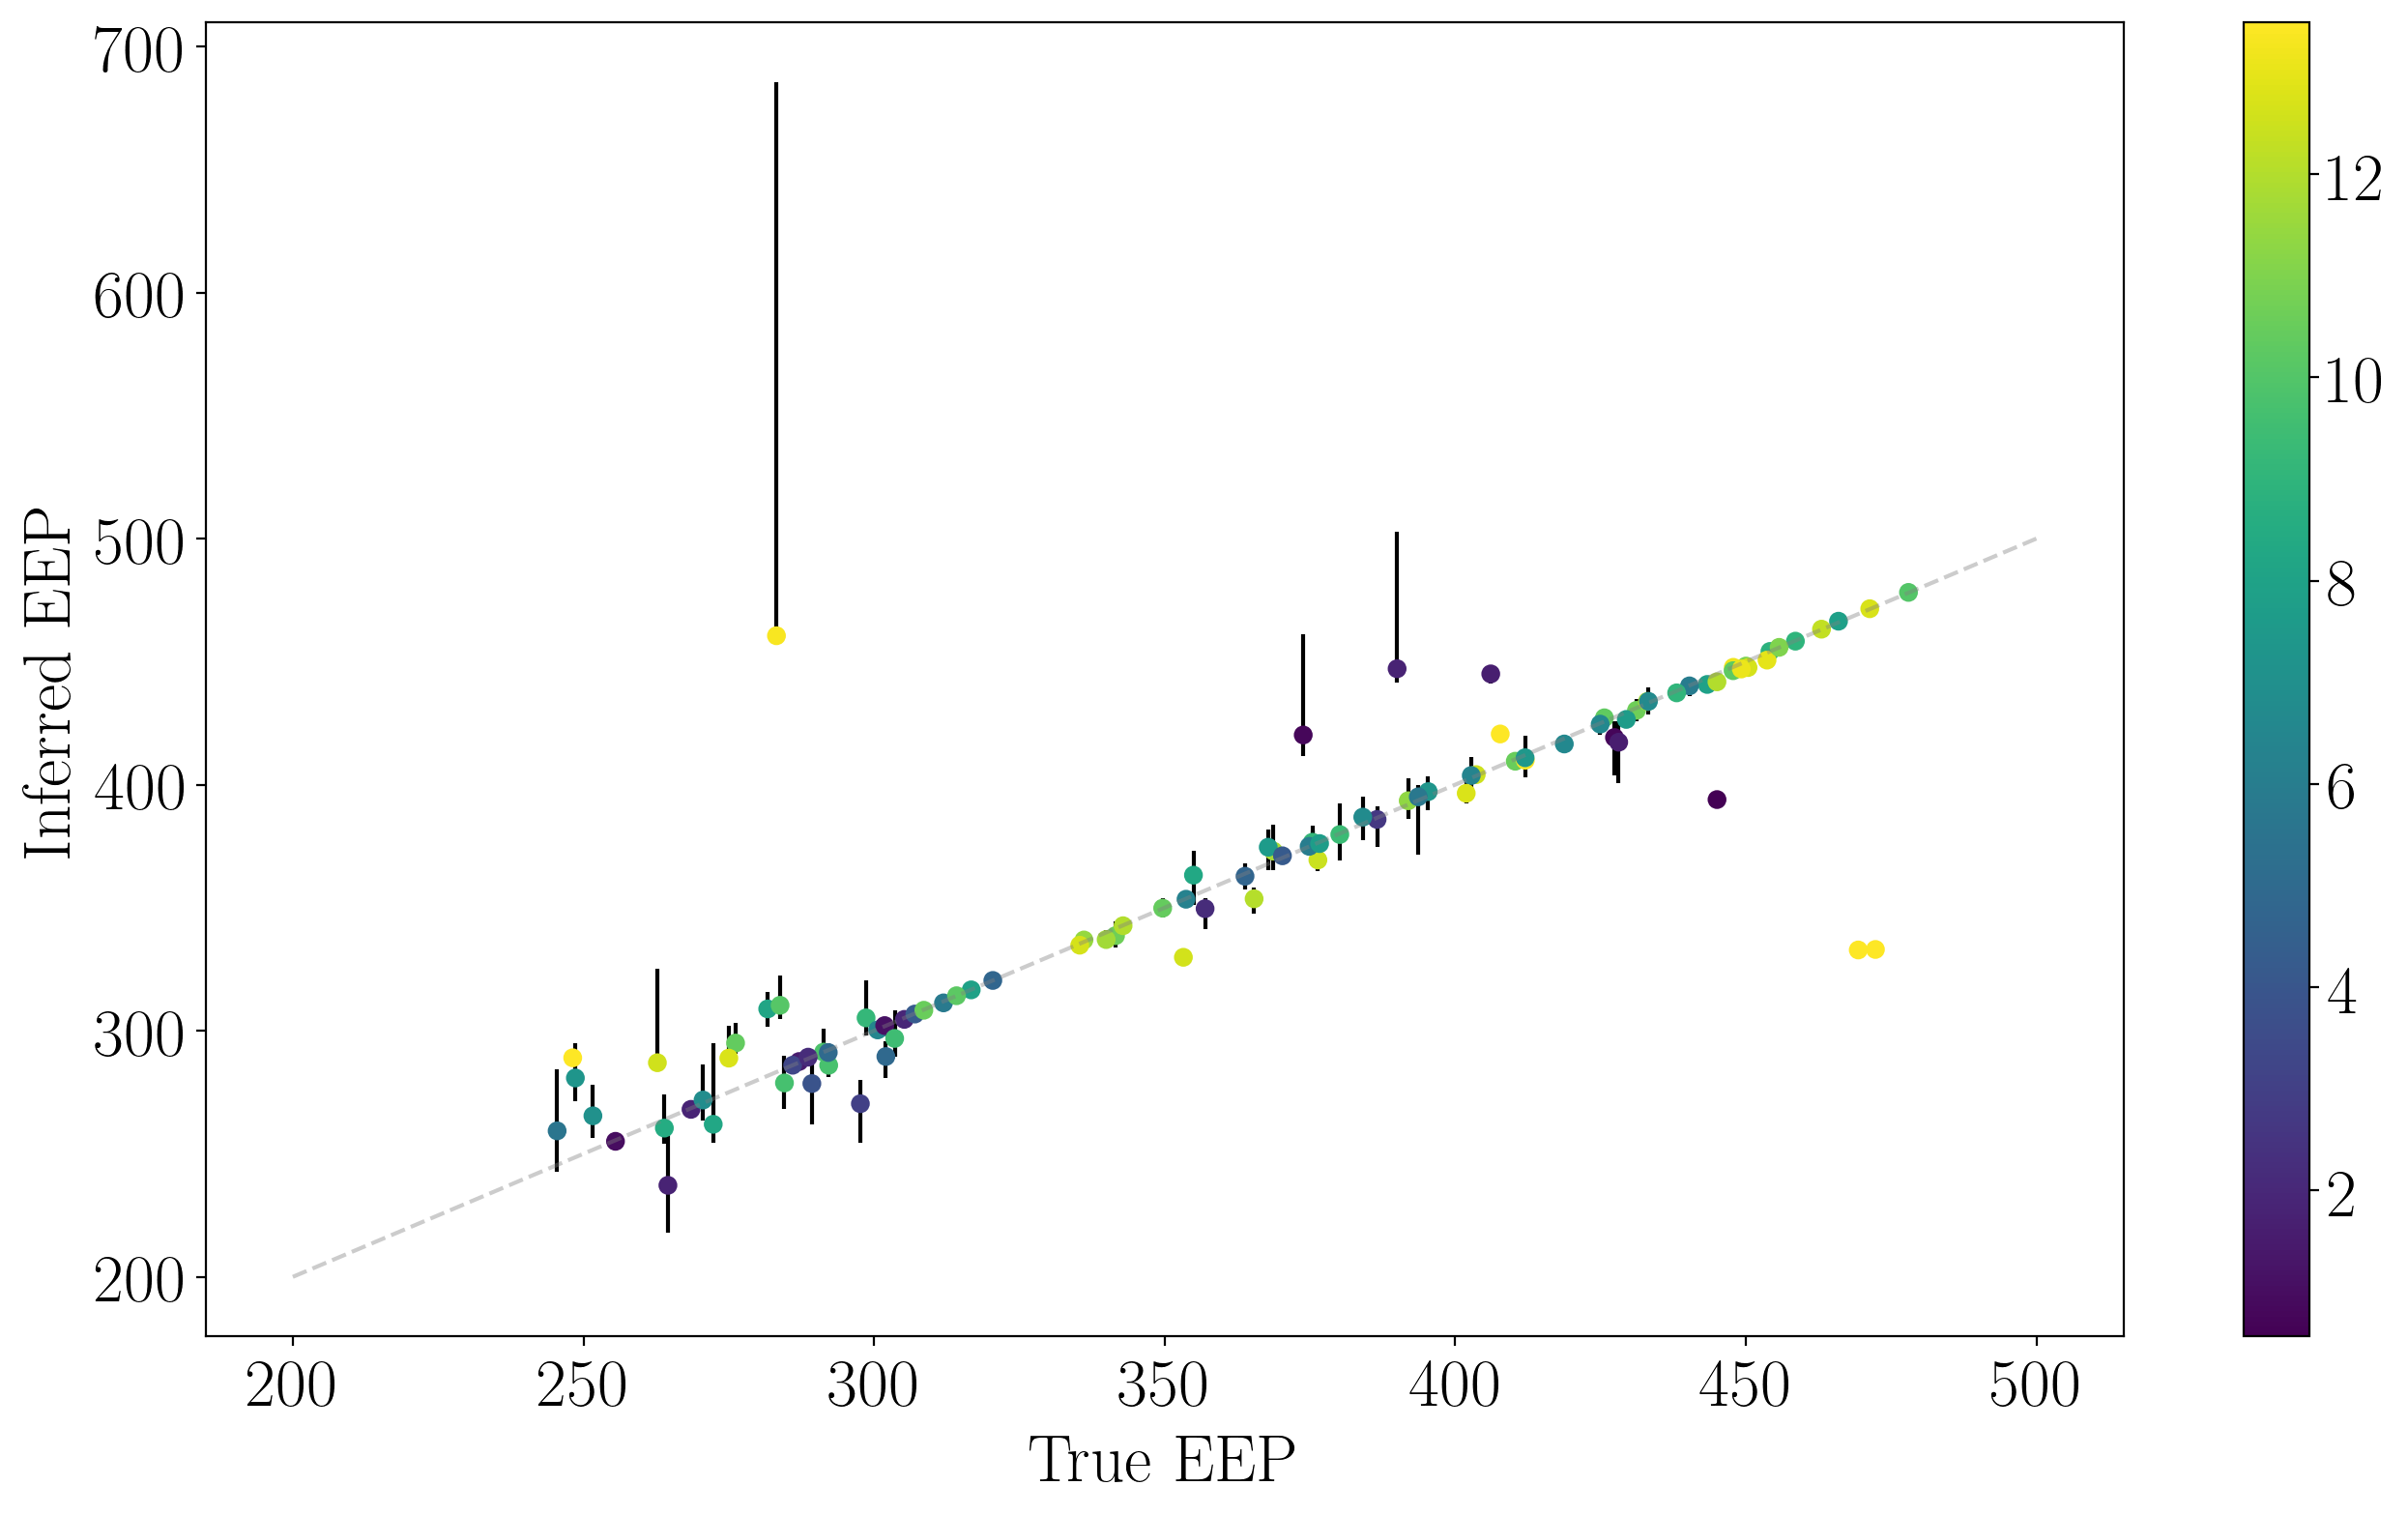

In [489]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(df.eep.values[inds], eeps, yerr=[eep_errp, eep_errm], fmt=".", color="k", zorder=0)
plt.scatter(df.eep.values[inds], eeps, c=meds)
plt.colorbar()
plt.xlabel("$\mathrm{True~EEP}$")
plt.ylabel("$\mathrm{Inferred~EEP}$")
eep_xs = np.linspace(200, 500, 100)
plt.plot(eep_xs, eep_xs, ".5", ls="--", alpha=.4)

Select stars of different types.

In [514]:
def selection(df, inds):

    hot_cut, cool_cut, giant_cut, ro_cut = .45, 1.35, 440, 1.8
    Ro = (df.prot.values[inds]/convective_overturn_time(df.mass.values[inds]))
    evolved = (df.eep.values[inds] > giant_cut) * (df.BV.values[inds] > hot_cut)
    hot = (df.BV.values[inds] < hot_cut) * (df.eep.values[inds] < giant_cut)
    hot_evolved = (df.BV.values[inds] < hot_cut) * (df.eep.values[inds] > giant_cut)
    cool = (df.BV.values[inds] > cool_cut) * (df.eep.values[inds] < giant_cut) * (Ro < ro_cut)
    fgk = (df.eep.values[inds] < giant_cut) * (df.BV.values[inds] > hot_cut) * (df.BV.values[inds] < cool_cut) \
            * (Ro < ro_cut)
    rossbied = (Ro > ro_cut) * (df.BV.values[inds] > hot_cut) * (df.BV.values[inds] < cool_cut) \
        * (df.eep.values[inds] < giant_cut)
    return fgk, hot, cool, evolved, rossbied

fgk, hot, cool, evolved, rossbied = selection(df, inds)

In [515]:
# plt.figure(figsize=(16, 9), dpi=200)
# plt.errorbar(true_age_gyr[inds][fgk], meds[fgk], yerr=[errm[fgk], errp[fgk]], fmt=".", alpha=.5,
#              ms=20, zorder=0, label="$\mathrm{FGK~dwarfs}$", rasterized=True, color="tab:orange")

# plt.xlabel("$\mathrm{True~age~[Gyr]}$")
# plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# xs = np.linspace(0, 14, 100)
# plt.plot(xs, xs, ".5", ls="--", alpha=.4)
# plt.xlim(0, 14)
# plt.legend()

In [516]:
# plt.figure(figsize=(16, 9), dpi=200)
# plt.errorbar(true_age_gyr[inds][evolved], meds[evolved], yerr=[errm[evolved], errp[evolved]], fmt=".", alpha=.5,
#              ms=20, zorder=0, label="$\mathrm{Evolved}$", rasterized=True, color="tab:green")
# plt.xlabel("$\mathrm{True~age~[Gyr]}$")
# plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# xs = np.linspace(0, 14, 100)
# plt.plot(xs, xs, ".5", ls="--", alpha=.4)
# plt.xlim(0, 14)
# plt.legend()

In [517]:
# plt.figure(figsize=(16, 9), dpi=200)
# plt.errorbar(true_age_gyr[inds][hot], meds[hot], yerr=[errm[hot], errp[hot]], fmt=".", alpha=.5, 
#              color="tab:cyan", ms=20, zorder=0, label="$\mathrm{Hot~dwarfs}$", rasterized=True)
# plt.xlabel("$\mathrm{True~age~[Gyr]}$")
# plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# xs = np.linspace(0, 14, 100)
# plt.plot(xs, xs, ".5", ls="--", alpha=.4)
# plt.xlim(0, 14)
# plt.legend()

In [518]:
# plt.figure(figsize=(16, 9), dpi=200)
# plt.errorbar(true_age_gyr[inds][rossbied], meds[rossbied], yerr=[errm[rossbied], errp[rossbied]], fmt=".", alpha=.5, 
#              color="tab:purple", ms=20, zorder=0, label="$\mathrm{Old~dwarfs}$", rasterized=True)
# plt.xlabel("$\mathrm{True~age~[Gyr]}$")
# plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# xs = np.linspace(0, 14, 100)
# plt.plot(xs, xs, ".5", ls="--", alpha=.4)
# plt.xlim(0, 14)
# plt.legend()

In [519]:
# plt.figure(figsize=(16, 9), dpi=200)
# plt.errorbar(true_age_gyr[inds][cool], meds[cool], yerr=[errm[cool], errp[cool]], fmt=".", alpha=.5,
#              color="tab:red", ms=20, zorder=0, label="$\mathrm{Cool~dwarfs}$", rasterized=True)
# plt.xlabel("$\mathrm{True~age~[Gyr]}$")
# plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# xs = np.linspace(0, 14, 100)
# plt.plot(xs, xs, ".5", ls="--", alpha=.4)
# plt.xlim(0, 14)
# plt.legend()

(0, 14)

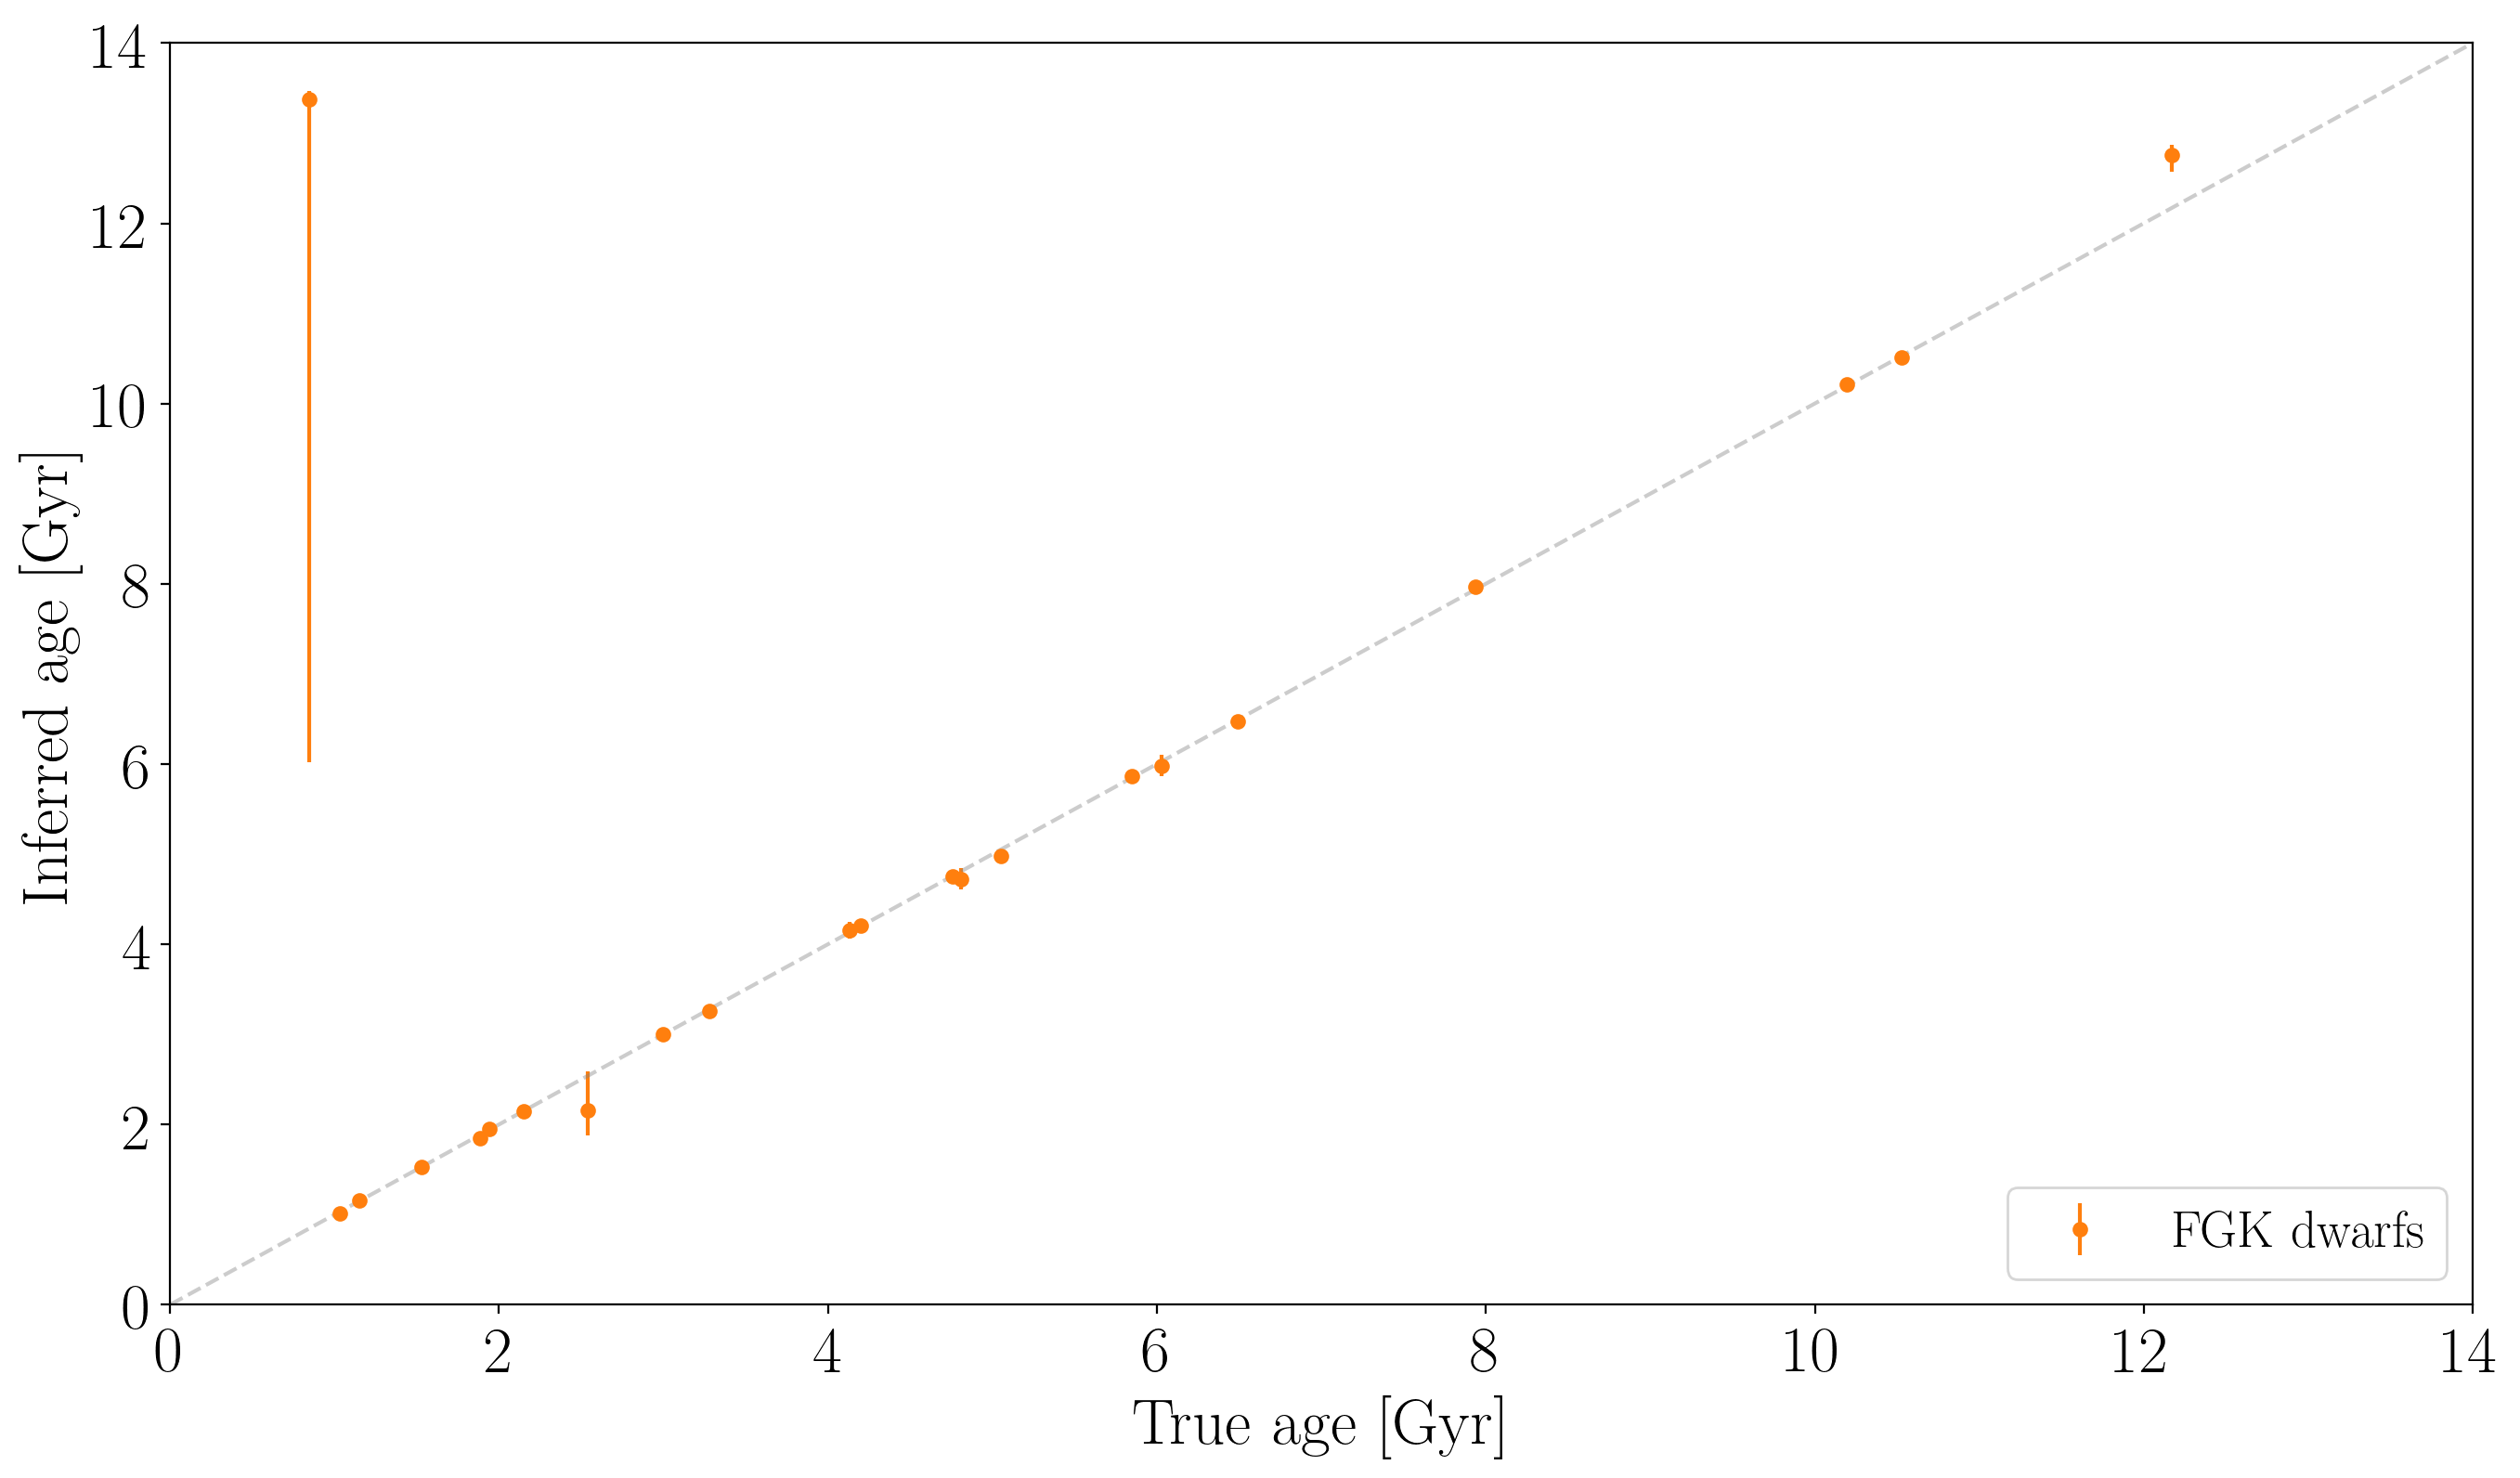

In [520]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=200)
age_samps = np.array(age_samps)
# parts = axes.violinplot(age_samps[fgk], true_age_gyr[inds][fgk], points=50, widths=0.3,
#                 showmeans=False, showextrema=False, showmedians=False)
# for v in parts["bodies"]:
#     v.set_facecolor("tab:orange")
#     v.set_edgecolor("tab:orange")
plt.errorbar(true_age_gyr[inds][fgk], meds[fgk], yerr=[errm[fgk], errp[fgk]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{FGK~dwarfs}$", rasterized=True, color="tab:orange")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.legend()
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)

In [521]:
print(np.array(inds)[fgk][meds[fgk] > 12])

[196 415]


(0, 14)

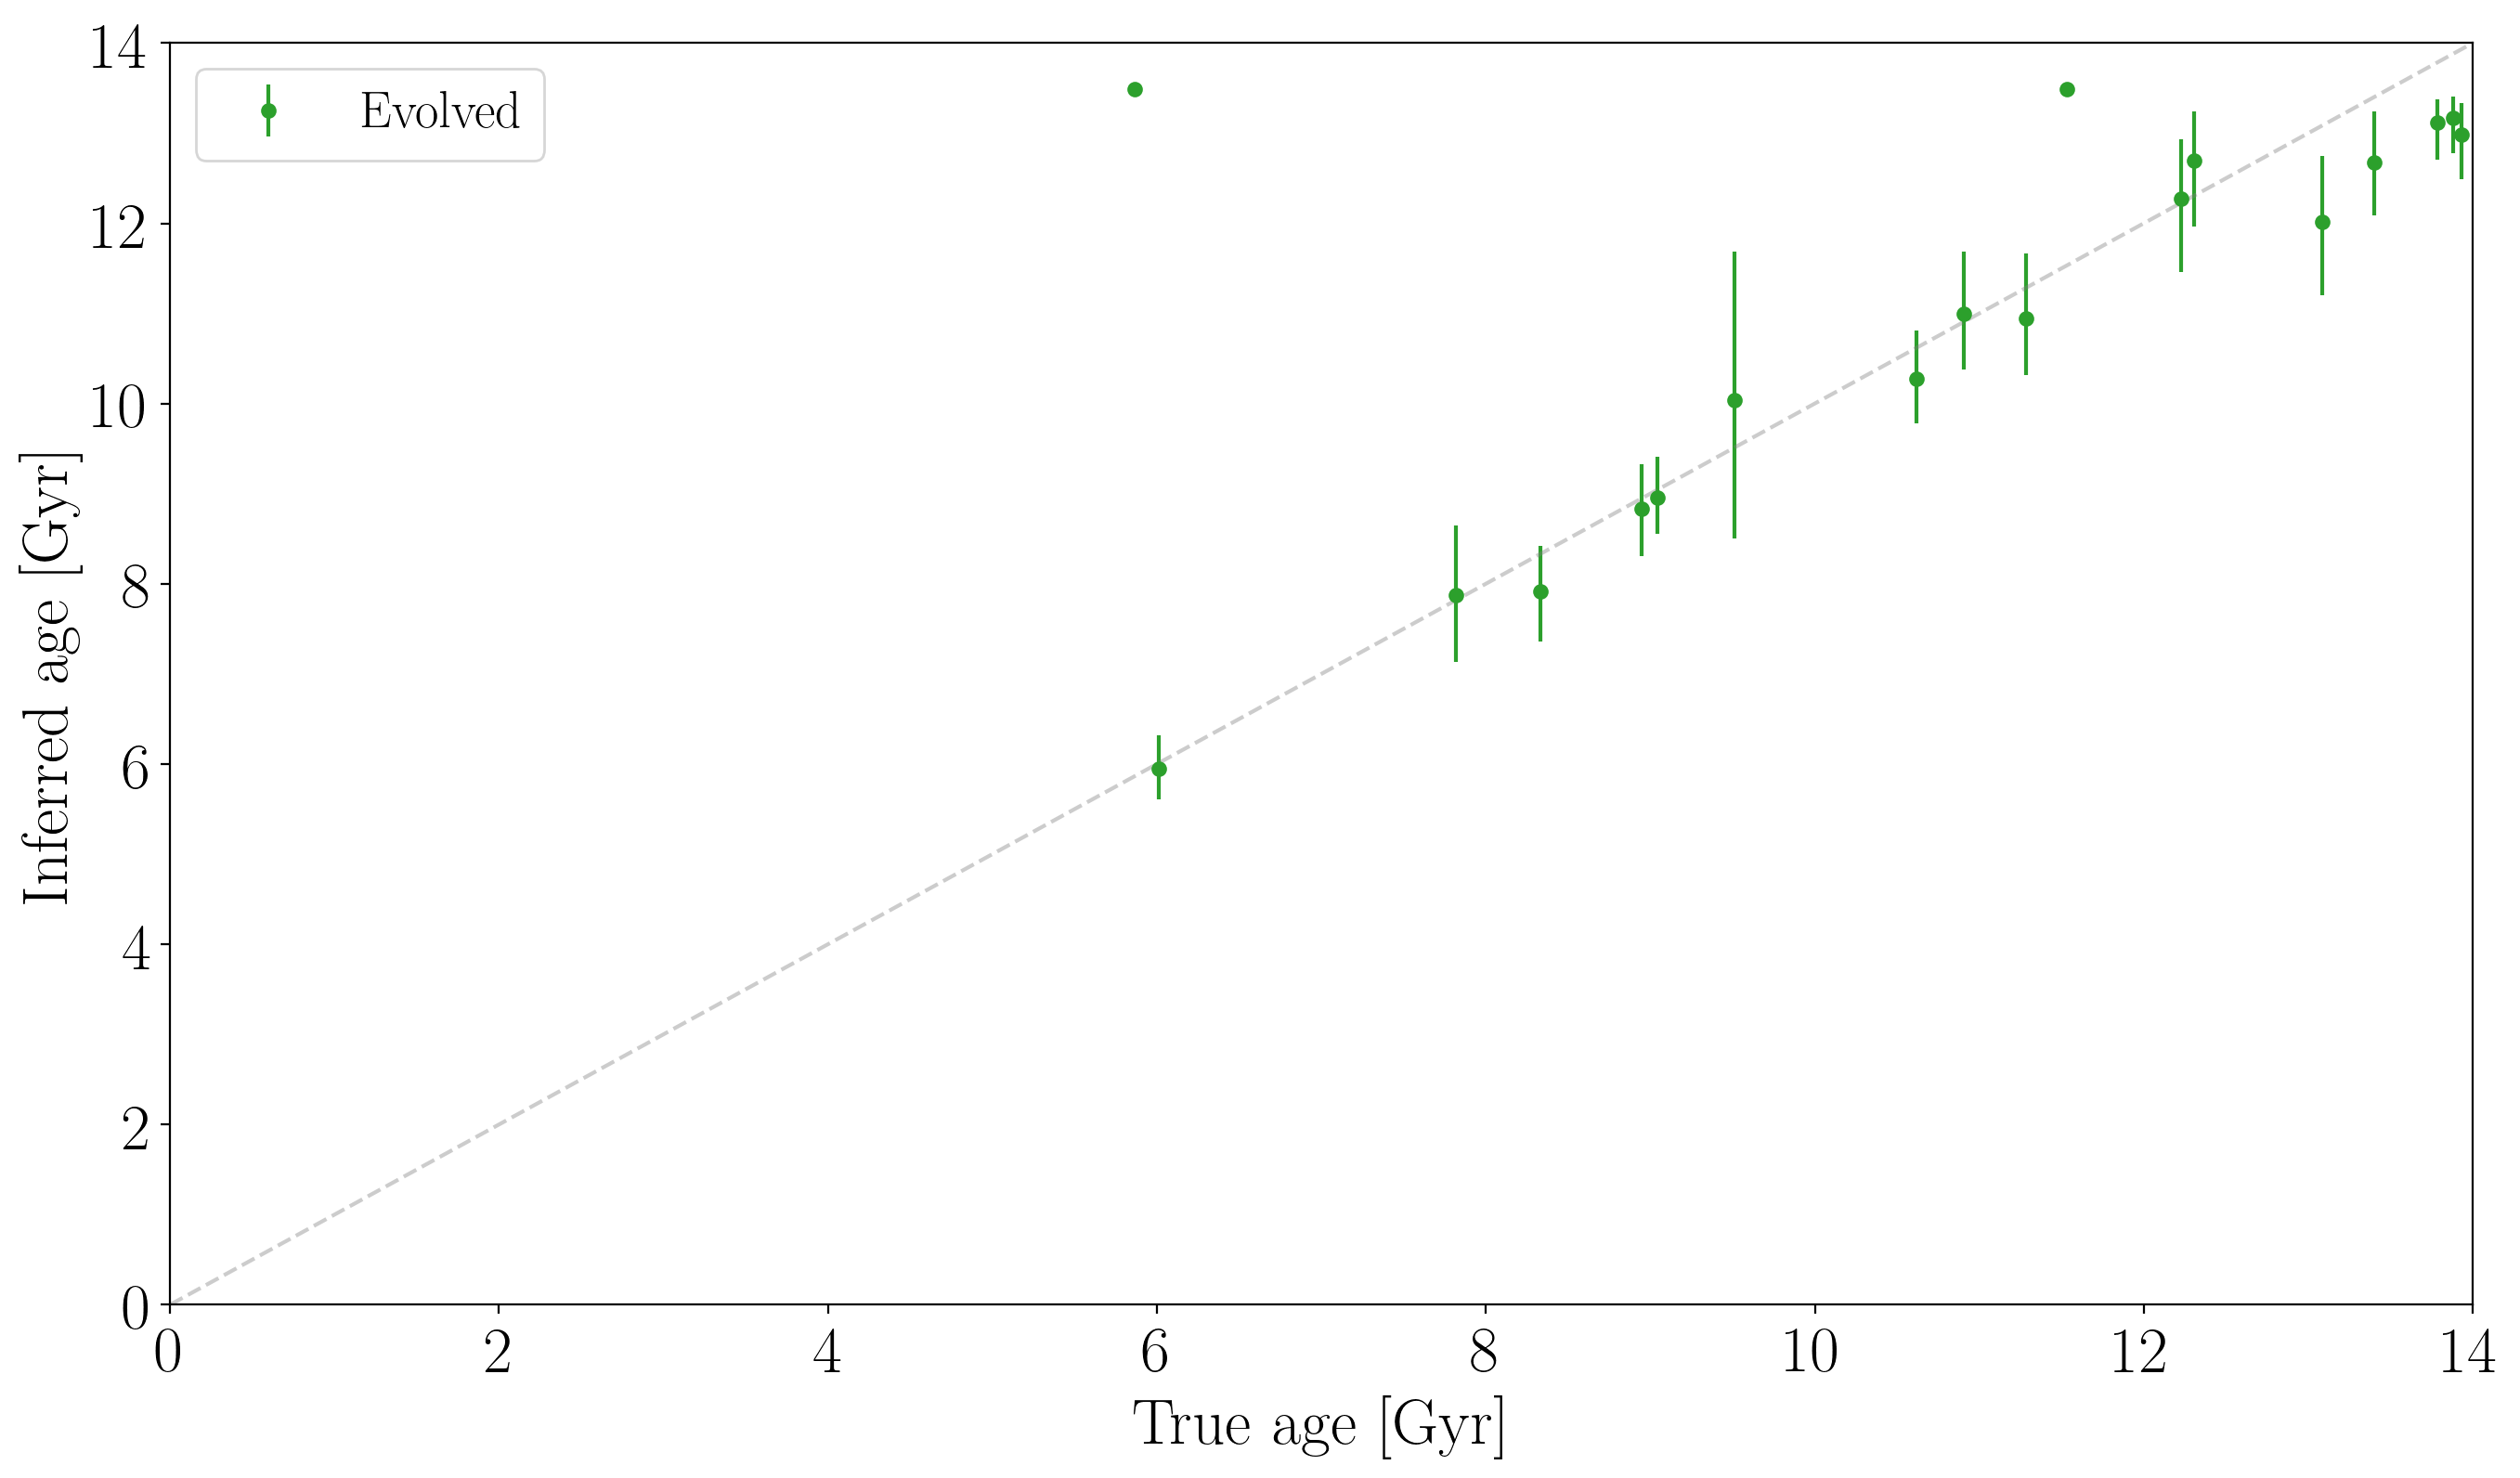

In [522]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=200)
# parts = axes.violinplot(age_samps[evolved], true_age_gyr[inds][evolved], points=50, widths=0.3,
#                 showmeans=False, showextrema=False, showmedians=False)
# for v in parts["bodies"]:
#     v.set_facecolor("tab:green")
#     v.set_edgecolor("tab:green")
plt.errorbar(true_age_gyr[inds][evolved], meds[evolved], yerr=[errm[evolved], errp[evolved]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{Evolved}$", rasterized=True, color="tab:green")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.legend()
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)

(0, 14)

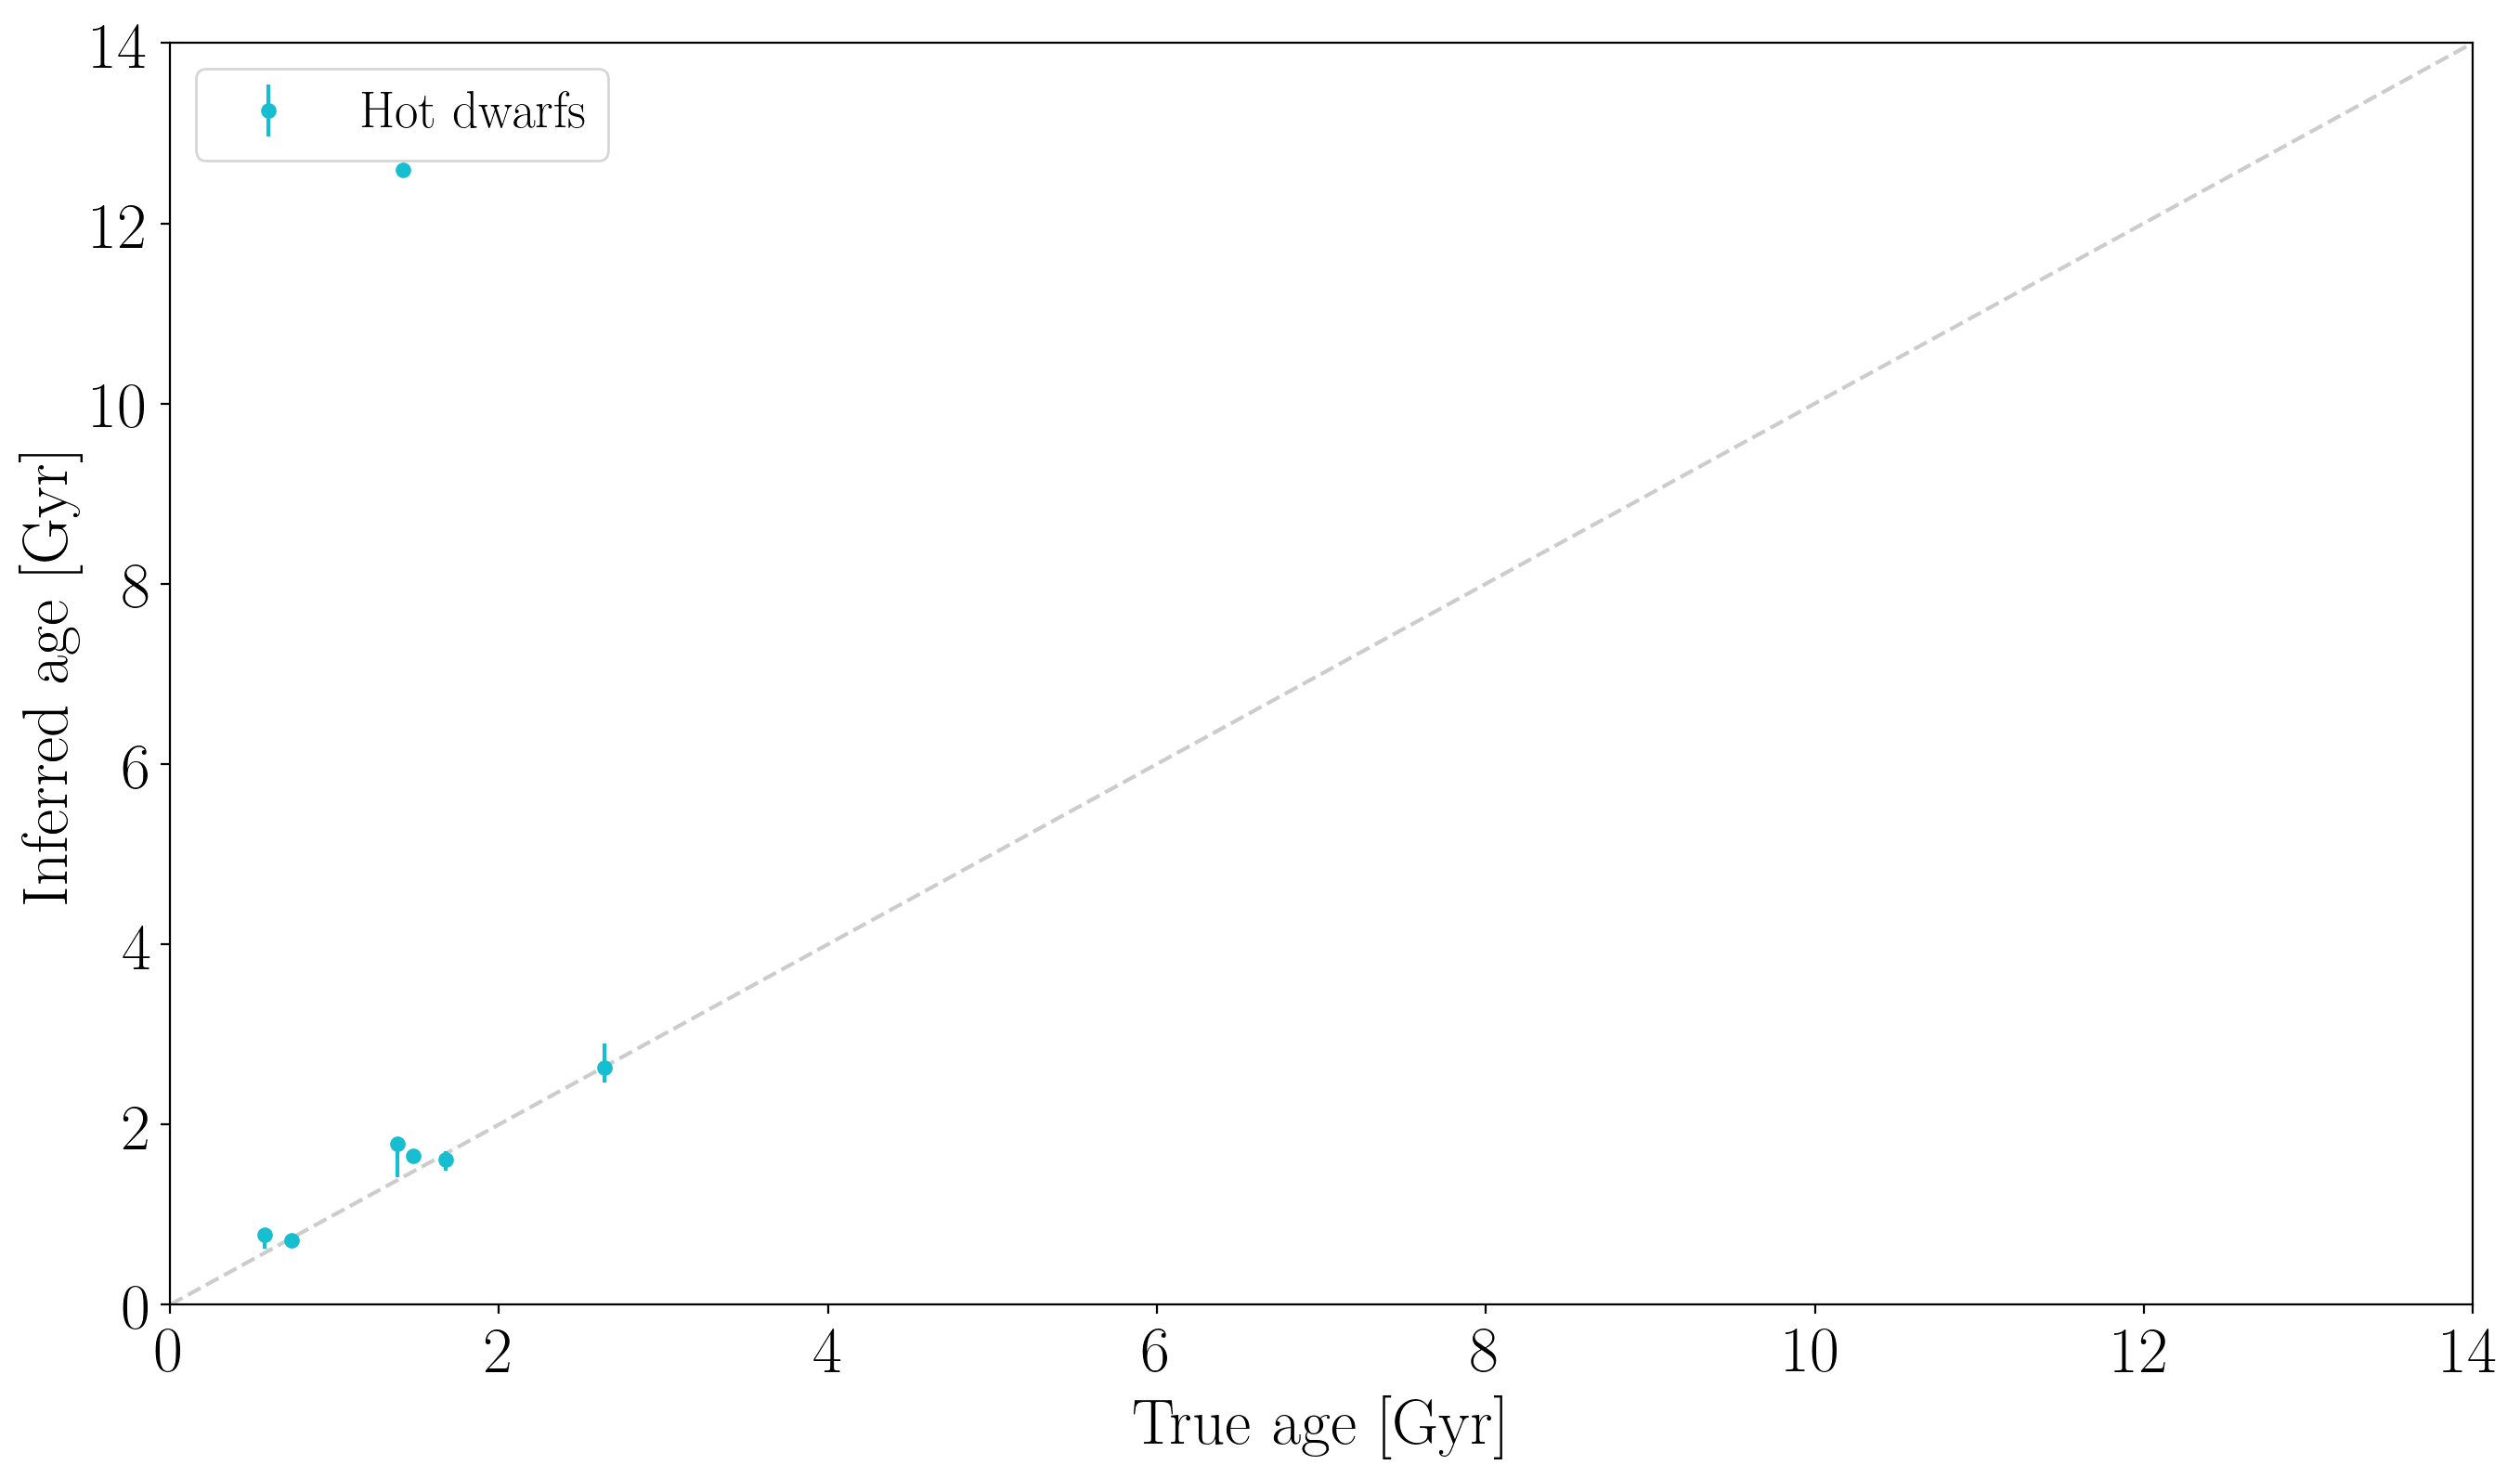

In [523]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=200)
# parts = axes.violinplot(age_samps[hot], true_age_gyr[inds][hot], points=50, widths=0.3,
#                 showmeans=False, showextrema=False, showmedians=False)
# for v in parts["bodies"]:
#     v.set_facecolor("tab:cyan")
#     v.set_edgecolor("tab:cyan")
plt.errorbar(true_age_gyr[inds][hot], meds[hot], yerr=[errm[hot], errp[hot]], fmt=".", 
             color="tab:cyan", ms=10, zorder=2, label="$\mathrm{Hot~dwarfs}$", rasterized=True)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.legend()
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)

(0, 14)

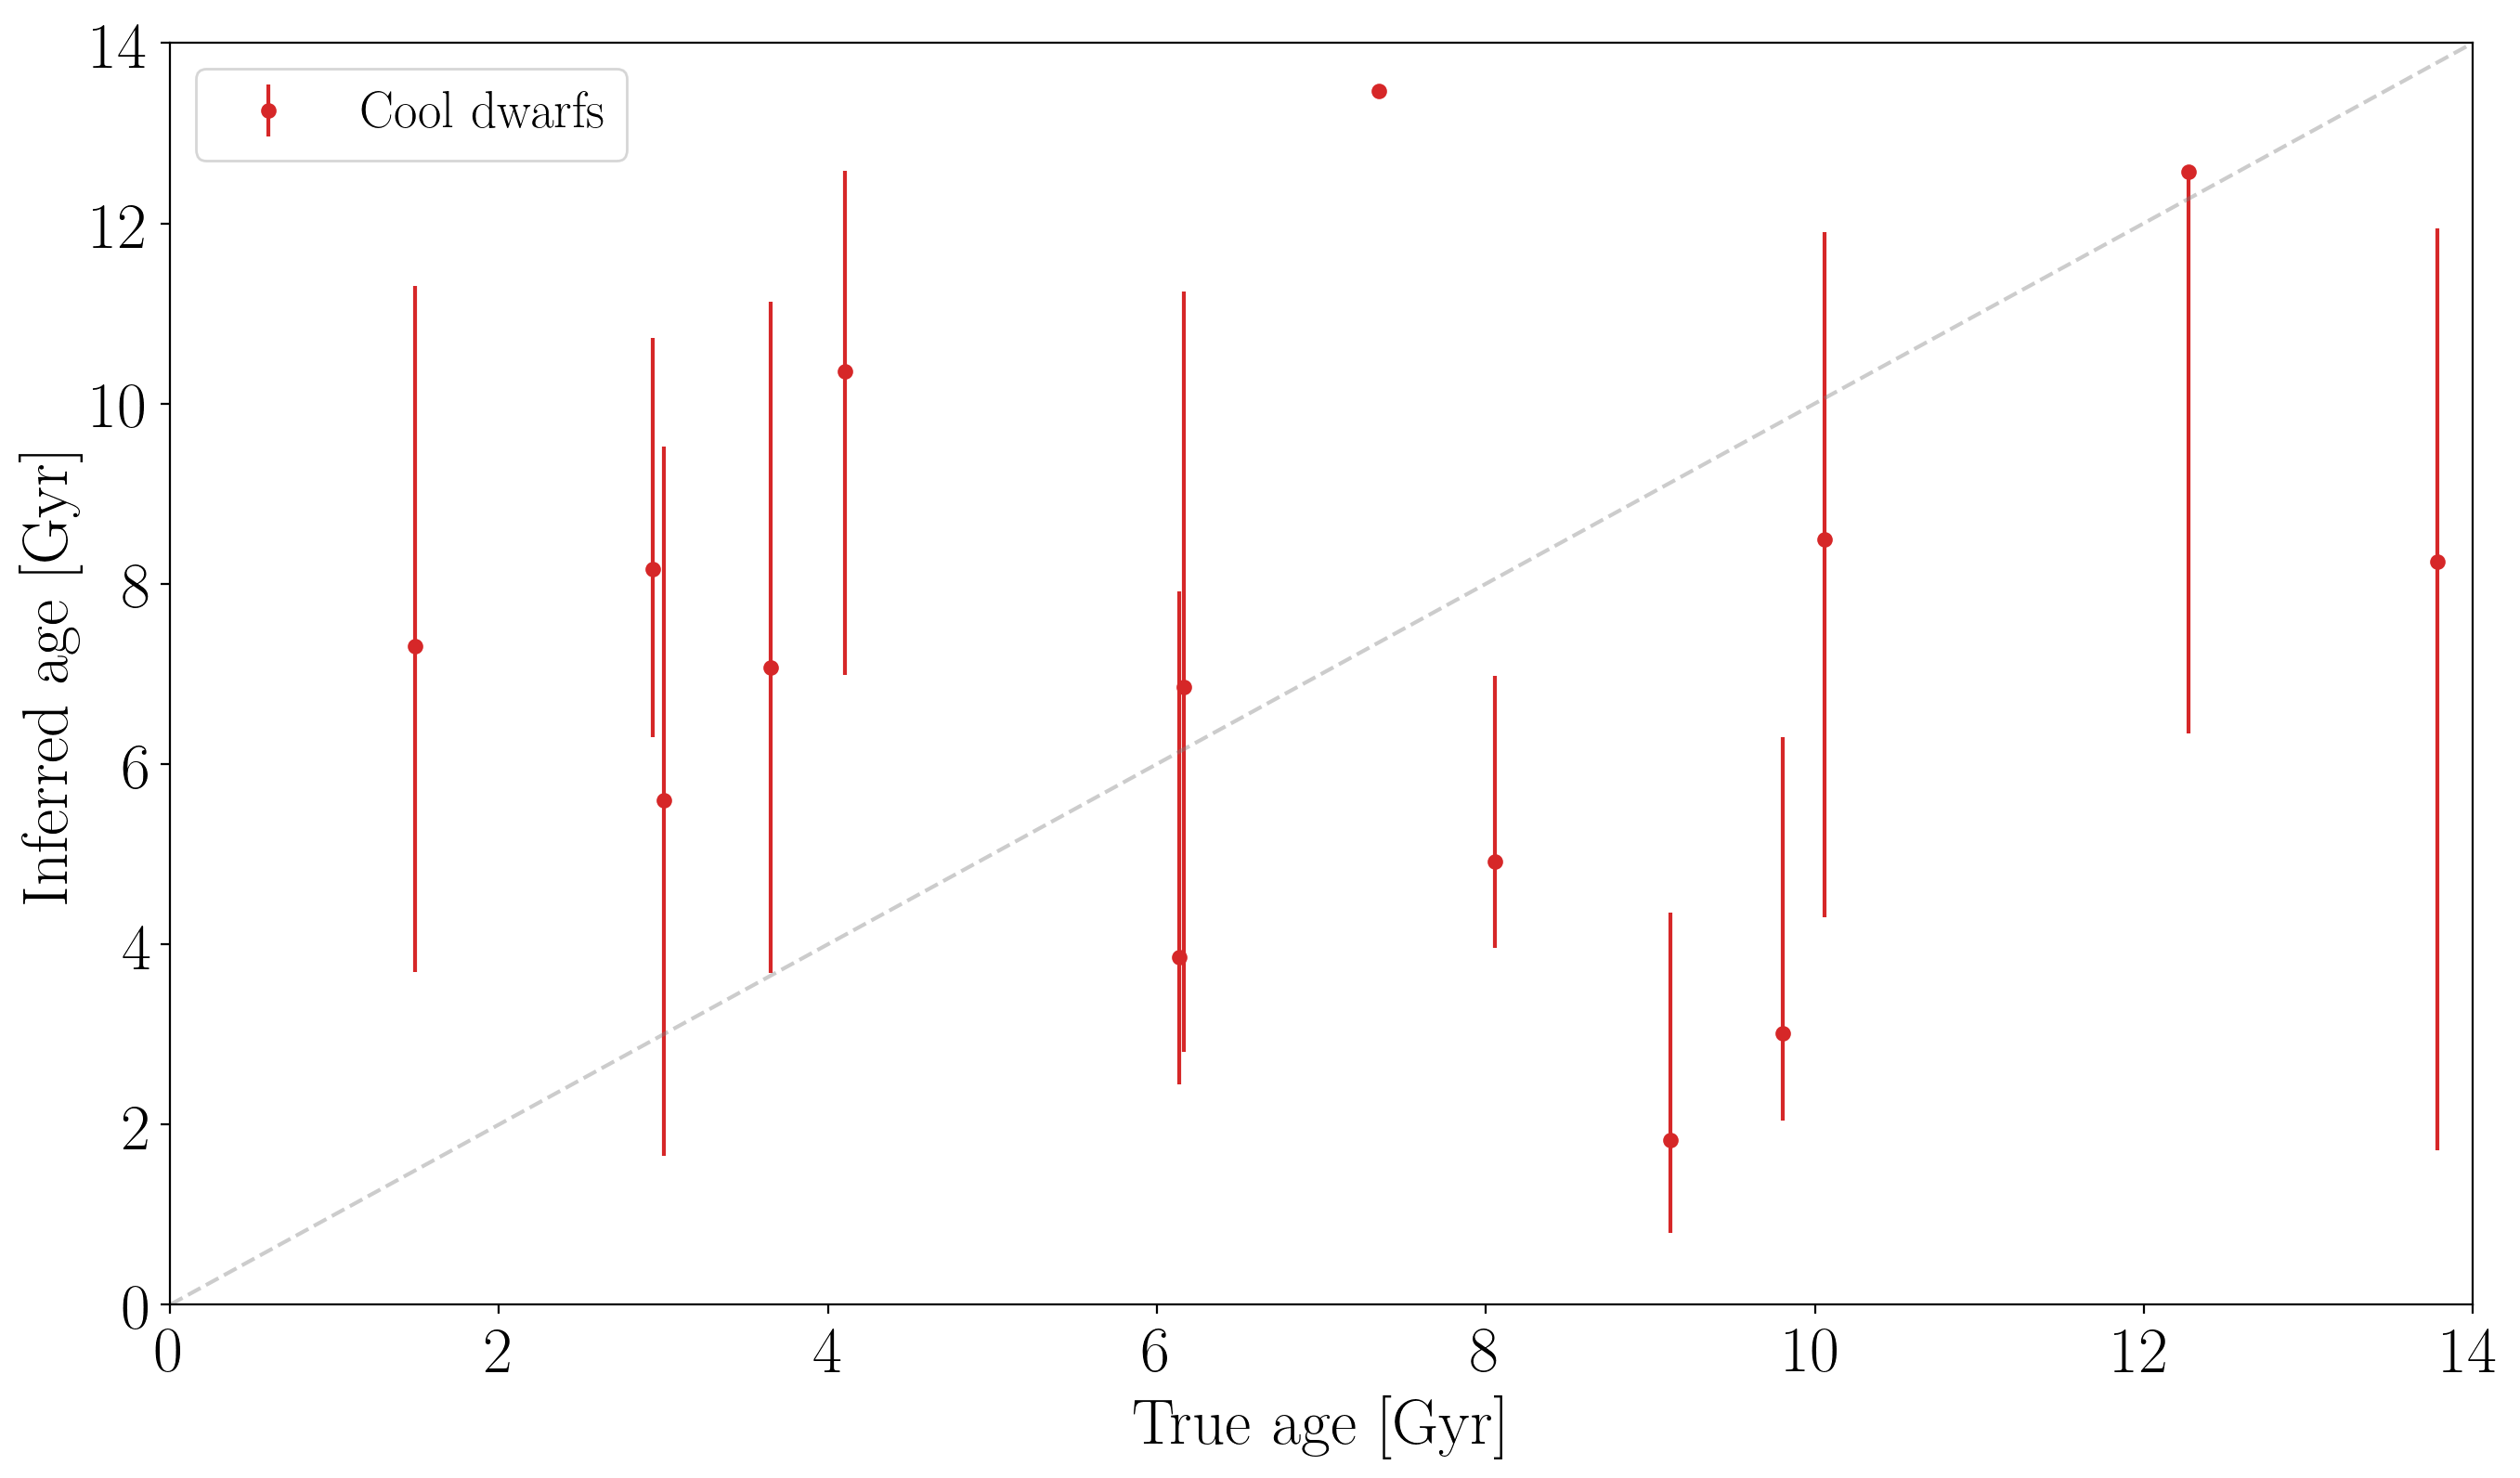

In [524]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=200)
# parts = axes.violinplot(age_samps[cool], true_age_gyr[inds][cool], points=50, widths=0.3,
#                 showmeans=False, showextrema=False, showmedians=False)
# for v in parts["bodies"]:
#     v.set_facecolor("tab:red")
#     v.set_edgecolor("tab:red")
plt.errorbar(true_age_gyr[inds][cool], meds[cool], yerr=[errm[cool], errp[cool]], fmt=".",
             color="tab:red", ms=10, zorder=2, label="$\mathrm{Cool~dwarfs}$", rasterized=True)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.legend()
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)    

(0, 14)

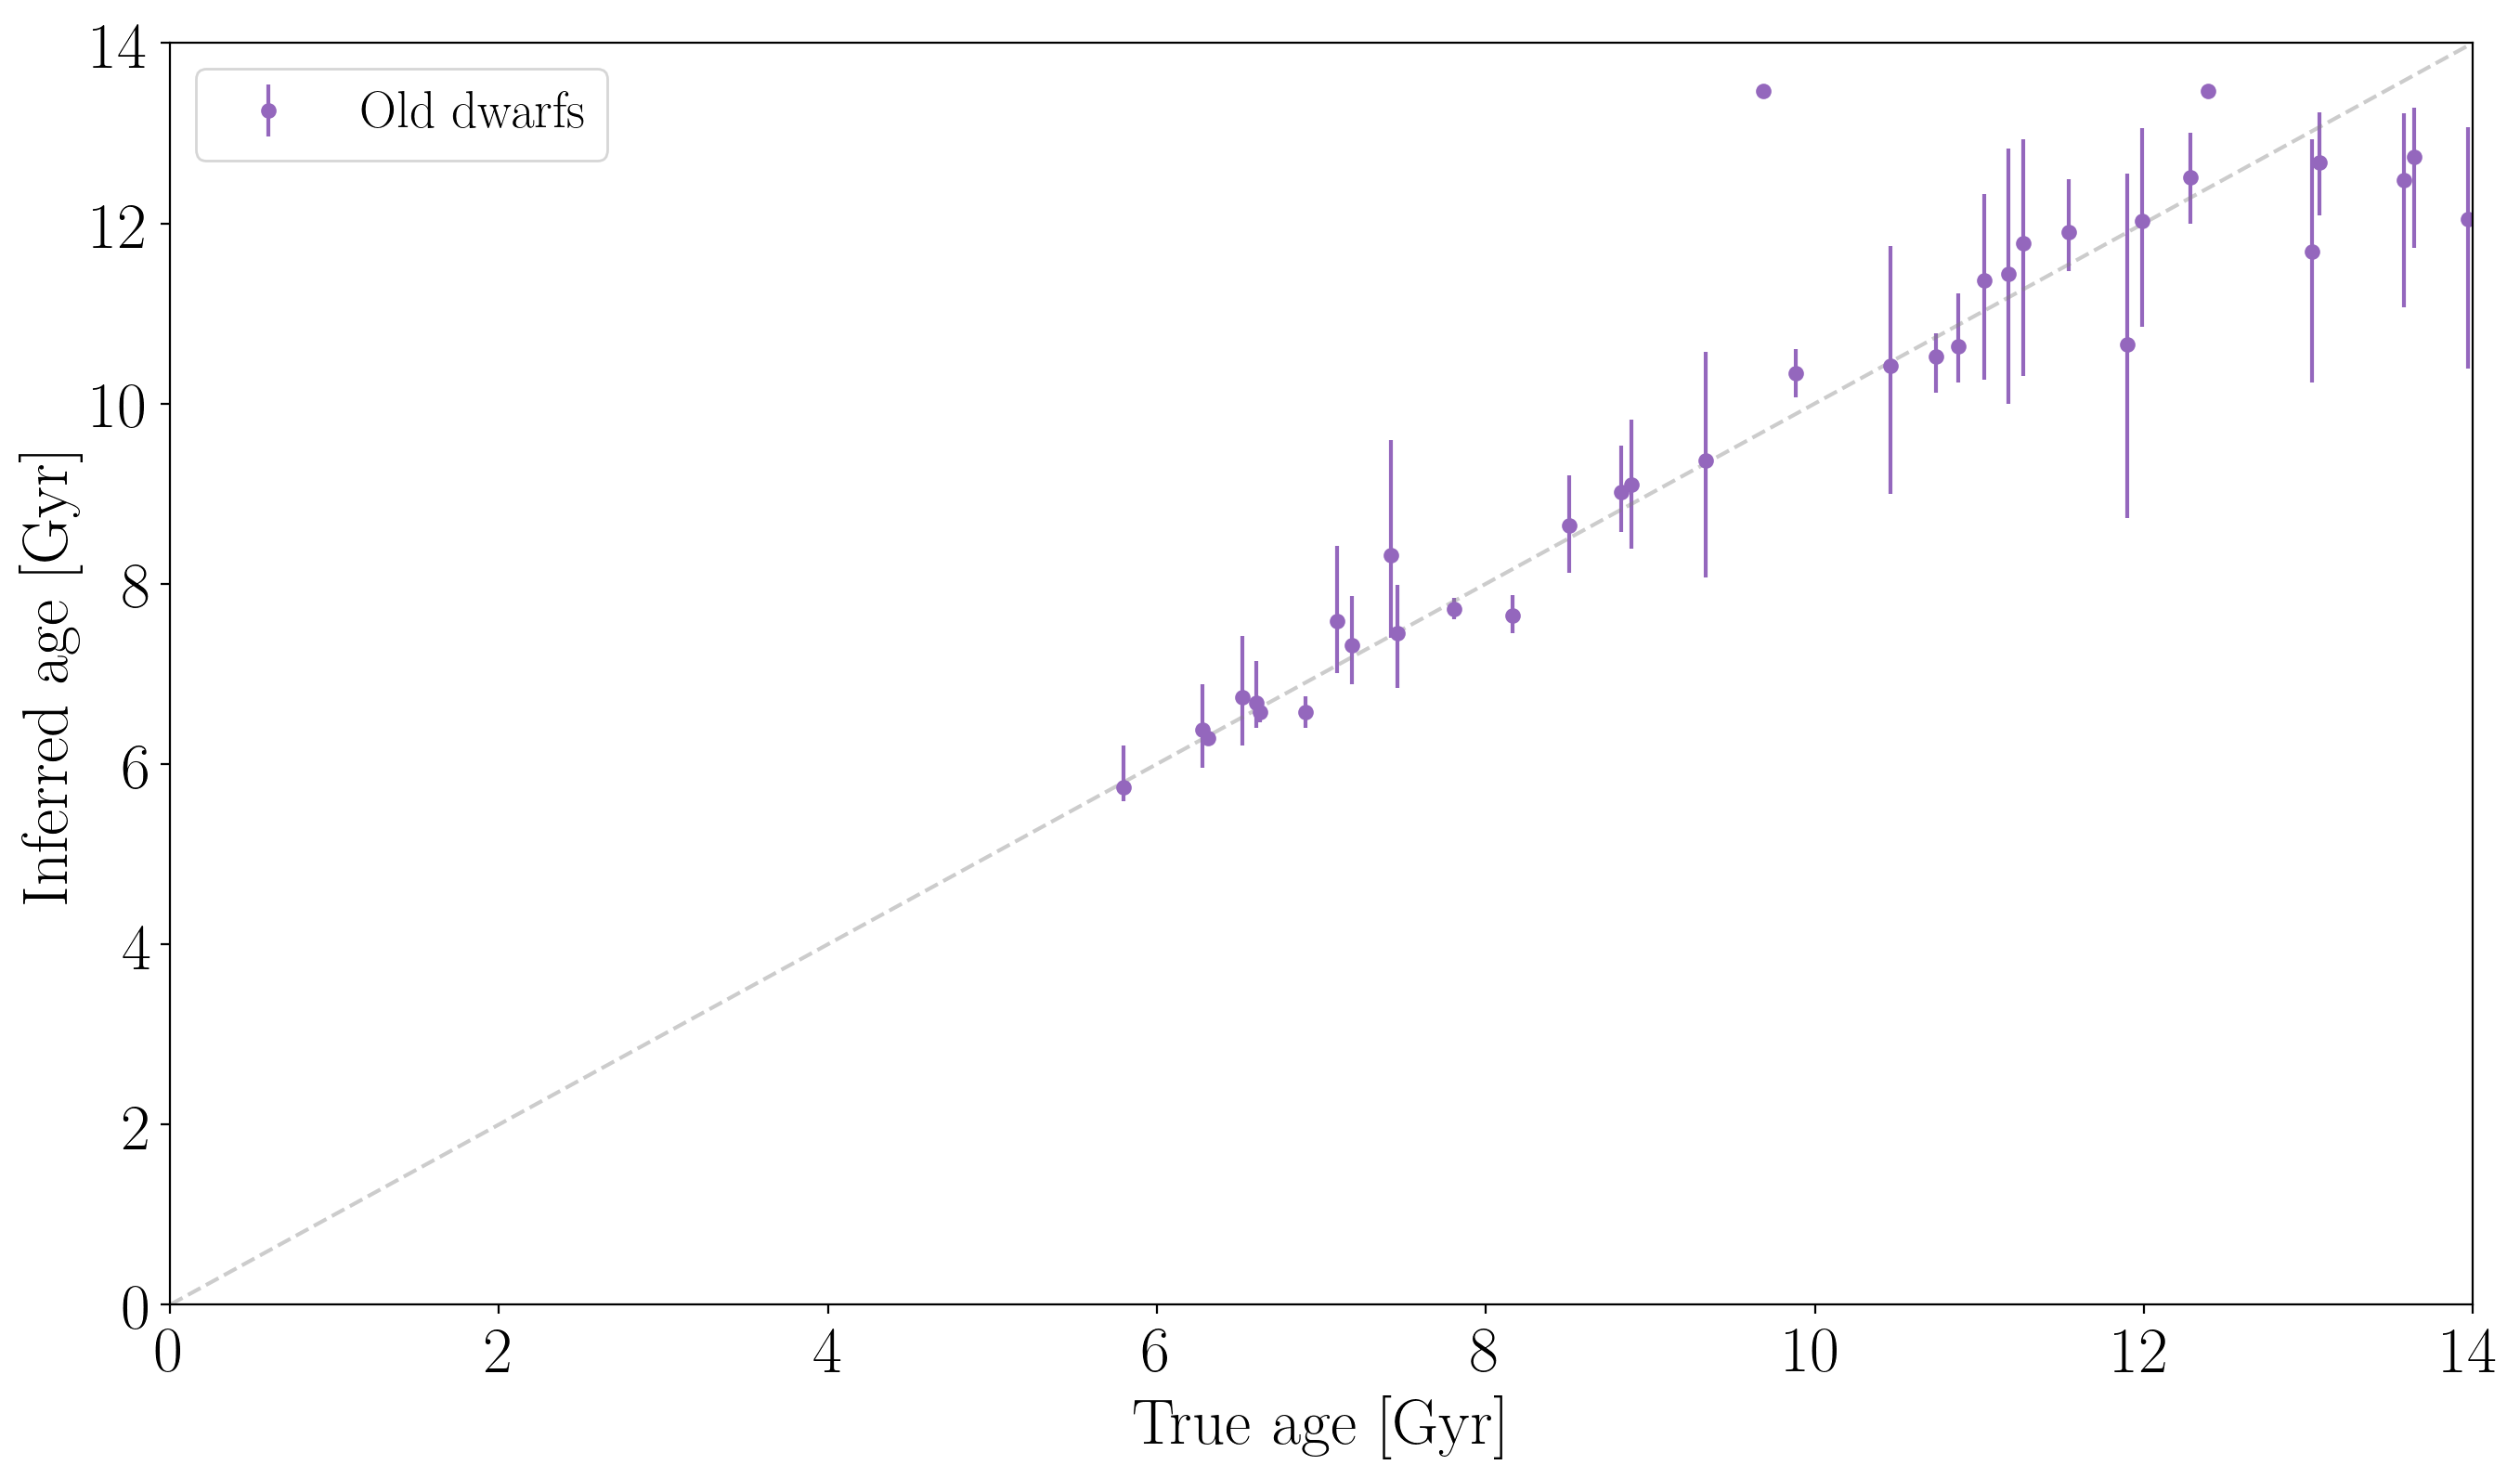

In [525]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=200)
# parts = axes.violinplot(age_samps[rossbied], true_age_gyr[inds][rossbied], points=50, widths=0.3,
#                 showmeans=False, showextrema=False, showmedians=False)
# for v in parts["bodies"]:
#     v.set_facecolor("tab:purple")
#     v.set_edgecolor("tab:purple")
plt.errorbar(true_age_gyr[inds][rossbied], meds[rossbied], yerr=[errm[rossbied], errp[rossbied]], fmt=".", 
             color="tab:purple", ms=10, zorder=2, label="$\mathrm{Old~dwarfs}$", rasterized=True)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.legend()
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)

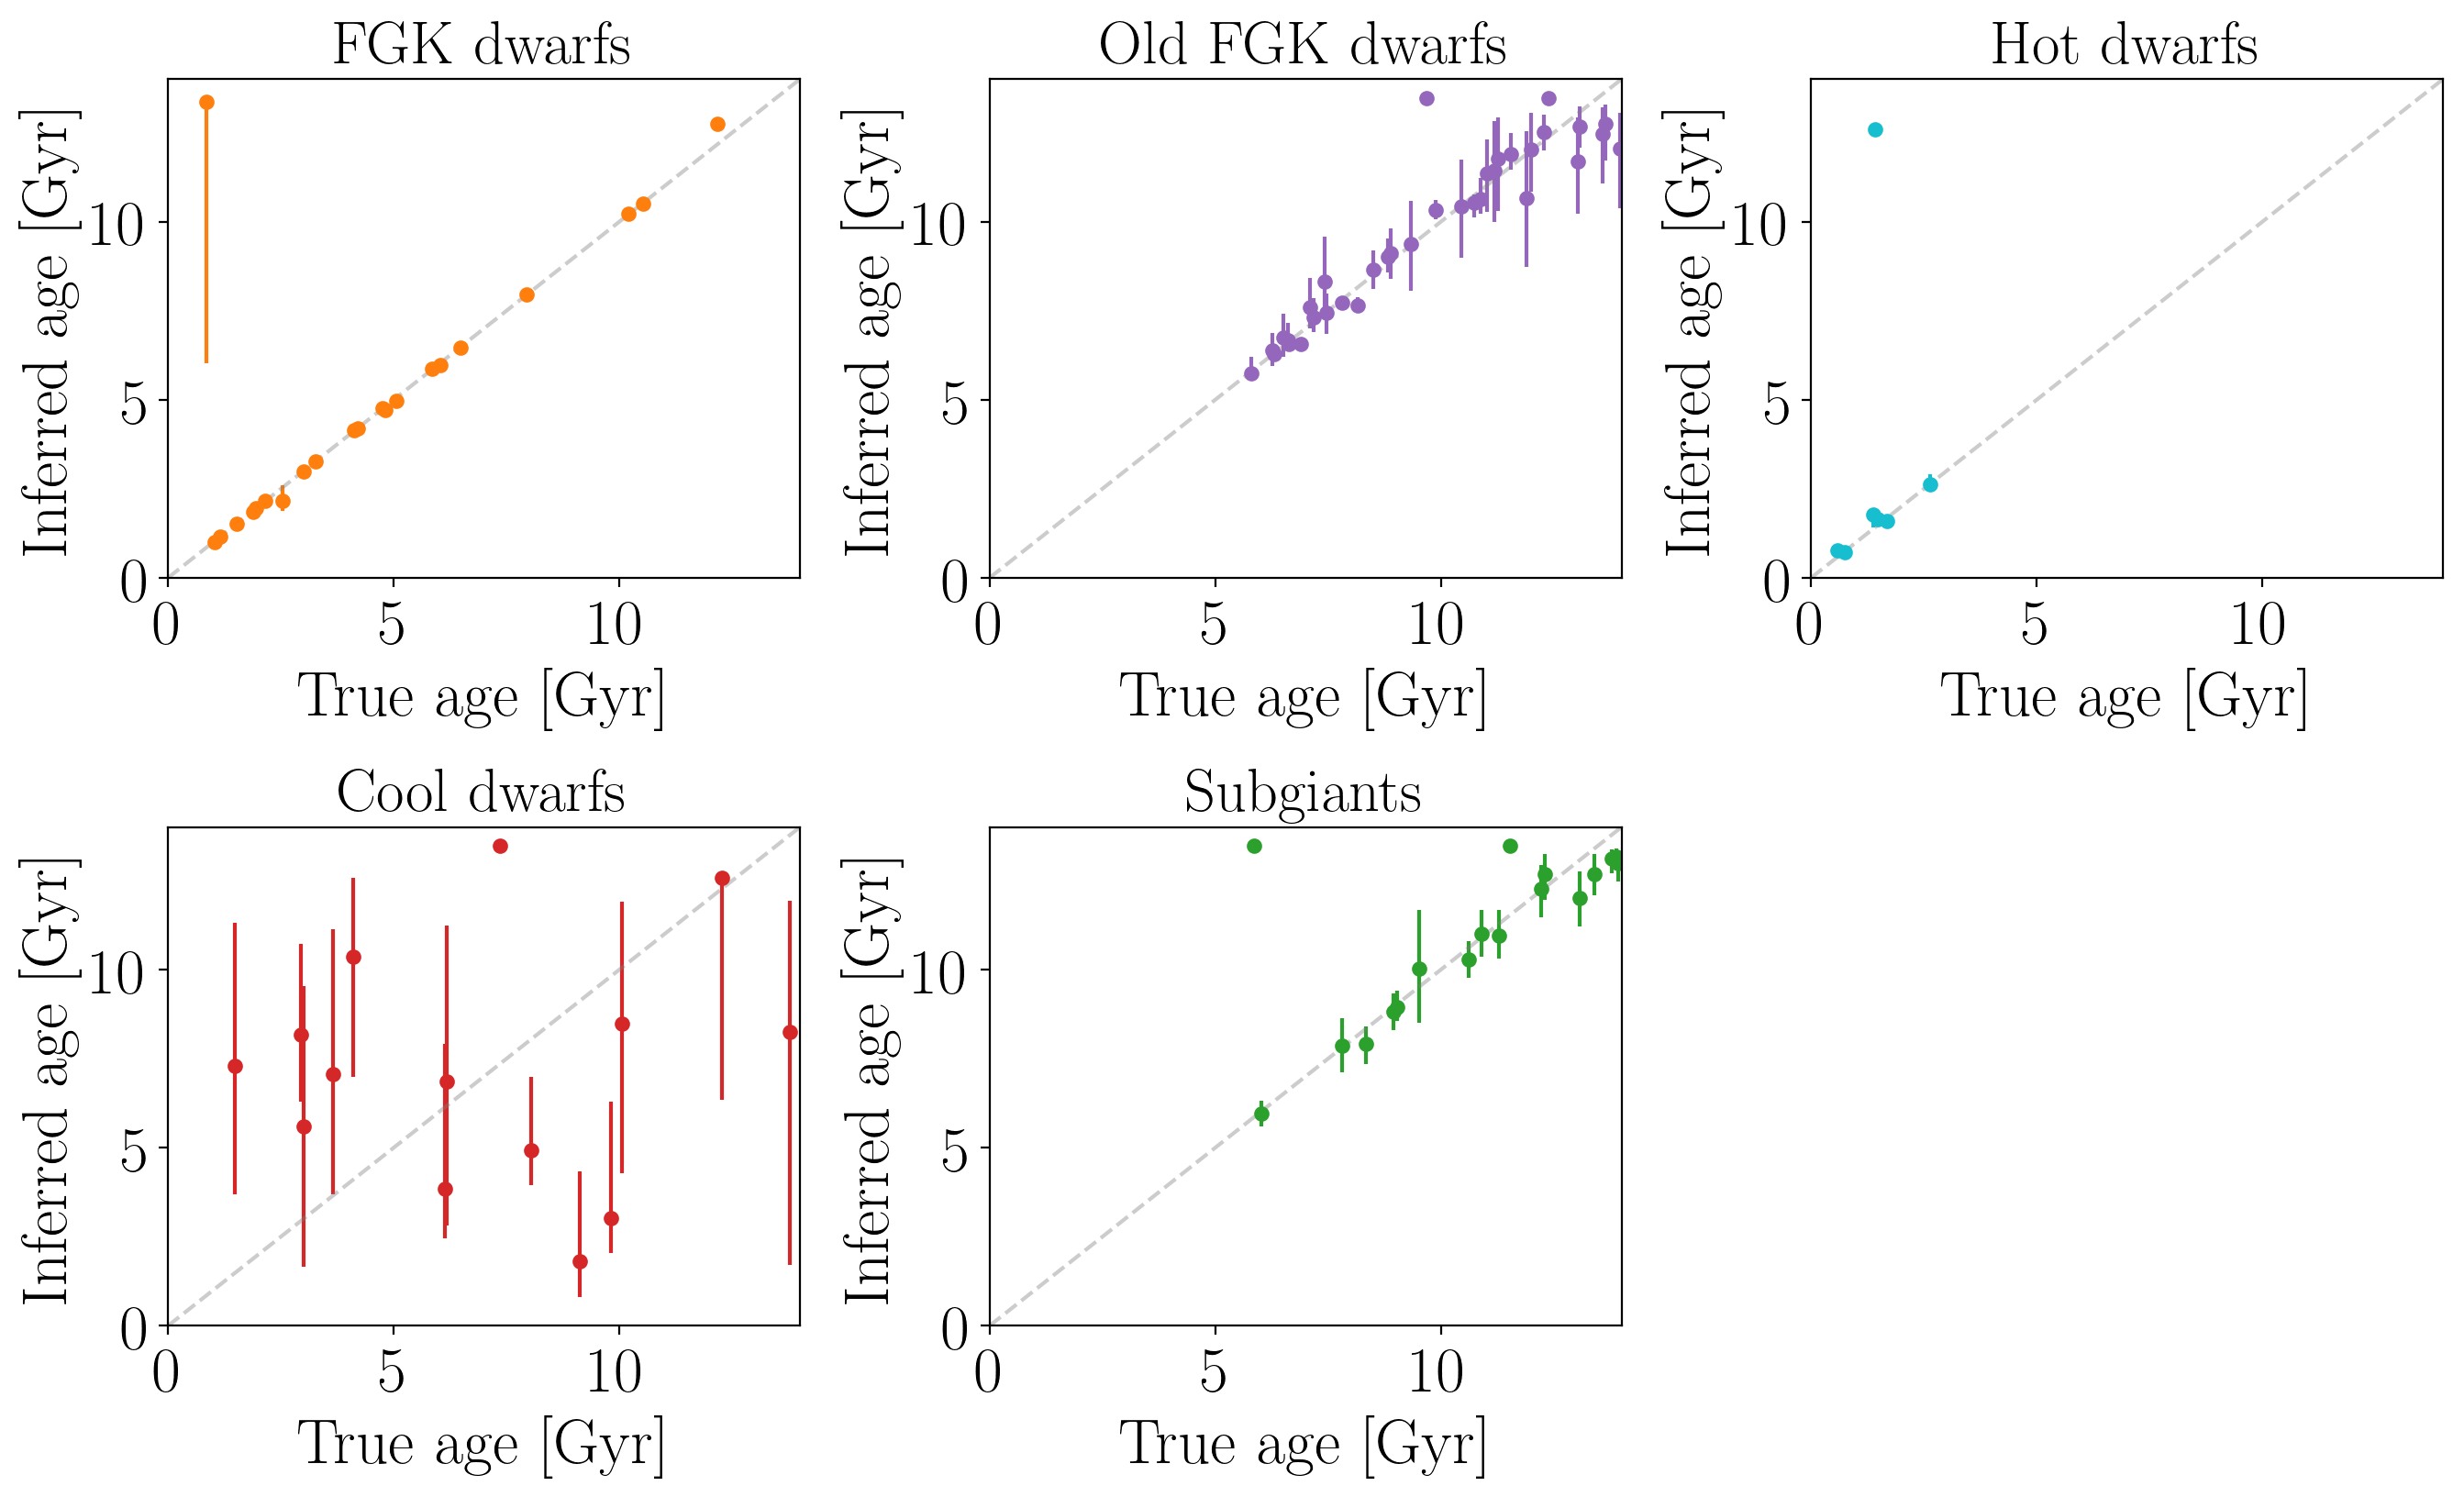

In [553]:
plt.figure(figsize=(16, 9), dpi=200)
plt.subplot(2, 3, 1)
plt.errorbar(true_age_gyr[inds][fgk], meds[fgk], yerr=[errm[fgk], errp[fgk]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{FGK~dwarfs}$", rasterized=True, color="tab:orange")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{FGK~dwarfs}$")

plt.subplot(2, 3, 2)
plt.errorbar(true_age_gyr[inds][rossbied], meds[rossbied], yerr=[errm[rossbied], errp[rossbied]], fmt=".", 
             color="tab:purple", ms=10, zorder=2, label="$\mathrm{Old~dwarfs}$", rasterized=True)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{Old~FGK~dwarfs}$")

plt.subplot(2, 3, 3)
plt.errorbar(true_age_gyr[inds][hot], meds[hot], yerr=[errm[hot], errp[hot]], fmt=".", 
             color="tab:cyan", ms=10, zorder=2, label="$\mathrm{Hot~dwarfs}$", rasterized=True)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{Hot~dwarfs}$")

plt.subplot(2, 3, 4)
plt.errorbar(true_age_gyr[inds][cool], meds[cool], yerr=[errm[cool], errp[cool]], fmt=".",
             color="tab:red", ms=10, zorder=2, label="$\mathrm{Cool~dwarfs}$", rasterized=True)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14) 
plt.title("$\mathrm{Cool~dwarfs}$")

plt.subplot(2, 3, 5)
plt.errorbar(true_age_gyr[inds][evolved], meds[evolved], yerr=[errm[evolved], errp[evolved]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{Evolved}$", rasterized=True, color="tab:green")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{Subgiants}$")

plt.subplots_adjust(wspace=.3, hspace=.5)

Precision plot

Text(0, 0.5, '$\\log(g)$')

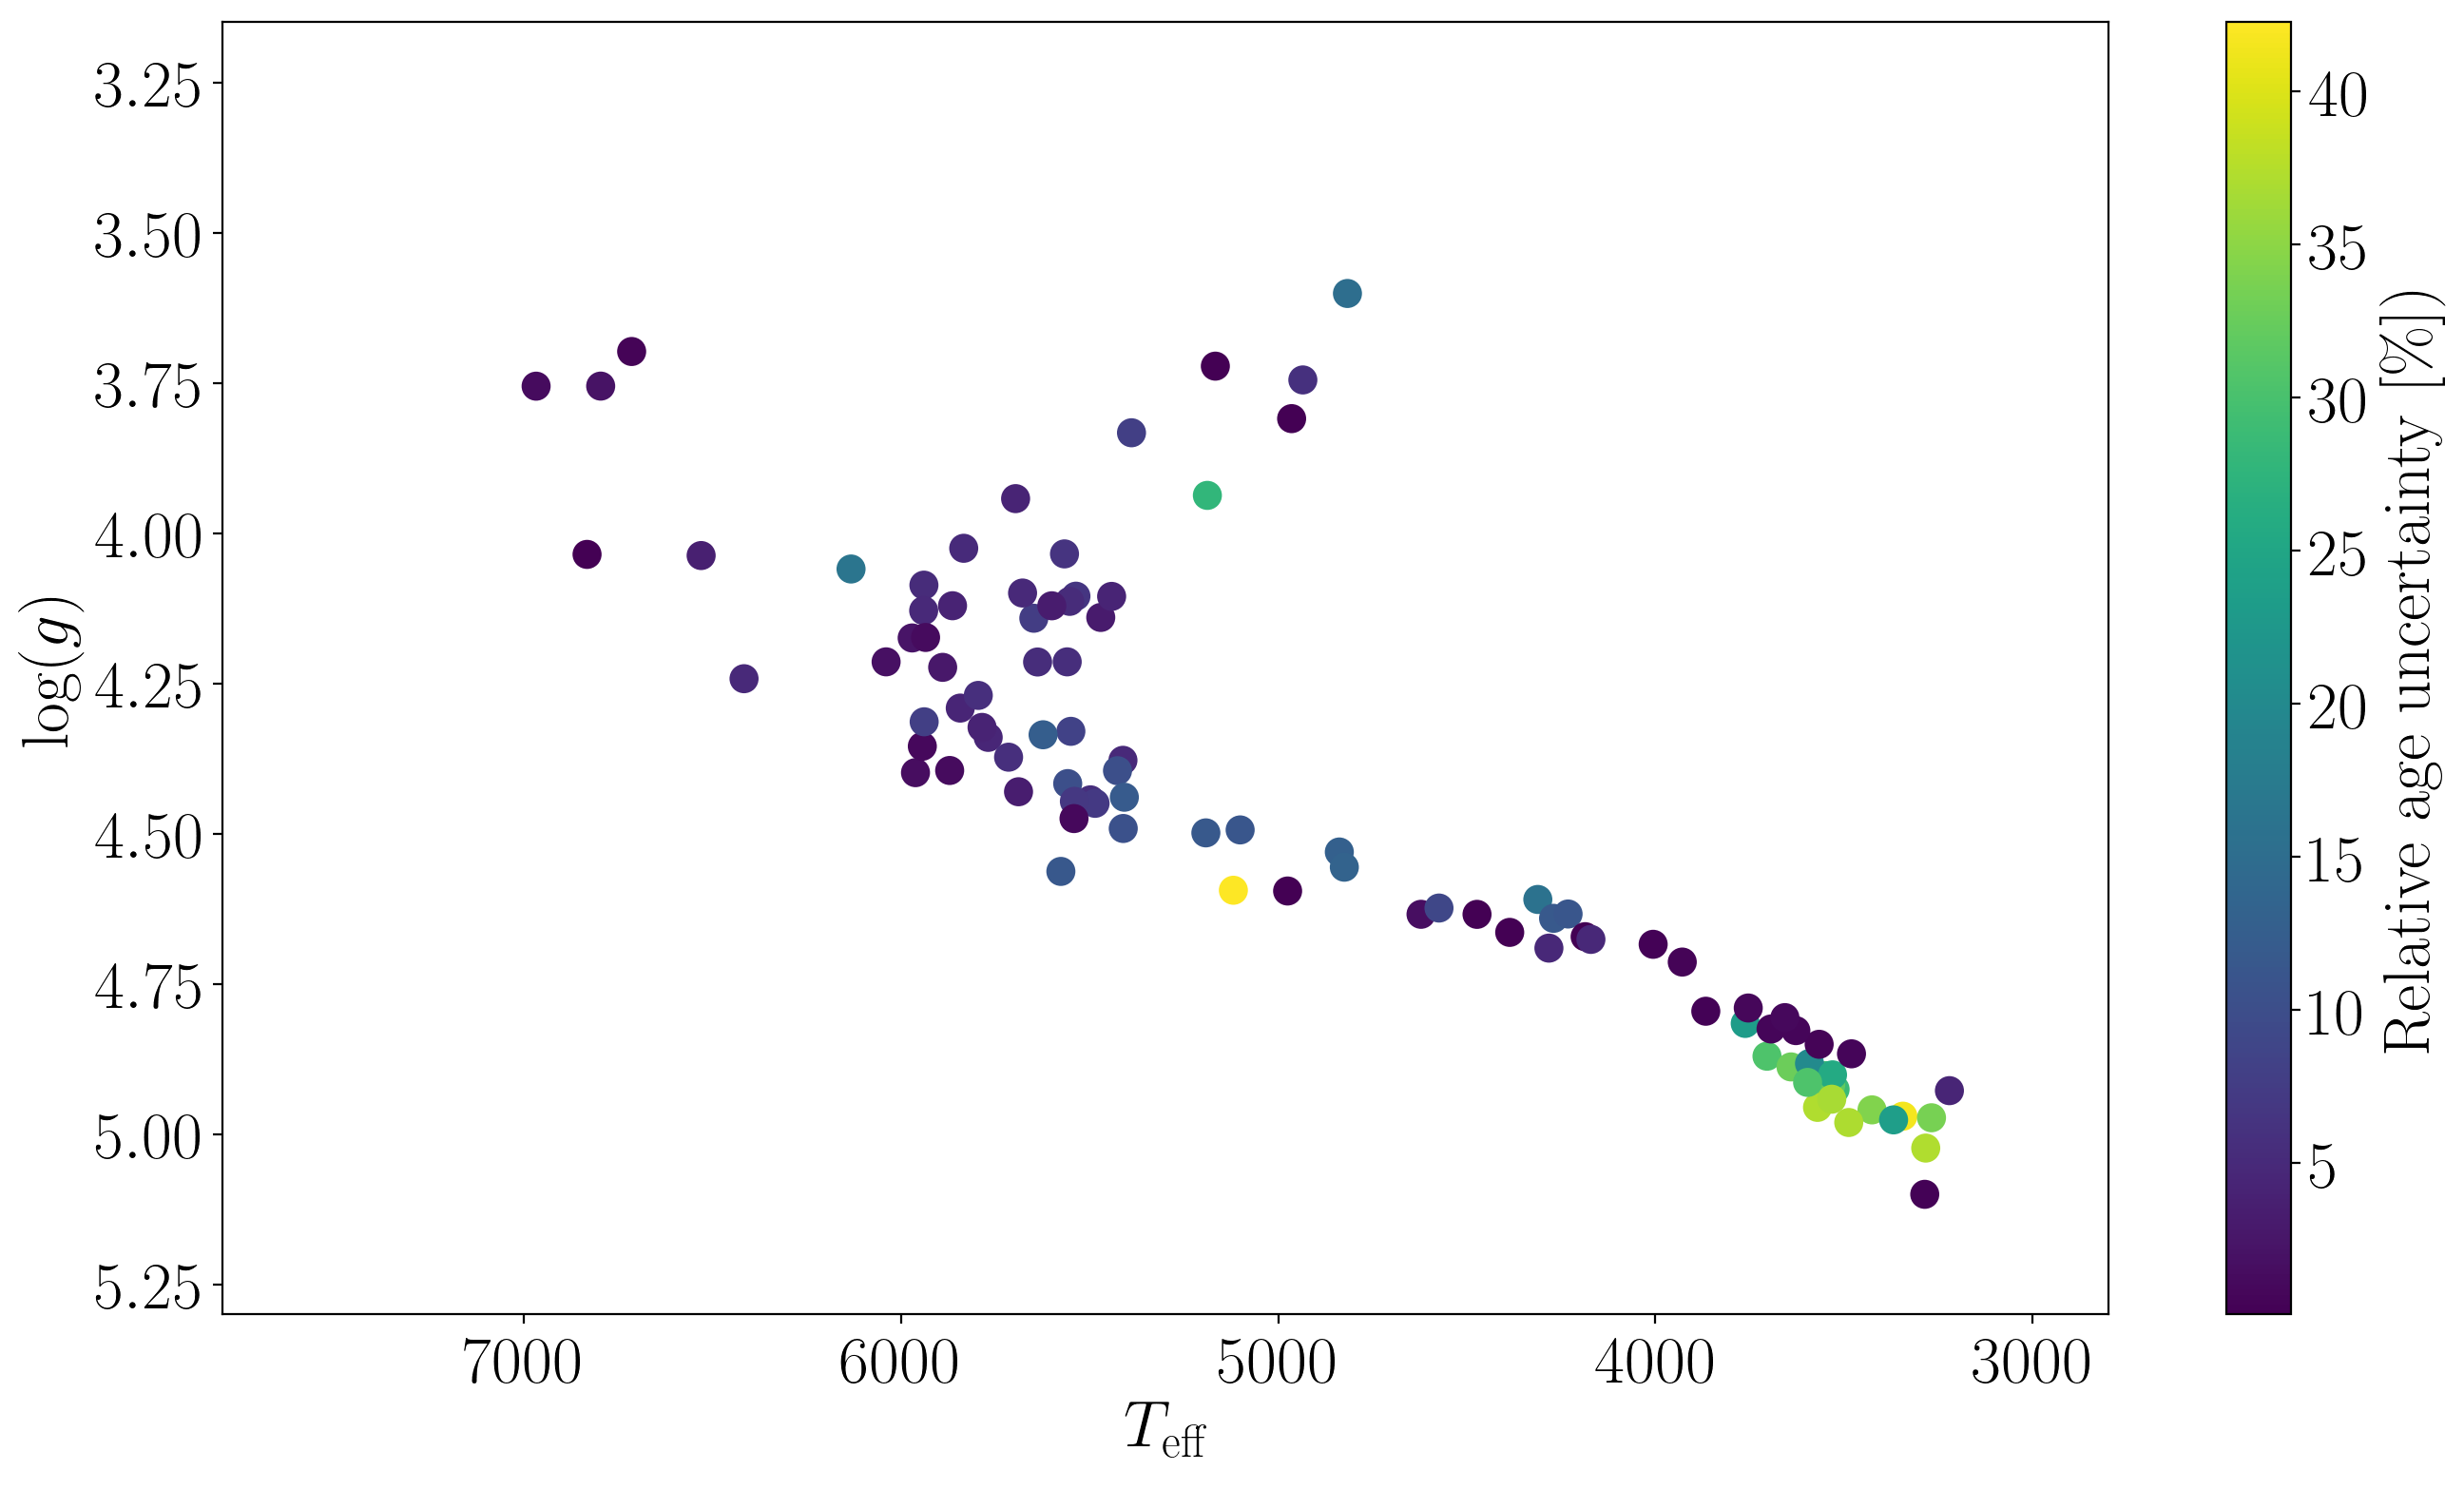

In [526]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[inds], df.logg.values[inds], c=(stds/df.age.values[inds])*100, s=100)
plt.colorbar(label="$\mathrm{Relative~age~uncertainty~[\%]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Error plot (accuracy)

Text(0, 0.5, '$\\log(g)$')

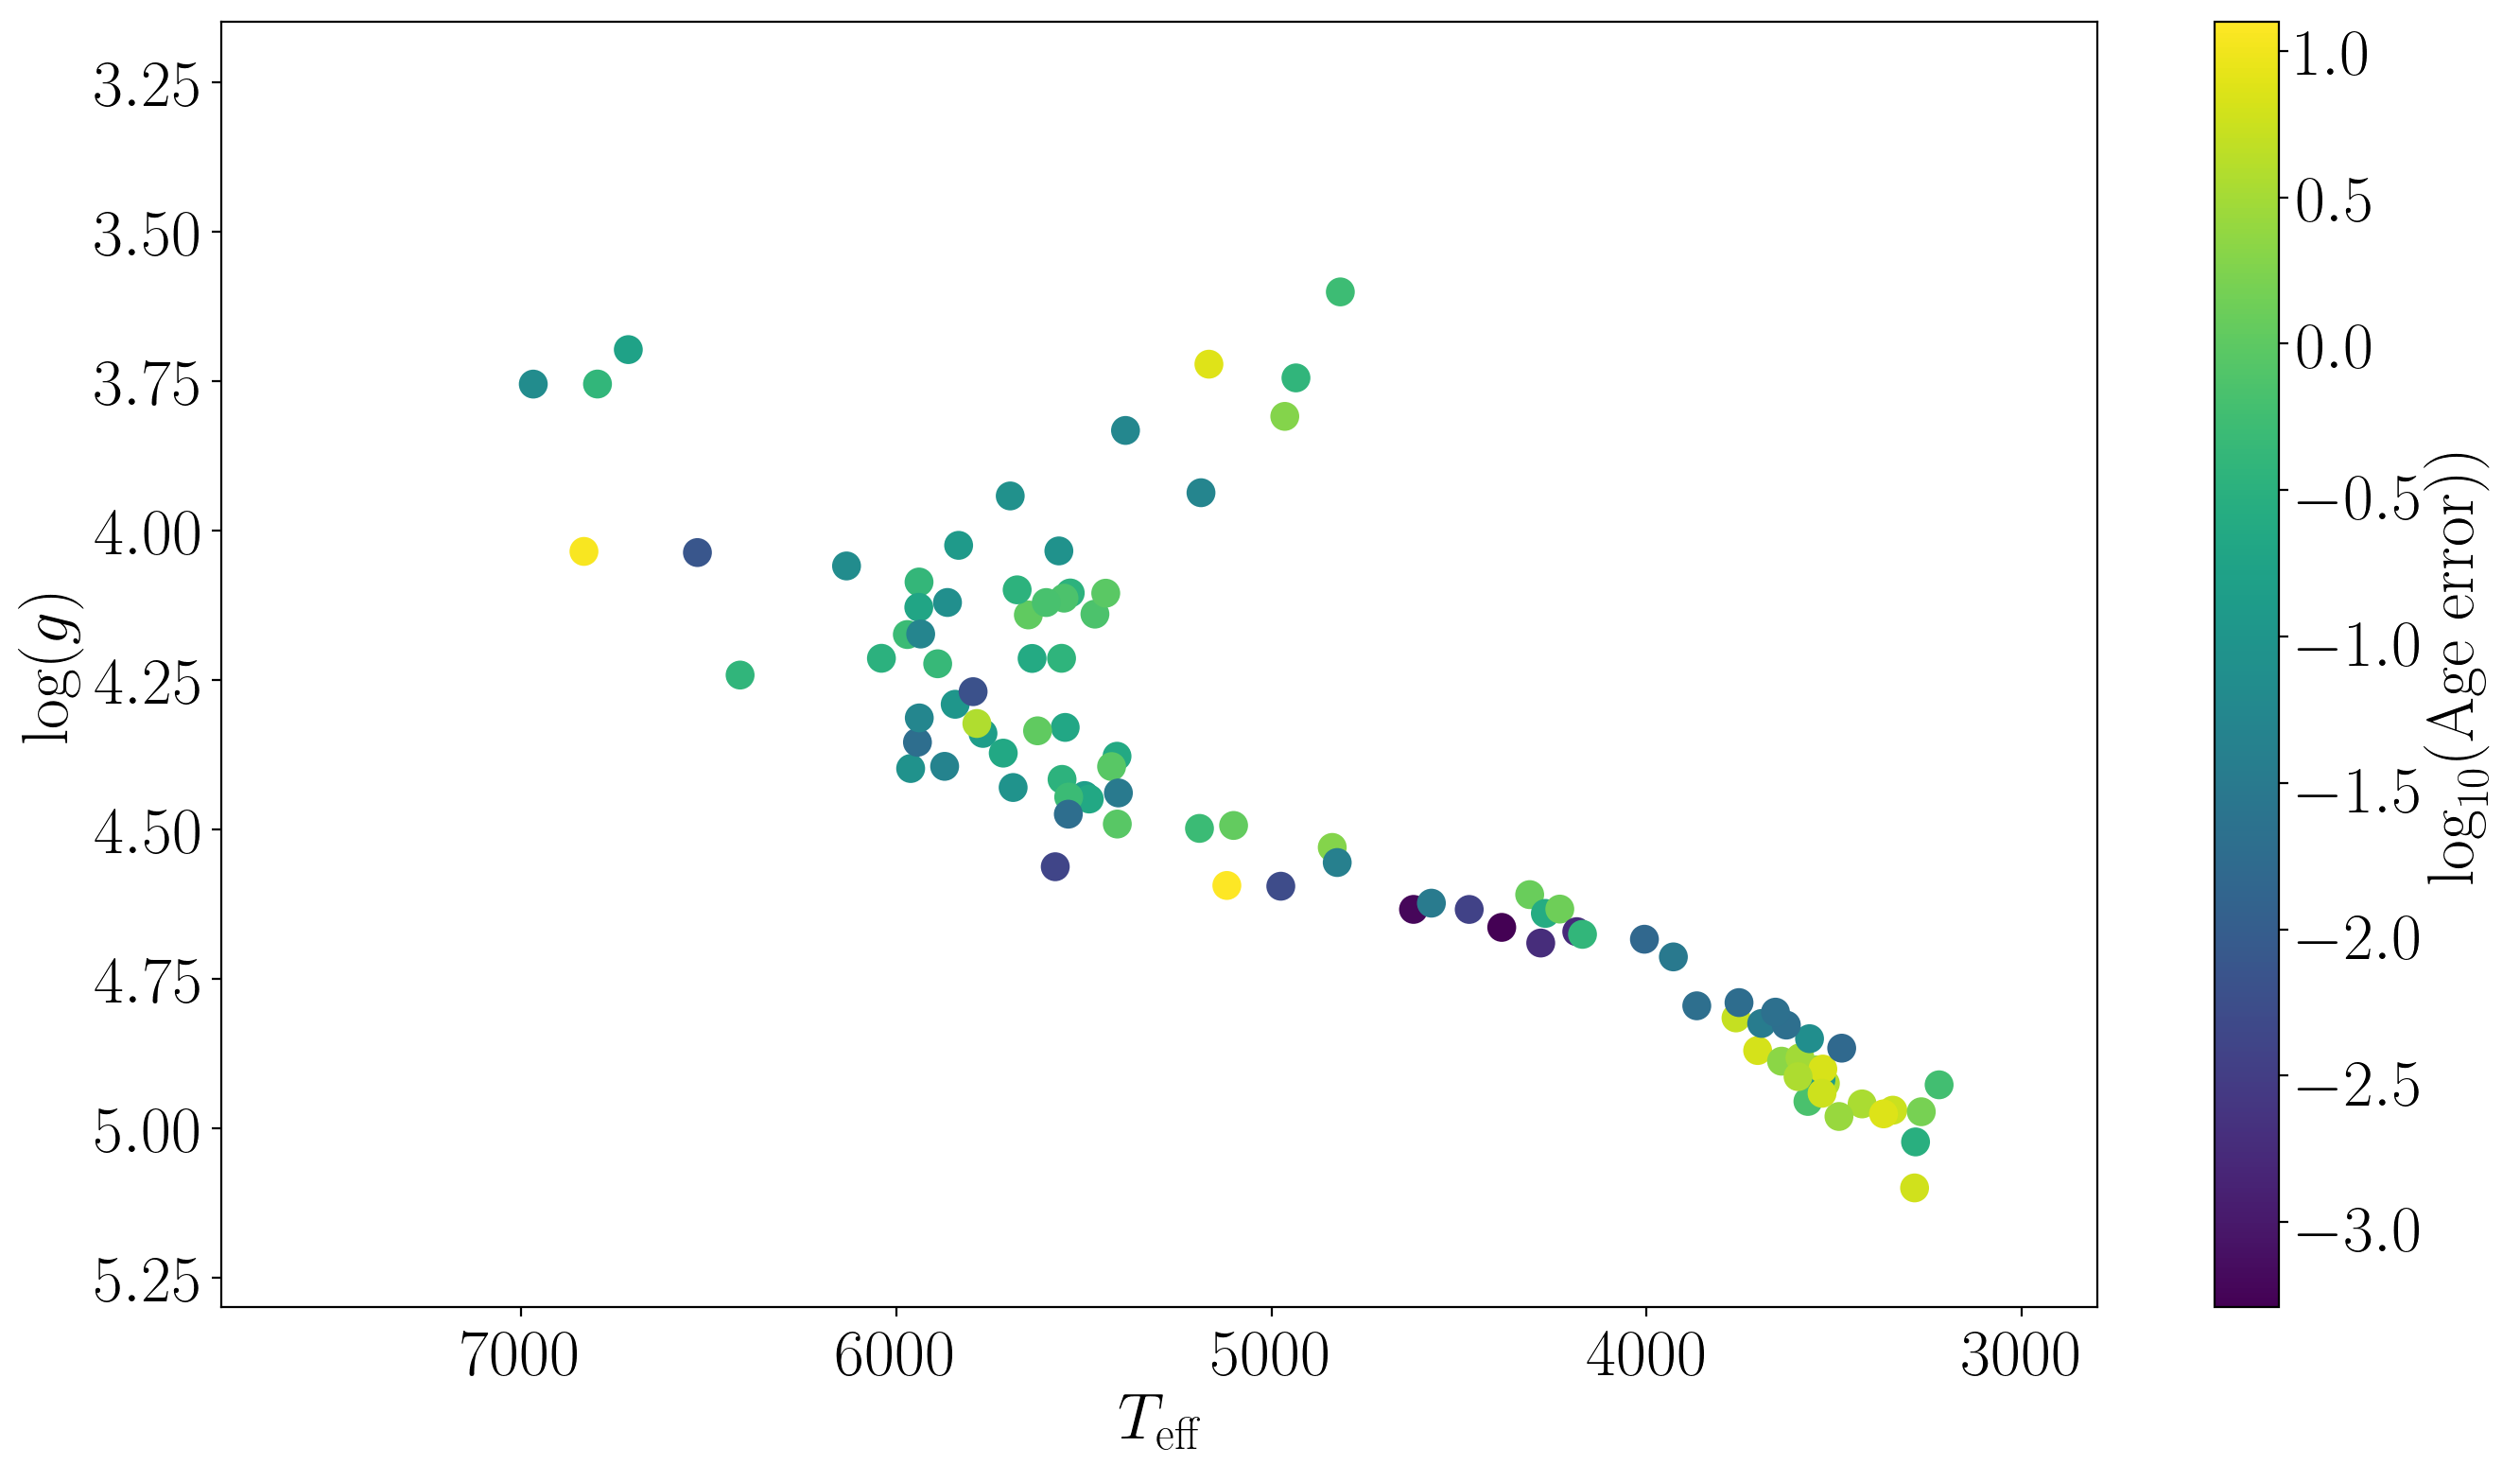

In [527]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[inds], df.logg.values[inds], 
            c=np.log10(abs(true_age_gyr[inds] - meds)), s=100)
plt.colorbar(label="$\mathrm{\log_{10}(Age~error)})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Now just the isochrone model.

In [444]:
imeds, istds, iage_samps, iresids, ierrp, ierrm = [], [], [], [], [], []
ieeps, ieep_errp, eiep_errm, iinds = [], [], [], []
iavs, iav_errp, iav_errm = [], [], []

burnin = 1

for i in range(N):
    try:
        fname = "{0}_isochrones.h5".format(str(i).zfill(4))
        reader = emcee.backends.HDFBackend(fname)
        samples = reader.get_chain()
        nsteps, nwalkers, ndim = np.shape(samples)
        samps = np.reshape(samples, (nsteps*nwalkers, ndim))

        lin_samps = (10**samps[burnin:, 1])*1e-9
        iage_samps.append(lin_samps)
        imeds.append(np.median(lin_samps))
        istds.append(np.std(lin_samps))
        upper = np.percentile(lin_samps, 84)
        lower = np.percentile(lin_samps, 16)
        ierrp.append(upper-np.median(lin_samps))
        ierrm.append(np.median(lin_samps)-lower)
    
        ieep_samps = samps[burnin:, 0]
        ieeps.append(np.median(ieep_samps))
        upper = np.percentile(ieep_samps, 84)
        lower = np.percentile(ieep_samps, 16)
        ieep_errp.append(upper-np.median(ieep_samps))
        ieep_errm.append(np.median(ieep_samps)-lower)
        
        iav_samps = samps[burnin:, 4]
        iavs.append(np.median(iav_samps))
        upper = np.percentile(iav_samps, 84)
        lower = np.percentile(iav_samps, 16)
        iav_errp.append(upper-np.median(iav_samps))
        iav_errm.append(np.median(iav_samps)-lower)
        
        iinds.append(i)
        
    except AttributeError:
        pass

In [445]:
imeds, istds, ierrp, ierrm = np.array(imeds), np.array(istds), np.array(ierrp), np.array(ierrm)
print(len(iinds))

104


In [558]:
ifgk, ihot, icool, ievolved, irossbied = selection(df, iinds)

(0, 14)

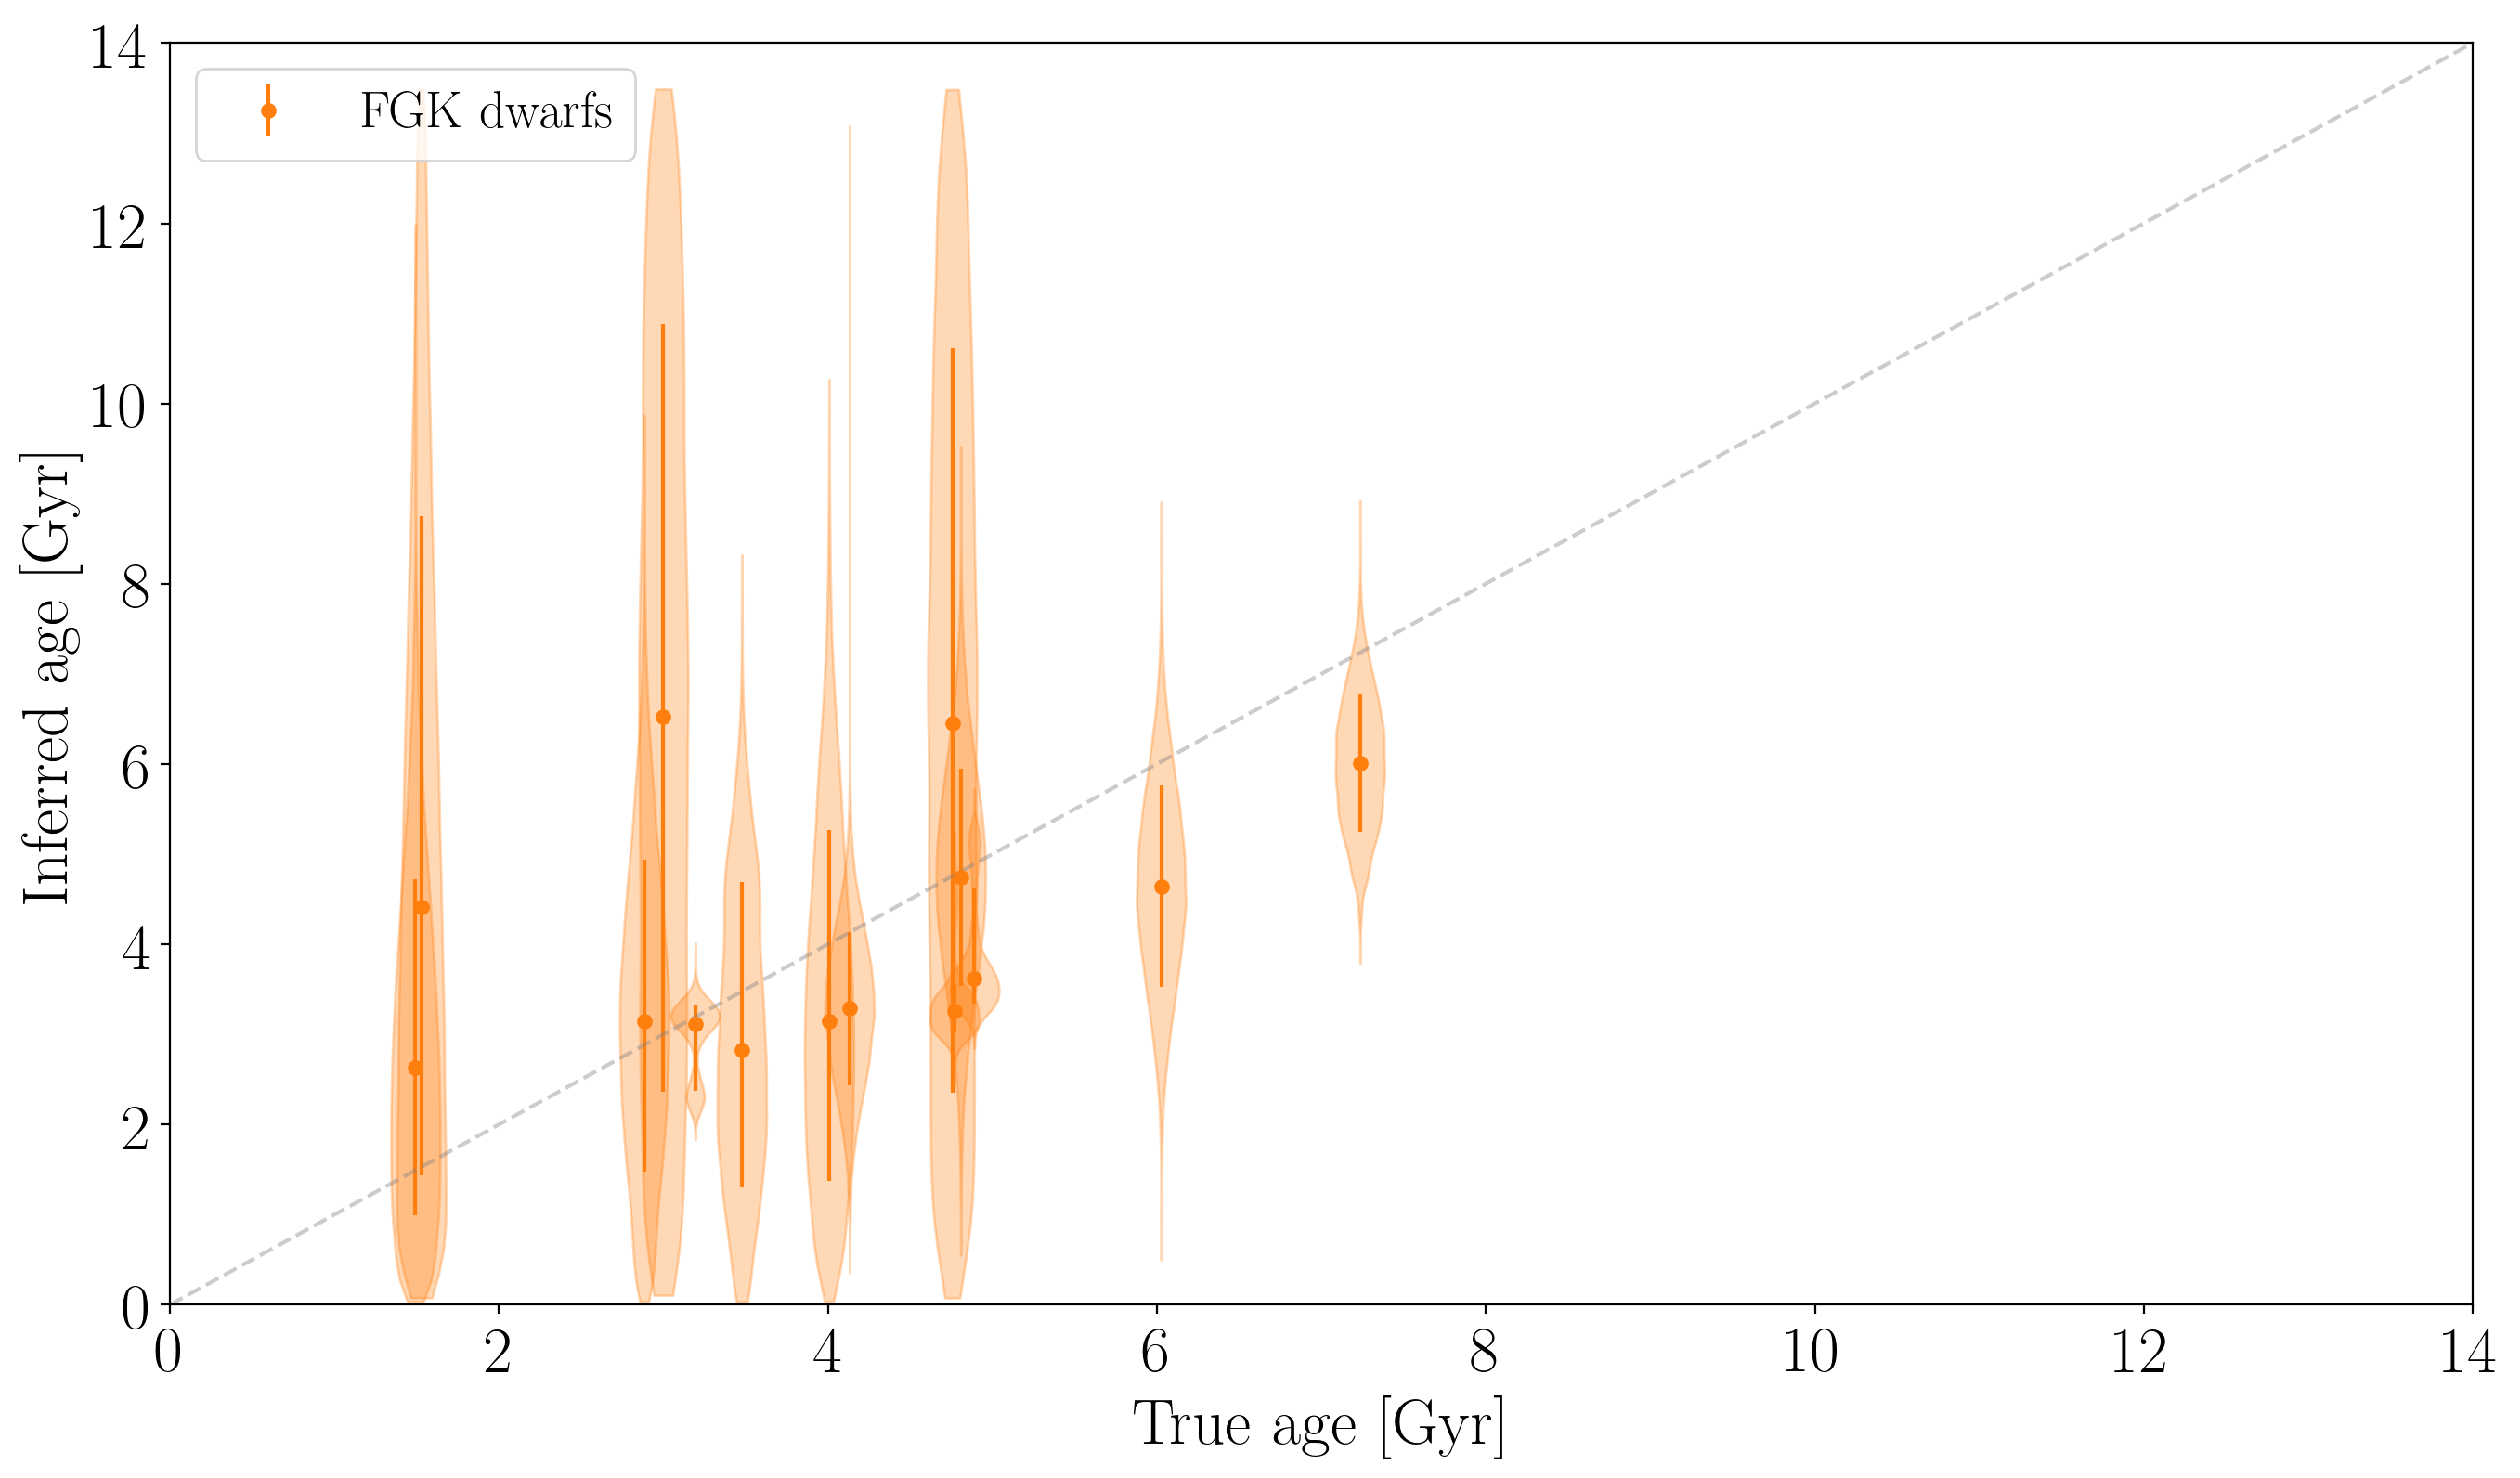

In [447]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=200)
iage_samps = np.array(iage_samps)
parts = axes.violinplot(iage_samps[ifgk], true_age_gyr[iinds][ifgk], points=50, widths=0.3,
                showmeans=False, showextrema=False, showmedians=False)
for v in parts["bodies"]:
    v.set_facecolor("tab:orange")
    v.set_edgecolor("tab:orange")
plt.errorbar(true_age_gyr[iinds][ifgk], imeds[ifgk], yerr=[ierrm[ifgk], ierrp[ifgk]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{FGK~dwarfs}$", rasterized=True, color="tab:orange")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.legend()
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)

(0, 14)

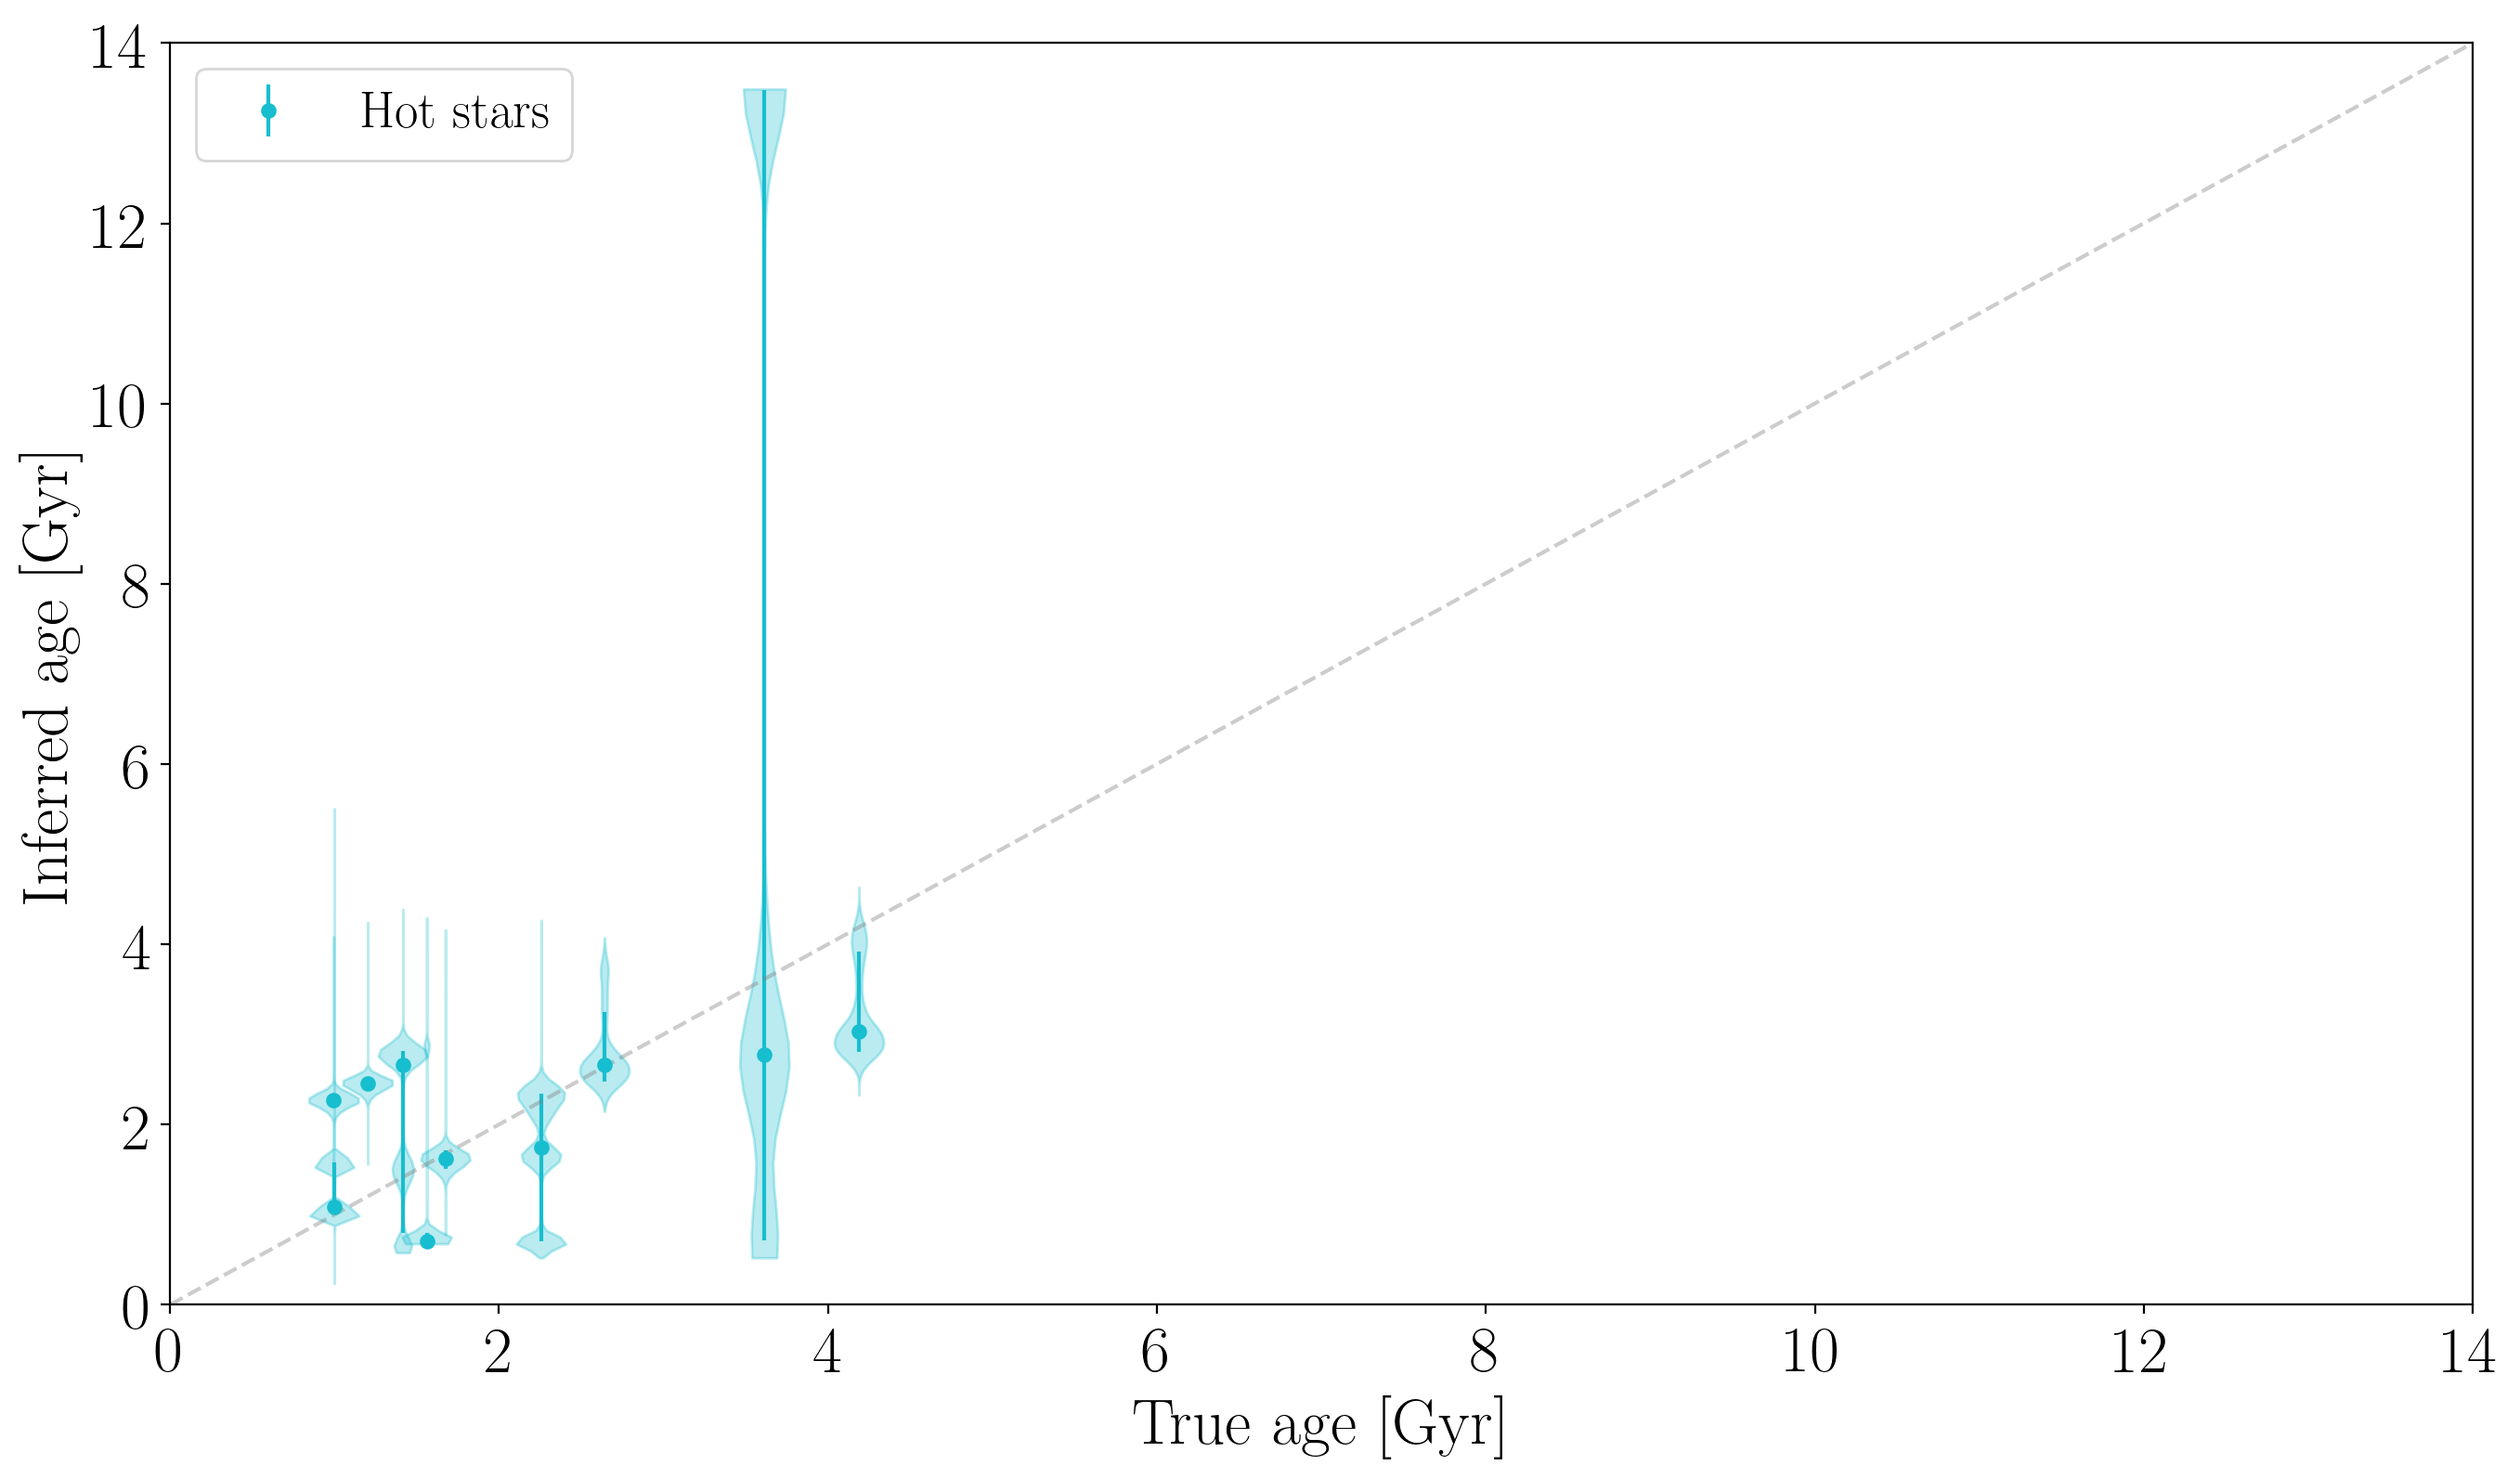

In [385]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=200)
iage_samps = np.array(iage_samps)
parts = axes.violinplot(iage_samps[ihot], true_age_gyr[iinds][ihot], points=50, widths=0.3,
                showmeans=False, showextrema=False, showmedians=False)
for v in parts["bodies"]:
    v.set_facecolor("tab:cyan")
    v.set_edgecolor("tab:cyan")
plt.errorbar(true_age_gyr[iinds][ihot], imeds[ihot], yerr=[ierrm[ihot], ierrp[ihot]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{Hot~stars}$", rasterized=True, color="tab:cyan")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.legend()
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)

(0, 14)

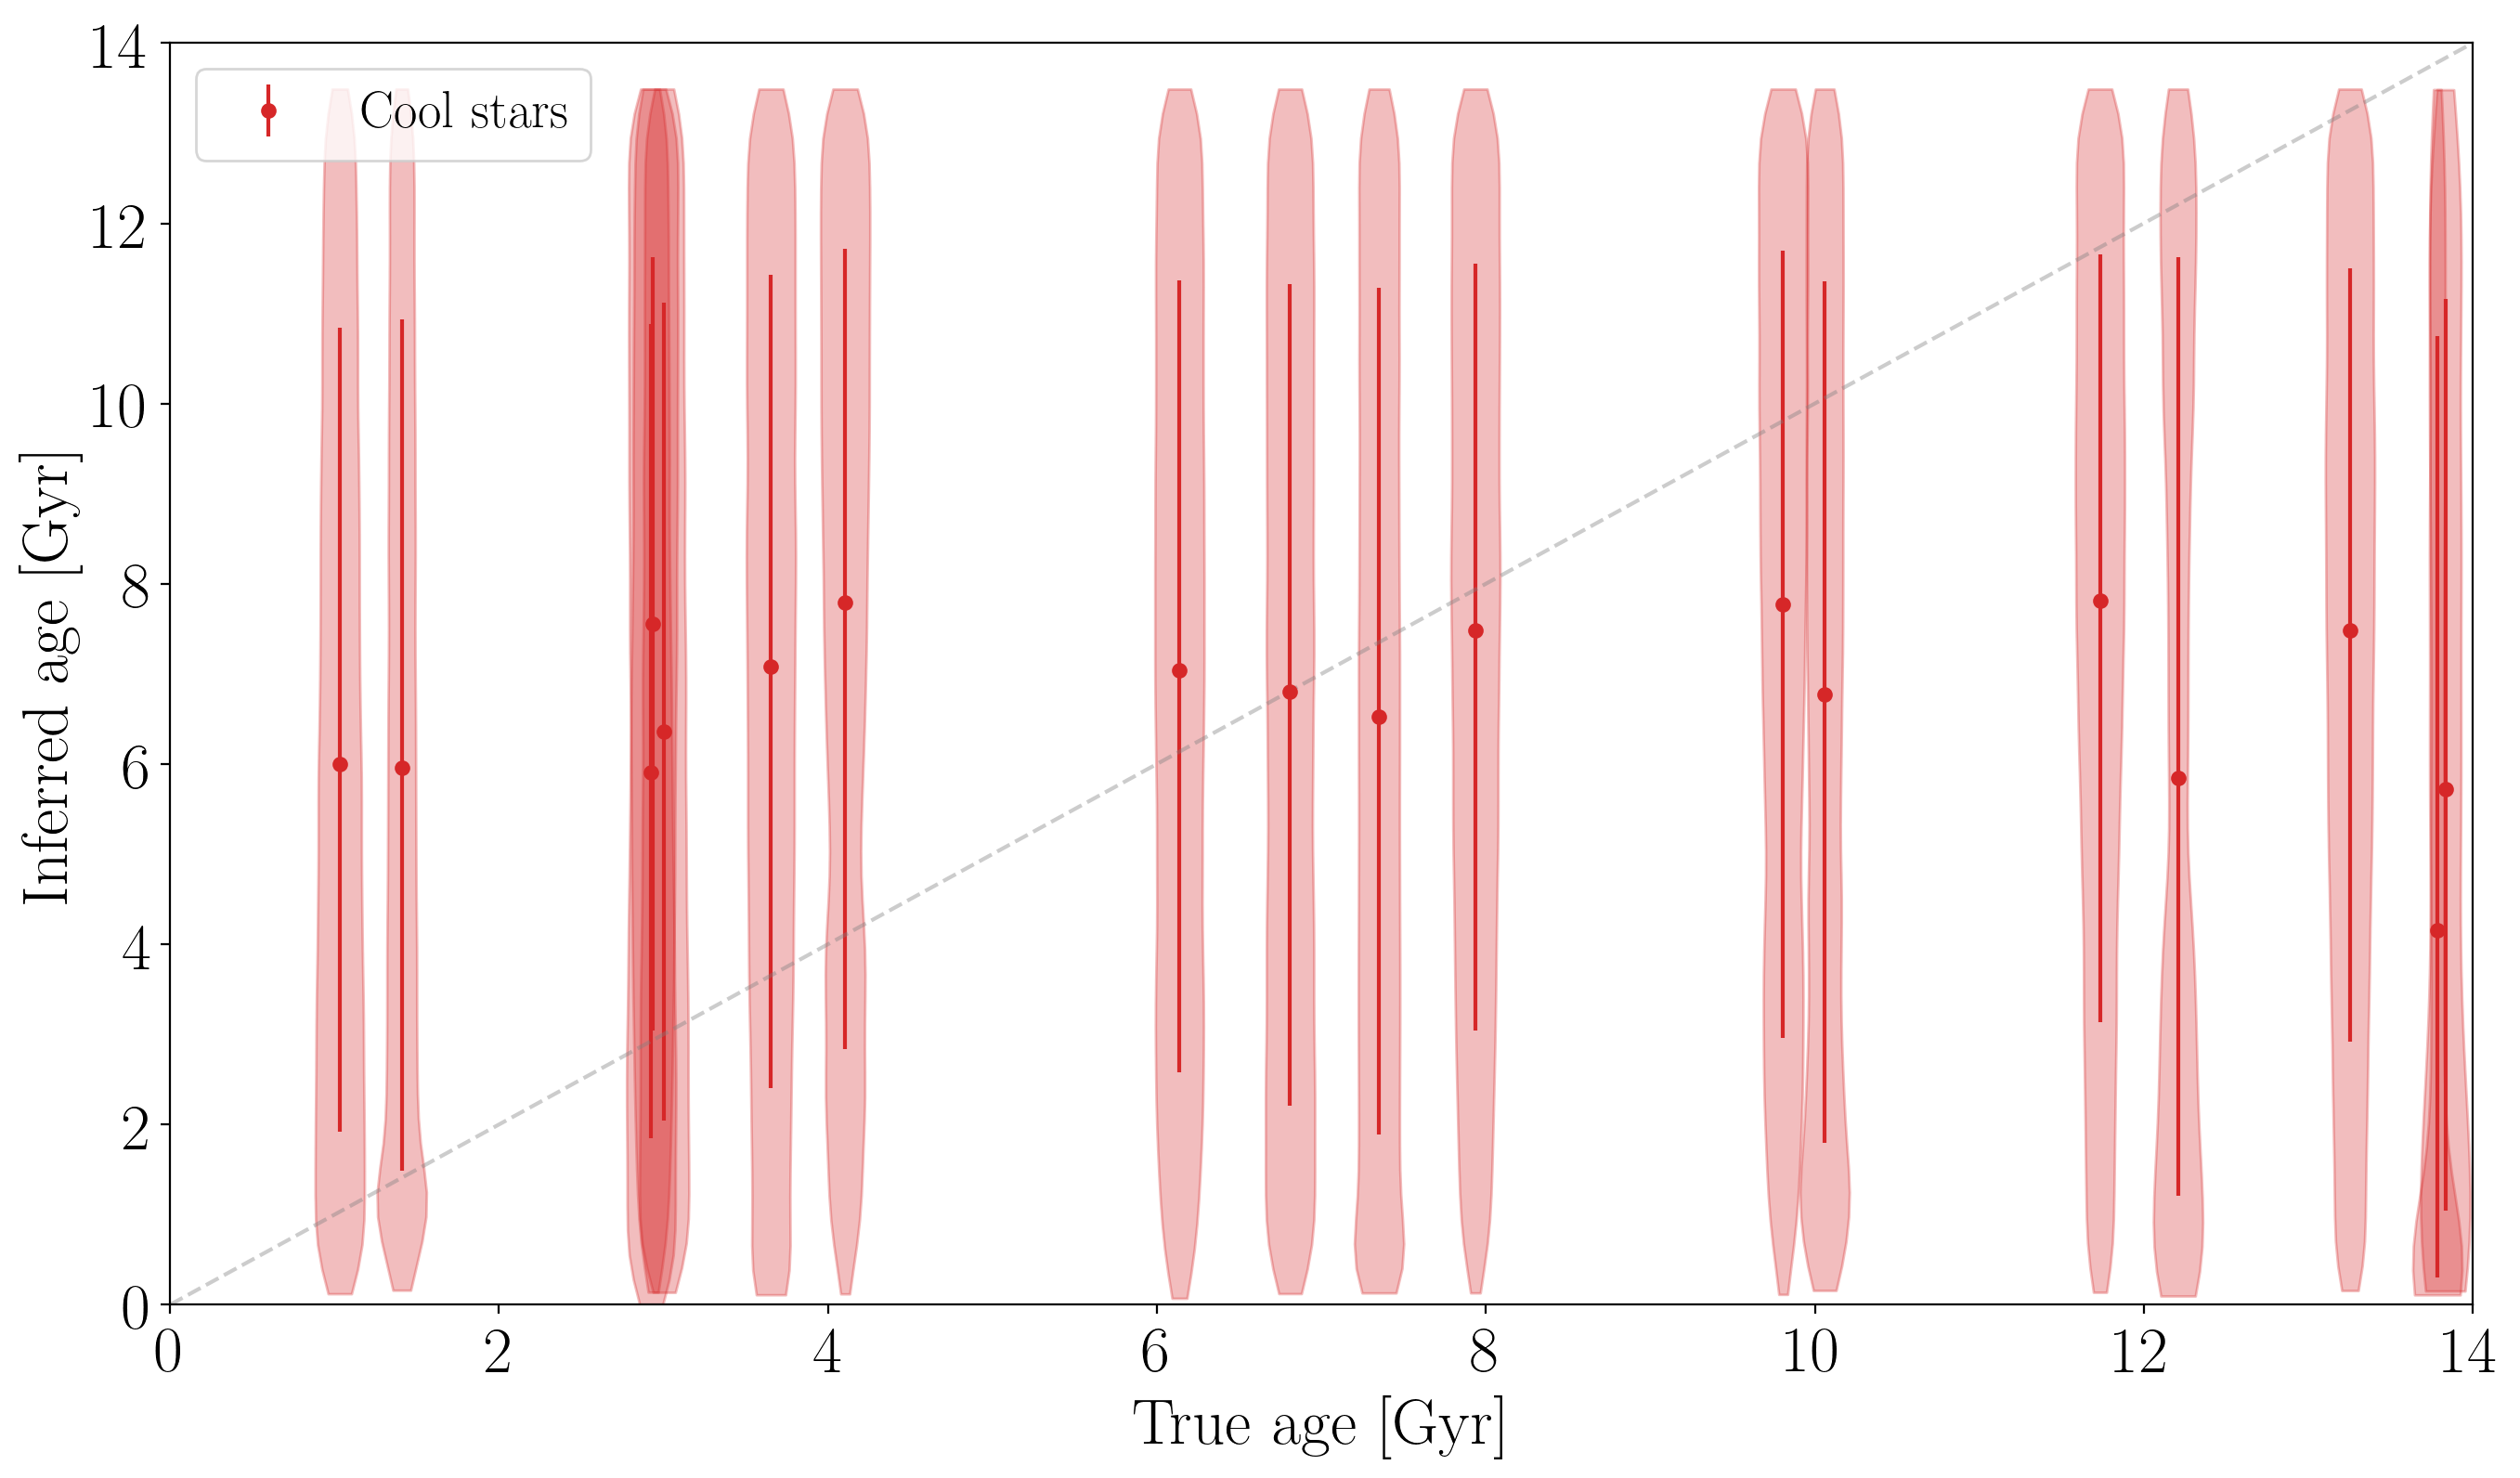

In [386]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=200)
iage_samps = np.array(iage_samps)
parts = axes.violinplot(iage_samps[icool], true_age_gyr[iinds][icool], points=50, widths=0.3,
                showmeans=False, showextrema=False, showmedians=False)
for v in parts["bodies"]:
    v.set_facecolor("tab:red")
    v.set_edgecolor("tab:red")
plt.errorbar(true_age_gyr[iinds][icool], imeds[icool], yerr=[ierrm[icool], ierrp[icool]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{Cool~stars}$", rasterized=True, color="tab:red")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.legend()
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)

(0, 14)

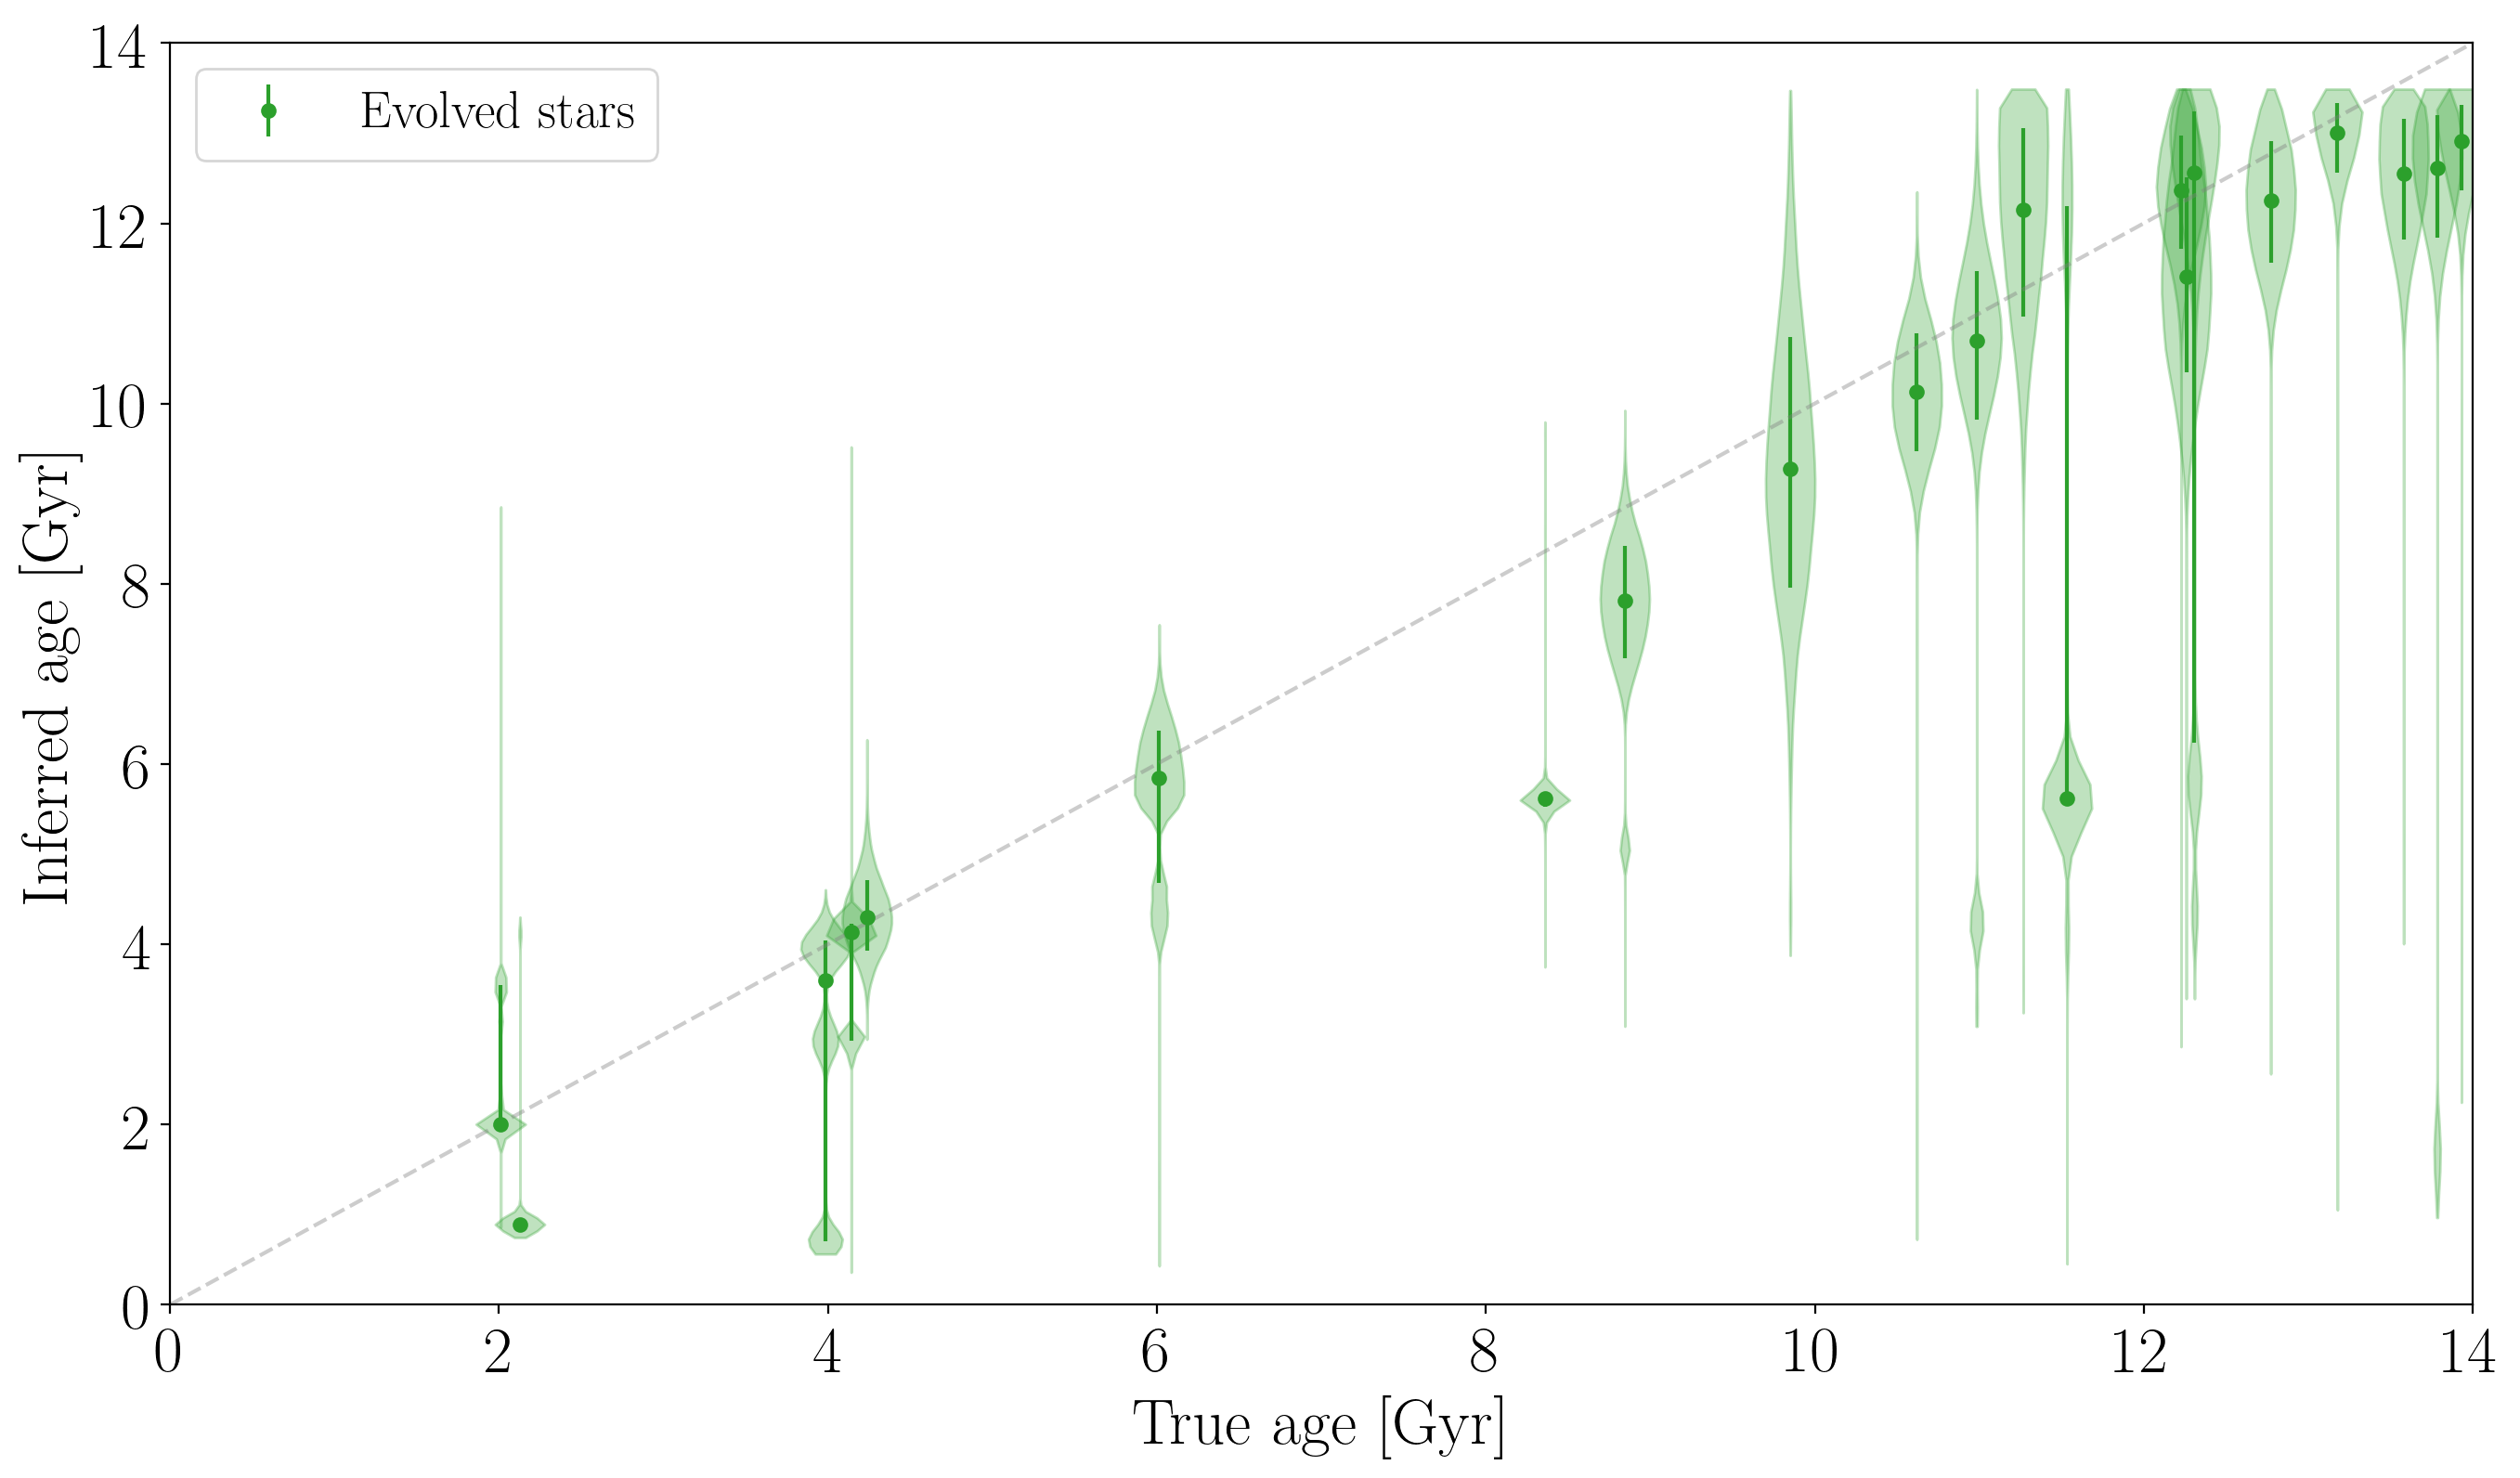

In [387]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=200)
iage_samps = np.array(iage_samps)
parts = axes.violinplot(iage_samps[ievolved], true_age_gyr[iinds][ievolved], points=50, widths=0.3,
                showmeans=False, showextrema=False, showmedians=False)
for v in parts["bodies"]:
    v.set_facecolor("tab:green")
    v.set_edgecolor("tab:green")
plt.errorbar(true_age_gyr[iinds][ievolved], imeds[ievolved], yerr=[ierrm[ievolved], ierrp[ievolved]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{Evolved~stars}$", rasterized=True, color="tab:green")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.legend()
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)

(0, 14)

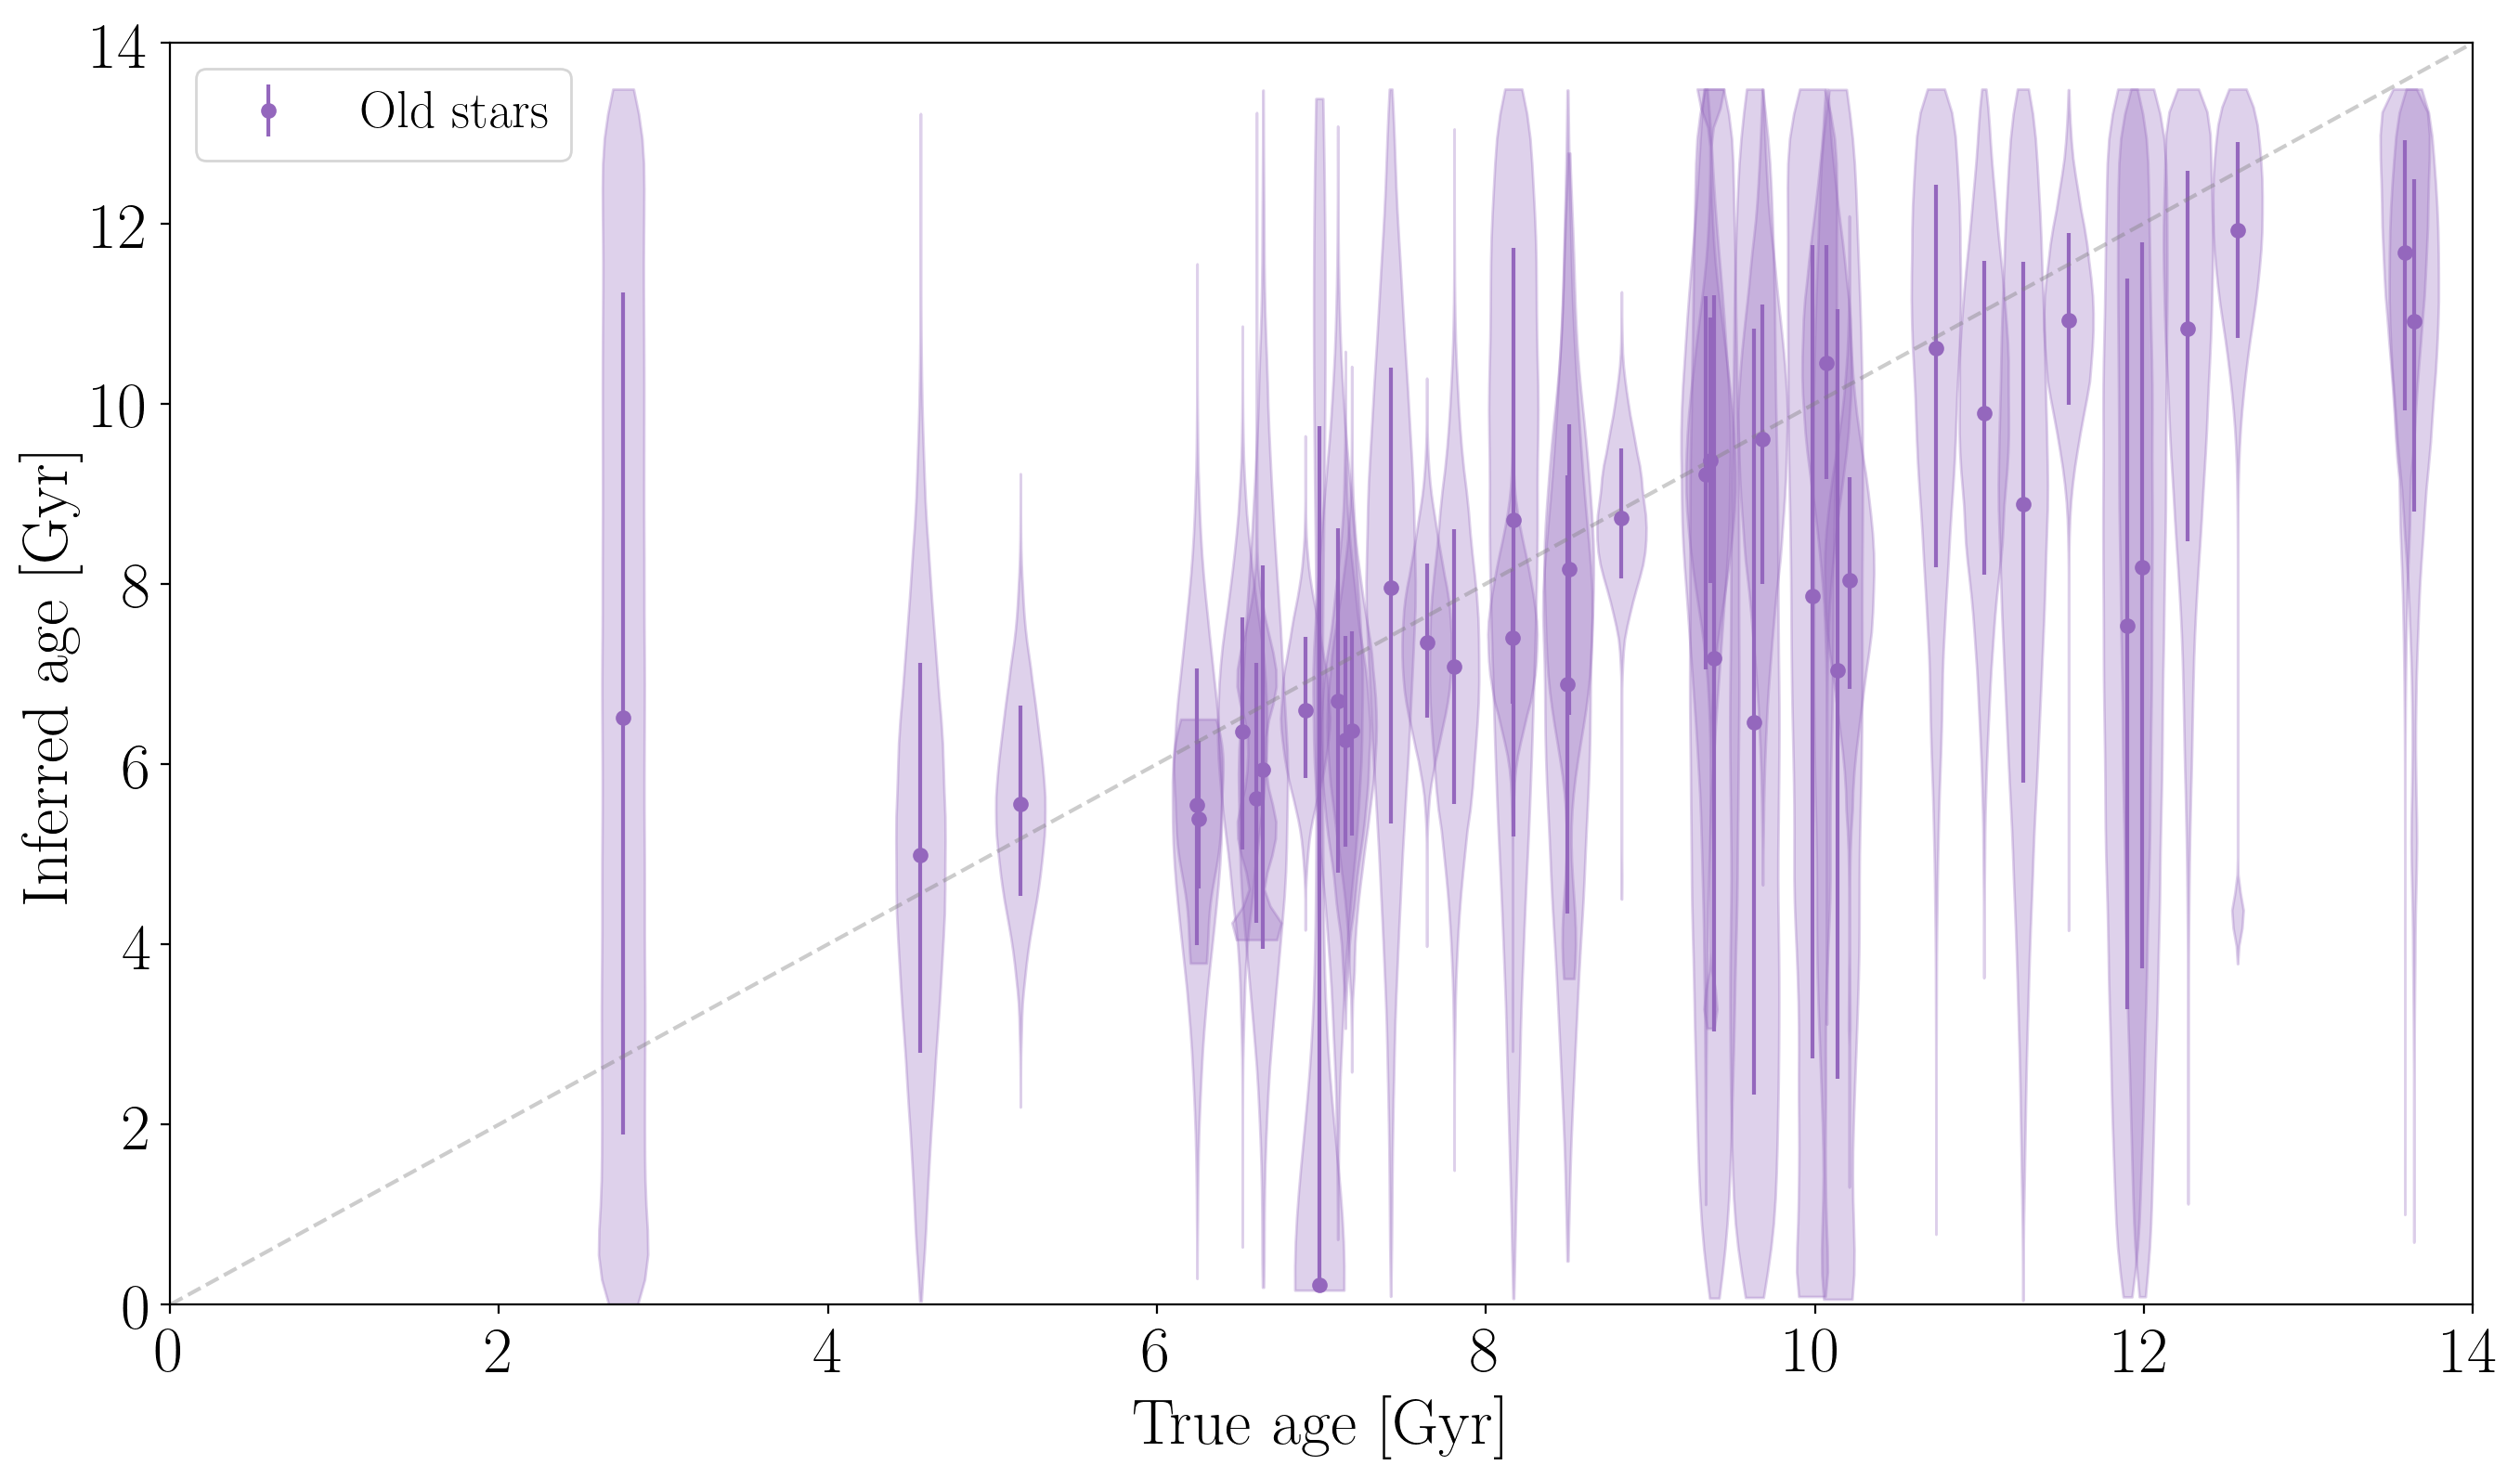

In [388]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=200)
iage_samps = np.array(iage_samps)
parts = axes.violinplot(iage_samps[irossbied], true_age_gyr[iinds][irossbied], points=50, widths=0.3,
                showmeans=False, showextrema=False, showmedians=False)
for v in parts["bodies"]:
    v.set_facecolor("tab:purple")
    v.set_edgecolor("tab:purple")
plt.errorbar(true_age_gyr[iinds][irossbied], imeds[irossbied], yerr=[ierrm[irossbied], ierrp[irossbied]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{Old~stars}$", rasterized=True, color="tab:purple")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.legend()
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)

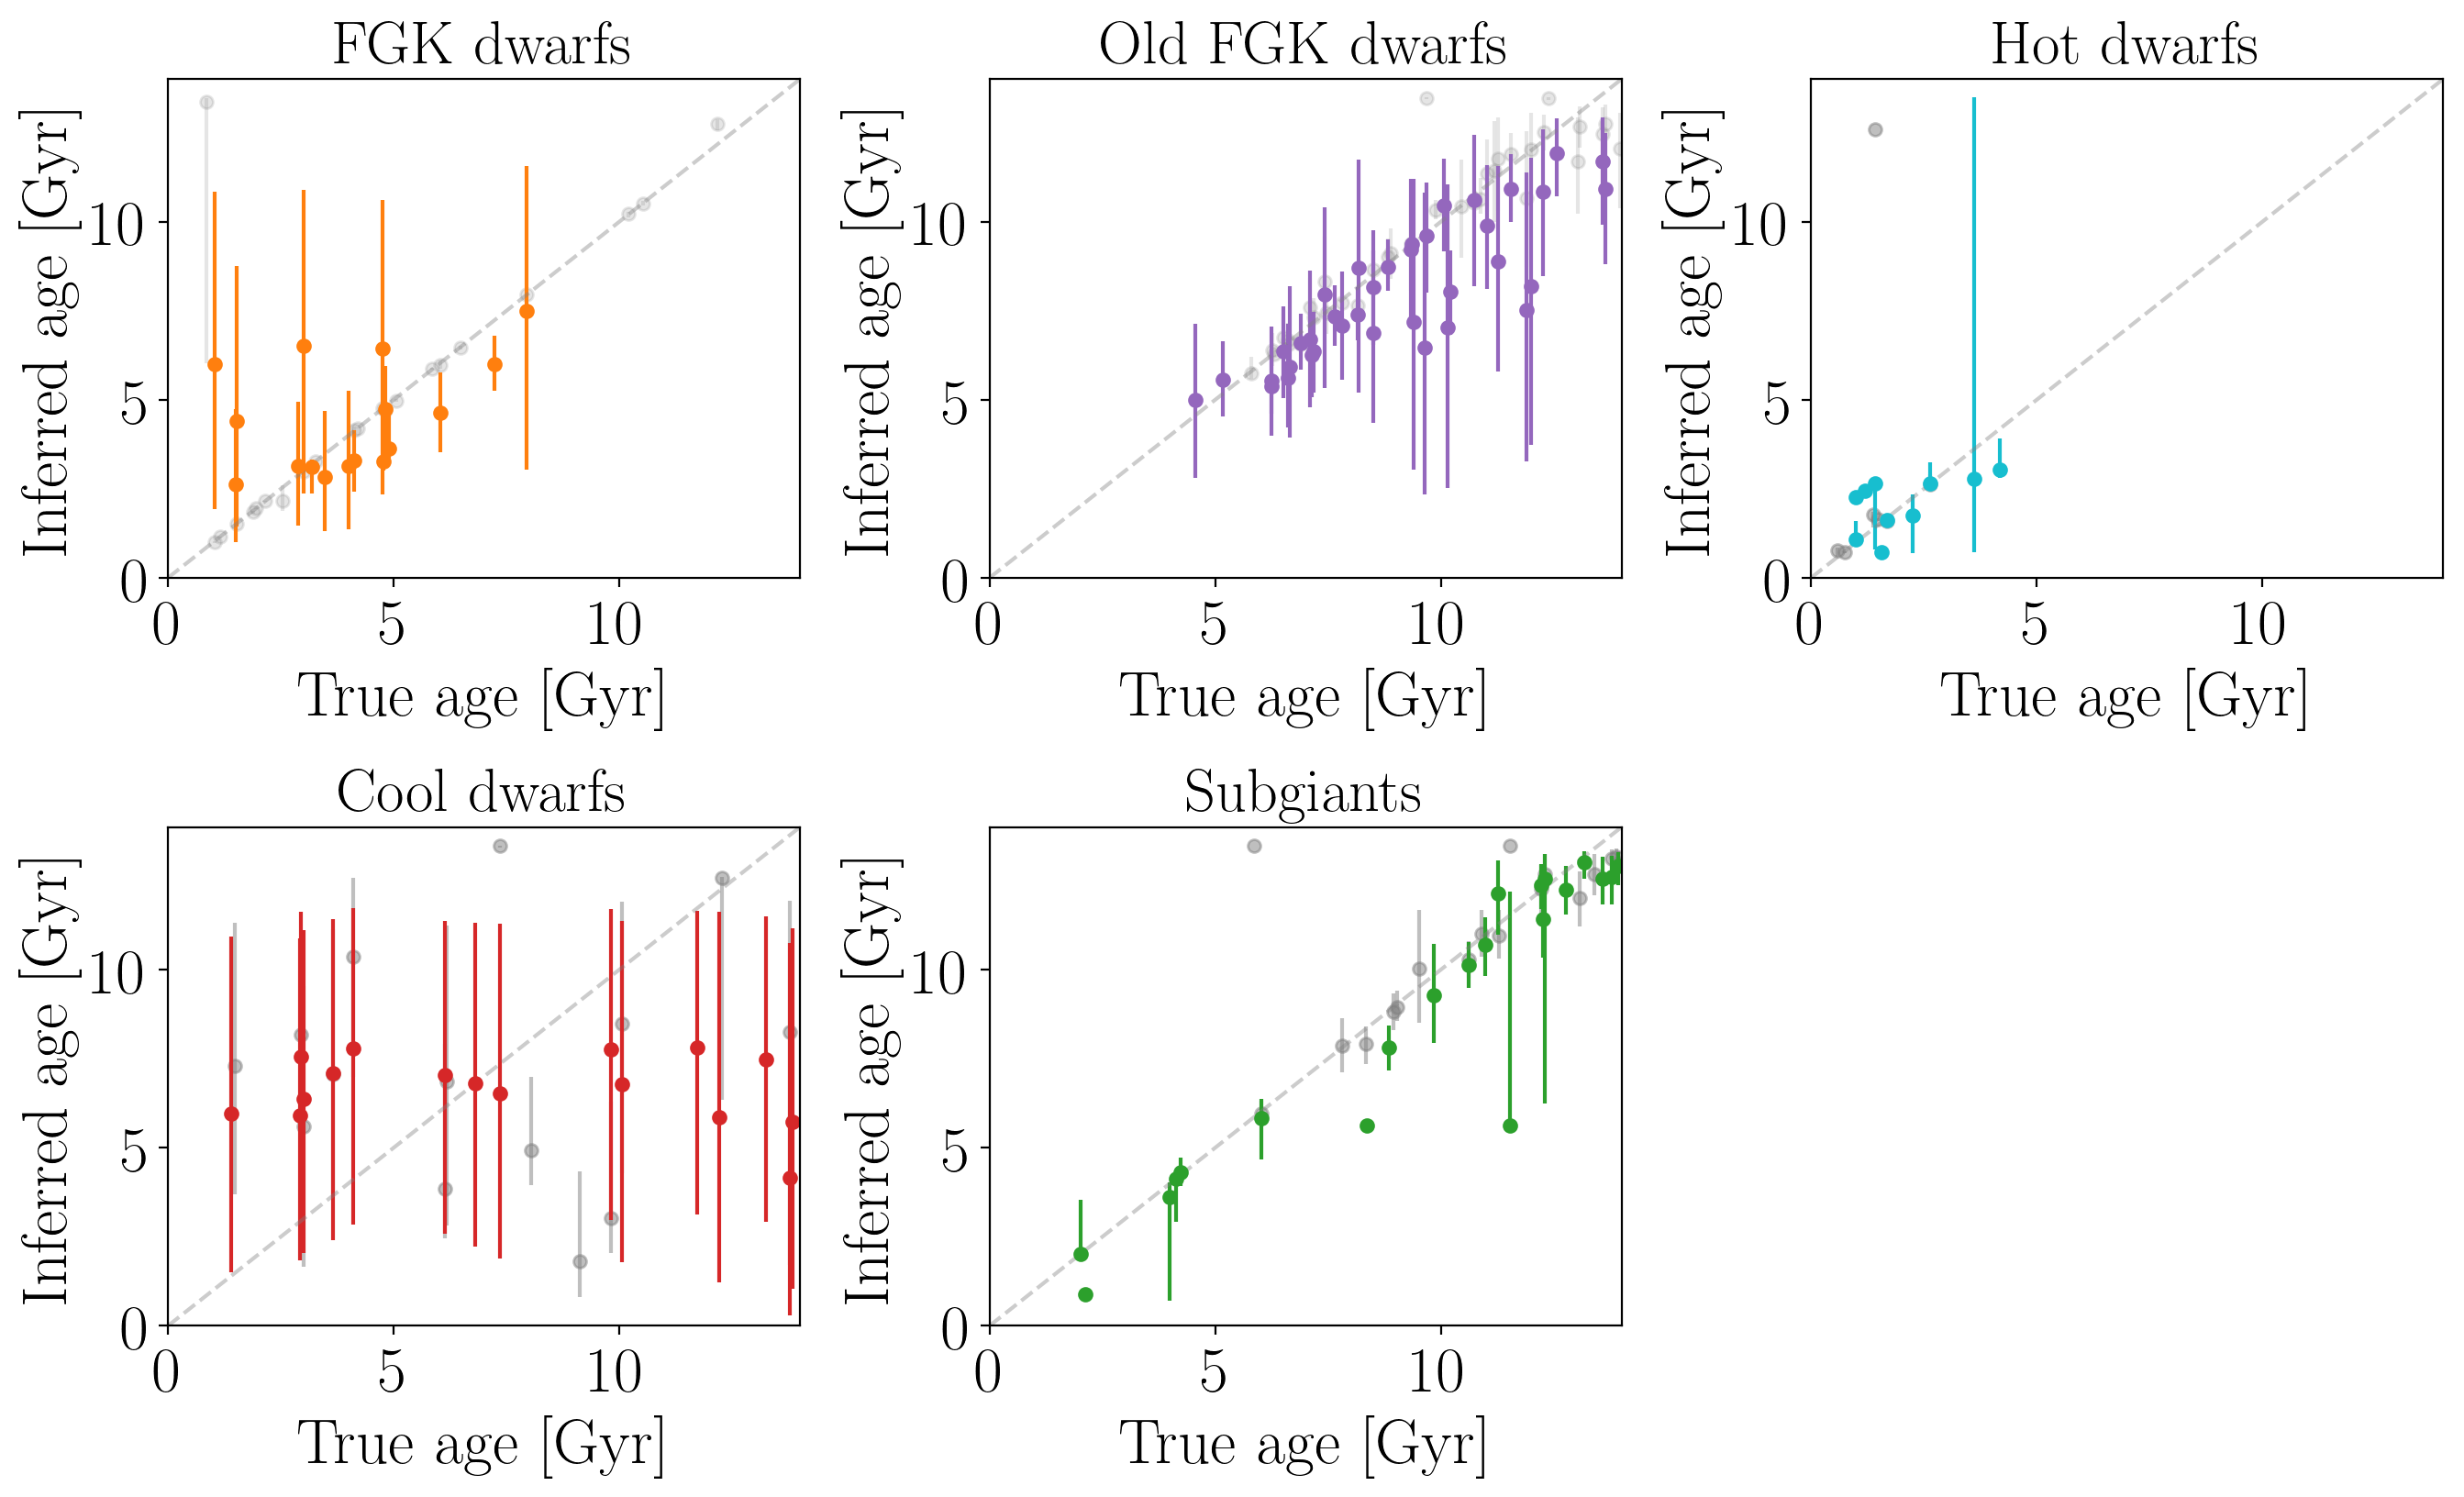

In [559]:
plt.figure(figsize=(16, 9), dpi=200)
plt.subplot(2, 3, 1)
plt.errorbar(true_age_gyr[iinds][ifgk], imeds[ifgk], yerr=[ierrm[ifgk], ierrp[ifgk]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{FGK~dwarfs}$", rasterized=True, color="tab:orange")
plt.errorbar(true_age_gyr[inds][fgk], meds[fgk], yerr=[errm[fgk], errp[fgk]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{FGK~dwarfs}$")

plt.subplot(2, 3, 2)
plt.errorbar(true_age_gyr[iinds][irossbied], imeds[irossbied], yerr=[ierrm[irossbied], ierrp[irossbied]], fmt=".", 
             color="tab:purple", ms=10, zorder=2, label="$\mathrm{Old~dwarfs}$", rasterized=True)
plt.errorbar(true_age_gyr[inds][rossbied], meds[rossbied], yerr=[errm[rossbied], errp[rossbied]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{Old~FGK~dwarfs}$")

plt.subplot(2, 3, 3)
plt.errorbar(true_age_gyr[iinds][ihot], imeds[ihot], yerr=[ierrm[ihot], ierrp[ihot]], fmt=".", 
             color="tab:cyan", ms=10, zorder=2, label="$\mathrm{Hot~dwarfs}$", rasterized=True)
plt.errorbar(true_age_gyr[inds][hot], meds[hot], yerr=[errm[hot], errp[hot]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.5)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{Hot~dwarfs}$")

plt.subplot(2, 3, 4)
plt.errorbar(true_age_gyr[iinds][icool], imeds[icool], yerr=[ierrm[icool], ierrp[icool]], fmt=".",
             color="tab:red", ms=10, zorder=2, label="$\mathrm{Cool~dwarfs}$", rasterized=True)
plt.errorbar(true_age_gyr[inds][cool], meds[cool], yerr=[errm[cool], errp[cool]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.5)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14) 
plt.title("$\mathrm{Cool~dwarfs}$")

plt.subplot(2, 3, 5)
plt.errorbar(true_age_gyr[iinds][ievolved], imeds[ievolved], yerr=[ierrm[ievolved], ierrp[ievolved]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{Evolved}$", rasterized=True, color="tab:green")
plt.errorbar(true_age_gyr[inds][evolved], meds[evolved], yerr=[errm[evolved], errp[evolved]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.5)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{Subgiants}$")

plt.subplots_adjust(wspace=.3, hspace=.5)

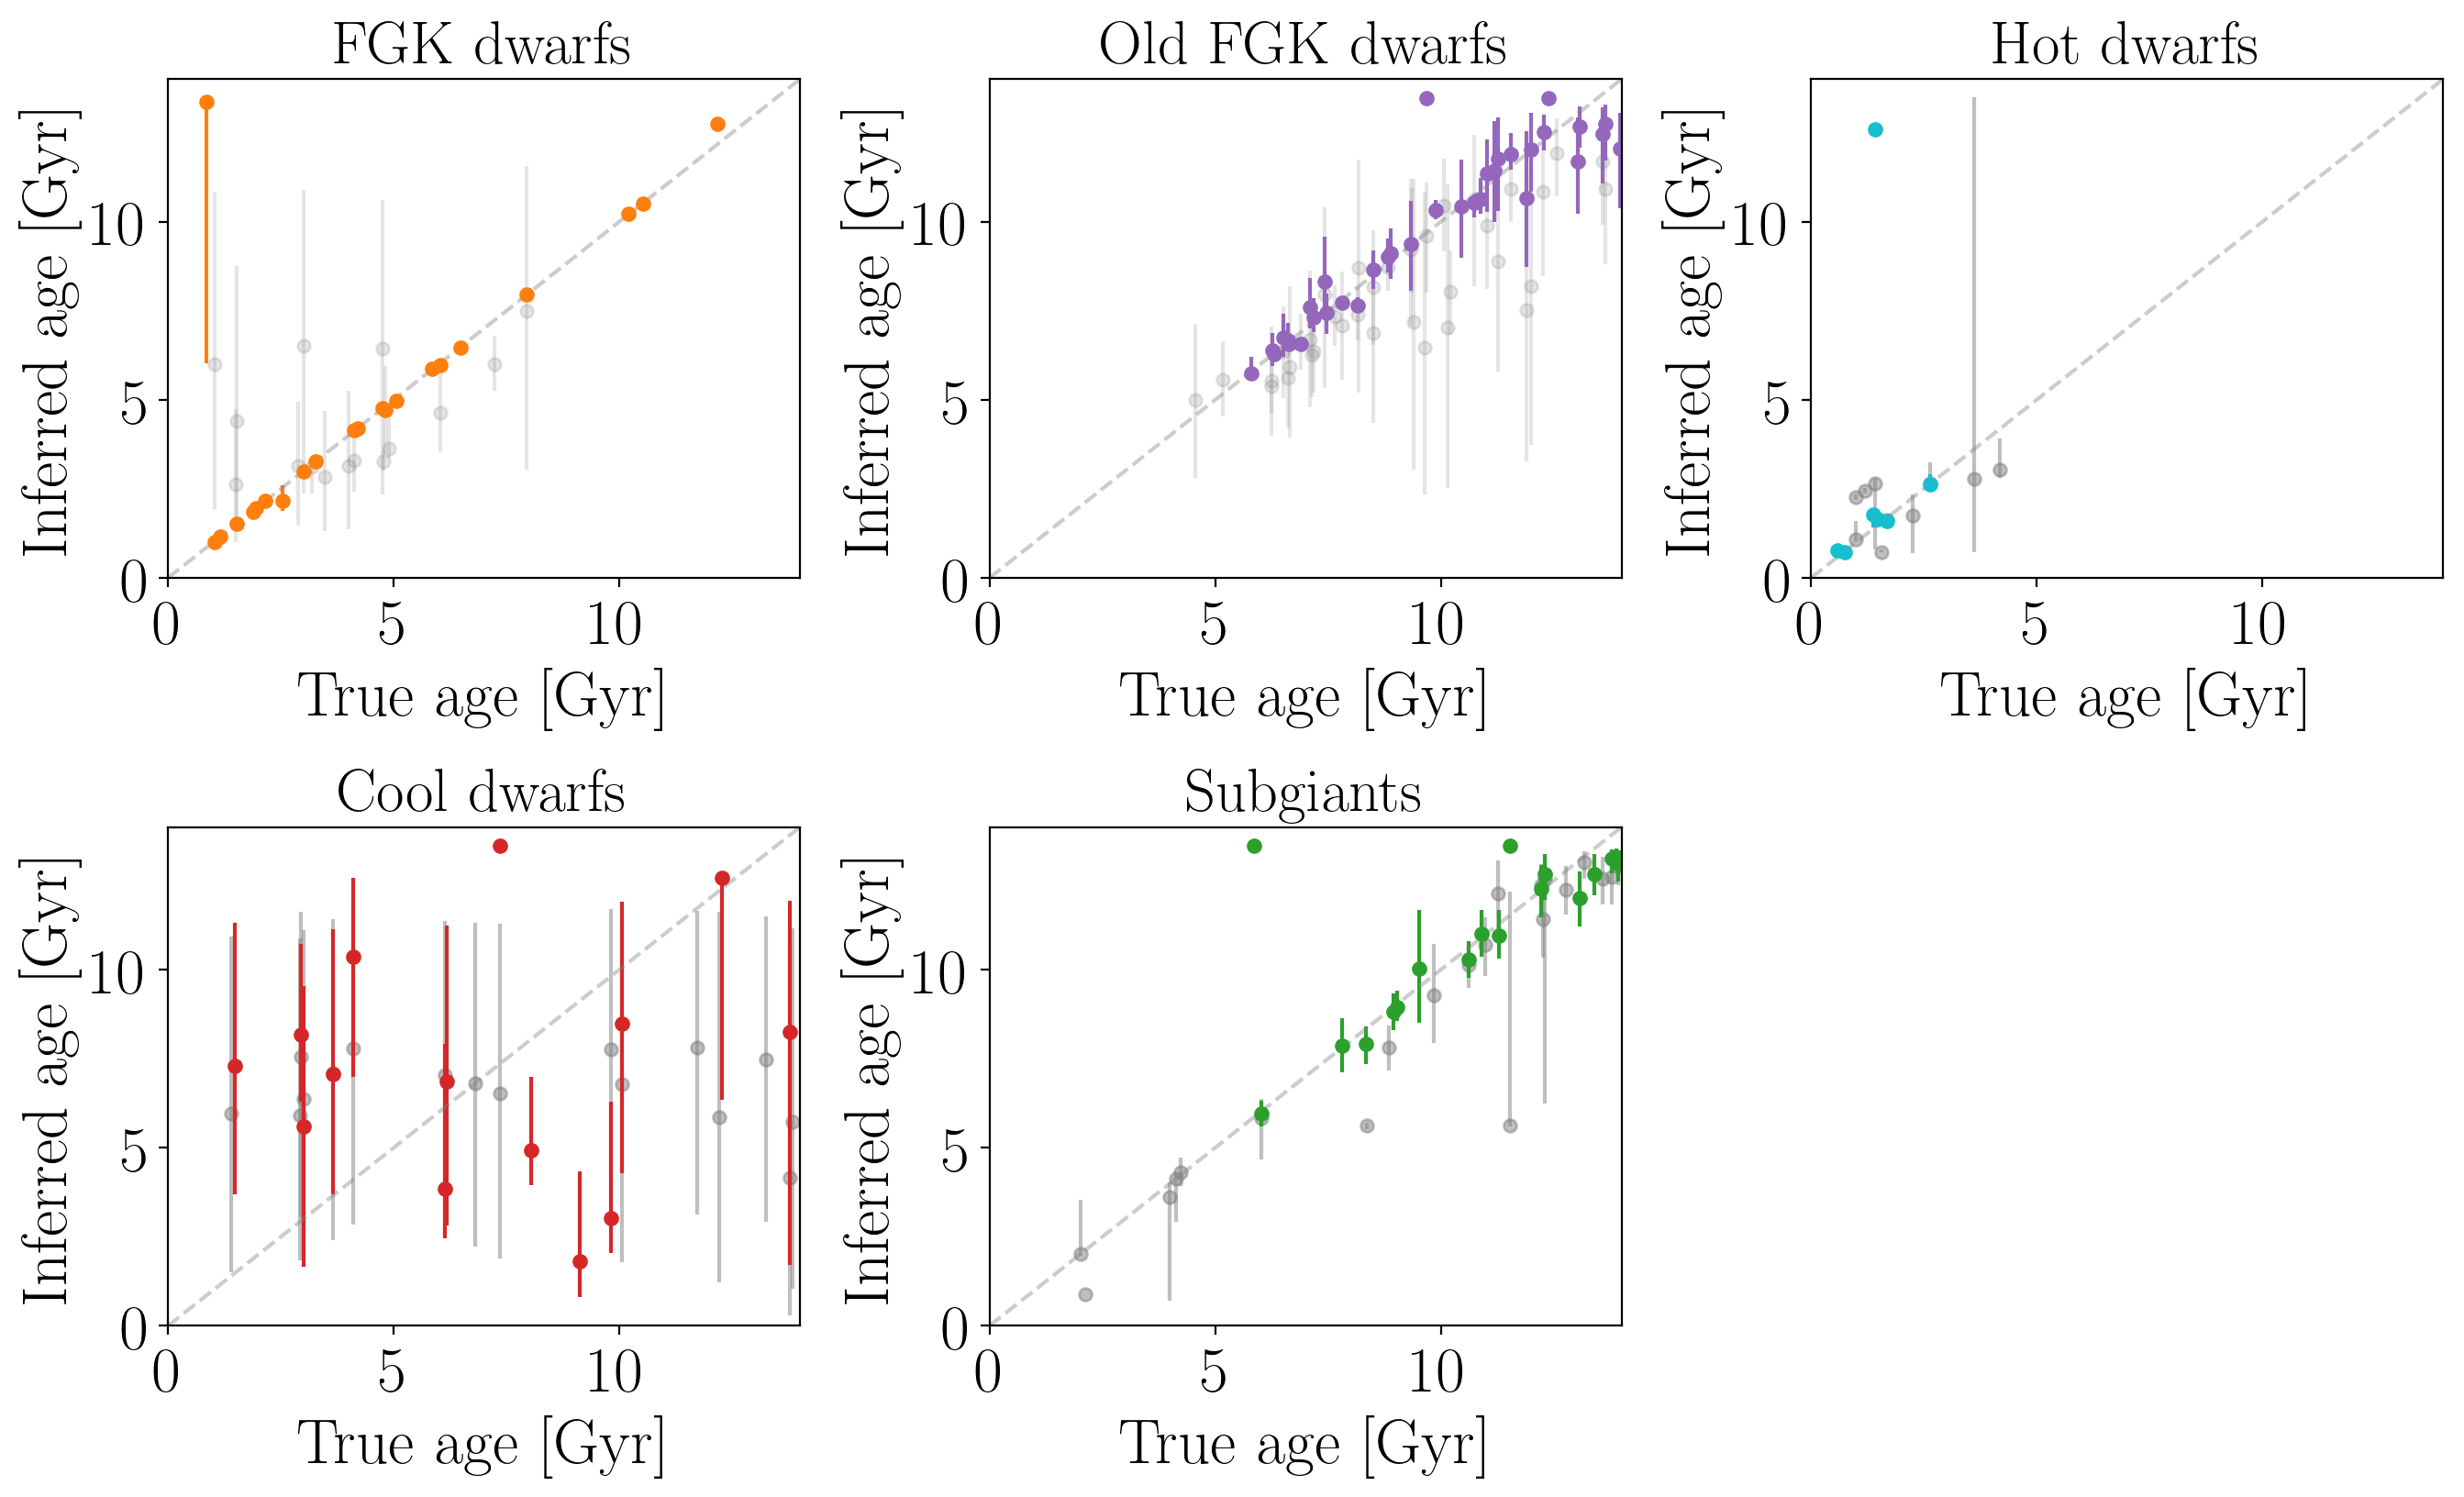

In [561]:
plt.figure(figsize=(16, 9), dpi=200)
plt.subplot(2, 3, 1)
plt.errorbar(true_age_gyr[inds][fgk], meds[fgk], yerr=[errm[fgk], errp[fgk]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{FGK~dwarfs}$", rasterized=True, color="tab:orange")
plt.errorbar(true_age_gyr[iinds][ifgk], imeds[ifgk], yerr=[ierrm[ifgk], ierrp[ifgk]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{FGK~dwarfs}$")

plt.subplot(2, 3, 2)
plt.errorbar(true_age_gyr[inds][rossbied], meds[rossbied], yerr=[errm[rossbied], errp[rossbied]], fmt=".", 
             color="tab:purple", ms=10, zorder=2, label="$\mathrm{Old~dwarfs}$", rasterized=True)
plt.errorbar(true_age_gyr[iinds][irossbied], imeds[irossbied], yerr=[ierrm[irossbied], ierrp[irossbied]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{Old~FGK~dwarfs}$")

plt.subplot(2, 3, 3)
plt.errorbar(true_age_gyr[inds][hot], meds[hot], yerr=[errm[hot], errp[hot]], fmt=".", 
             color="tab:cyan", ms=10, zorder=2, label="$\mathrm{Hot~dwarfs}$", rasterized=True)
plt.errorbar(true_age_gyr[iinds][ihot], imeds[ihot], yerr=[ierrm[ihot], ierrp[ihot]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.5)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{Hot~dwarfs}$")

plt.subplot(2, 3, 4)
plt.errorbar(true_age_gyr[inds][cool], meds[cool], yerr=[errm[cool], errp[cool]], fmt=".",
             color="tab:red", ms=10, zorder=2, label="$\mathrm{Cool~dwarfs}$", rasterized=True)
plt.errorbar(true_age_gyr[iinds][icool], imeds[icool], yerr=[ierrm[icool], ierrp[icool]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.5)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14) 
plt.title("$\mathrm{Cool~dwarfs}$")

plt.subplot(2, 3, 5)
plt.errorbar(true_age_gyr[inds][evolved], meds[evolved], yerr=[errm[evolved], errp[evolved]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{Evolved}$", rasterized=True, color="tab:green")
plt.errorbar(true_age_gyr[iinds][ievolved], imeds[ievolved], yerr=[ierrm[ievolved], ierrp[ievolved]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.5)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.legend()
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.title("$\mathrm{Subgiants}$")

plt.subplots_adjust(wspace=.3, hspace=.5)